# Importing Libraries and Dataframe

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import pandas as pd
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Splits
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score
from scipy.stats import ttest_rel, wilcoxon
from scipy import stats

# Models
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    RationalQuadratic,
    ConstantKernel as C,
    WhiteKernel,
    DotProduct,
    Matern       
)


# Bayesian Optimization
from skopt import gp_minimize, BayesSearchCV
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Clustering & PCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

# Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Typing
from typing import Optional, Tuple
import os


In [2]:
# helper function for boxplotting

def make_combined_boxplot(welldata, inputs, title="Boxplots", filename="boxplots.png"):
    # Split inputs into chunks
    inputs_split = [inputs[:10], inputs[10:20], inputs[20:30],  inputs[30:45]]
    n_rows = len(inputs_split)
    n_cols = max(len(group) for group in inputs_split)

    # Create figure and axes
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 5), squeeze=False)

    # Plotting each group
    for i, input_group in enumerate(inputs_split):
        for j in range(n_cols):
            if j < len(input_group):
                ax = axs[i, j]
                sns.boxplot(
                    y=welldata[input_group[j]],
                    ax=ax,
                    color='cornflowerblue',
                    showmeans=True,
                    meanprops={
                        "marker": "o", "markerfacecolor": "white",
                        "markeredgecolor": "black", "markersize": 10
                    },
                    flierprops={
                        'marker': 'o', 'markerfacecolor': 'darkgreen',
                        'markeredgecolor': 'darkgreen'
                    }
                )
                ax.set_title(input_group[j], fontsize=10)
                ax.set_ylabel('')
            else:
                fig.delaxes(axs[i, j])  # Remove empty subplots

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave room for the title
    plt.savefig(filename, dpi=300)
    plt.show()

In [63]:
#reading the dataframe
df = pd.read_csv('FCC Master Sheet - Sanitized.csv')
# df.dropna(inplace=True)
print(df)

       RUN No.  Avg ROT ( °C) Catalyst  STM.(% of feed)           Feed  \
0   2312-PP-09          645.3    CAT-1        25.925926  Light Naphtha   
1   2312-PP-10          660.2    CAT-1        25.872690  Light Naphtha   
2   2312-PP-11          660.8    CAT-1        15.625000  Light Naphtha   
3   2312-PP-12          669.9    CAT-1        15.120968  Light Naphtha   
4   2312-PP-13          646.4    CAT-2        15.212982  Light Naphtha   
..         ...            ...      ...              ...            ...   
84  2295-PP-09          561.8    CAT-5        23.885350           VGO2   
85  2295-PP-14          562.6    CAT-6        25.000000           VGO2   
86  2295-PP-16          562.1    CAT-6        24.232633           VGO2   
87  2295-PP-13          562.4    CAT-6        25.295110           VGO2   
88  2295-PP-15          563.6    CAT-6        33.898305           VGO2   

    Mass balance (%)    Cat/Oil  Conversion (%)        H2         C1  ...  \
0          97.951055  31.971399   

In [4]:
#Checking exact feed names
df['Feed'].unique()

array(['Light Naphtha', 'VGO2', 'Heavy Naphtha', 'VGO1'], dtype=object)

In [5]:
#keeping the needed data types only
df = df[df['Feed'].isin(['VGO1', 'VGO2'])].reset_index(drop=True)

# Exploratory Data Analysis (EDA) 

In [6]:
df.columns

Index(['RUN No.', 'Avg ROT ( °C)', 'Catalyst', 'STM.(% of feed)', 'Feed',
       'Mass balance (%)', 'Cat/Oil', 'Conversion (%)', 'H2', 'C1', 'C2',
       'C2=', 'C3', 'C3=', 'iC4', 'nC4', 't2C4=', '1C4=', 'iC4=', 'c2C4=',
       '1,3-BD', 'C4=(Liq.)', 'Total Gas', 'Gasoline', 'LCO', 'HCO', 'Coke',
       'H2-C2 (dry gas)', 'C3-C4 (LPG)', 'C2=-C4= (Light olefins)', 'C3=+C4=',
       'C4= (Butenes)', 'C2=/C2', 'C3=/C3', 'C4=/C4', 'iC4=/C4=', 'iC4=/iC4',
       'Res Time based on exit cond, (second)'],
      dtype='object')

In [7]:
# unwanted = []
# df = df[~df['Feed'].isin(unwanted)].copy()

VGO2     44
VGO1     10
Total    54
dtype: int64


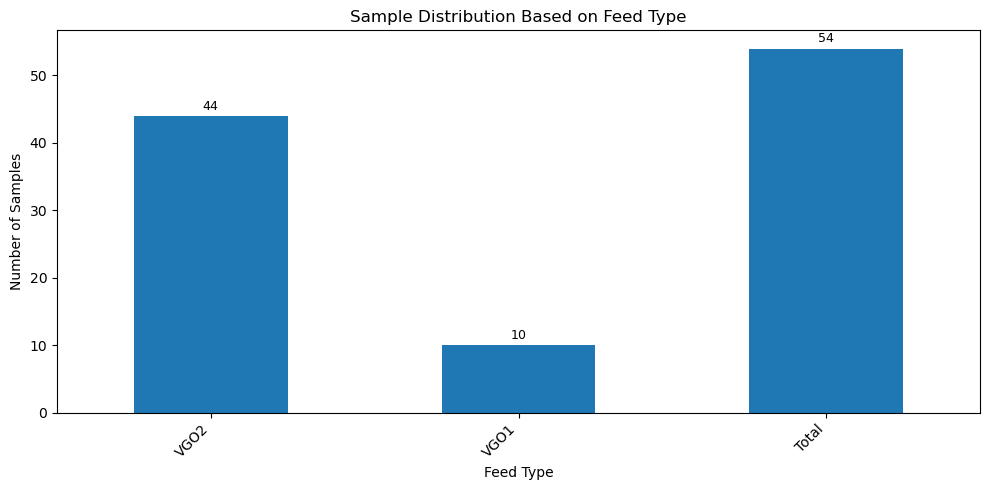

In [8]:
# --- Count samples per feed ---
feed_counts = df['Feed'].value_counts()

# --- Add final "Total" row ---
feed_counts_with_total = pd.concat([
    feed_counts,
    pd.Series({'Total': feed_counts.sum()})
])

print(feed_counts_with_total)

# --- Plot ---
plt.figure(figsize=(10, 5))
ax = feed_counts_with_total.plot(kind='bar')

plt.xlabel('Feed Type')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution Based on Feed Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# --- Add numbers on top of bars ---
for i, value in enumerate(feed_counts_with_total):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

# Save figure
plt.savefig('Sample Distribution Based on Feed Type.png', dpi=300, bbox_inches='tight')

plt.show()


CAT-8    21
CAT-6     9
CAT-5     8
CAT-3     6
CAT-4     6
CAT-7     4
Total    54
dtype: int64


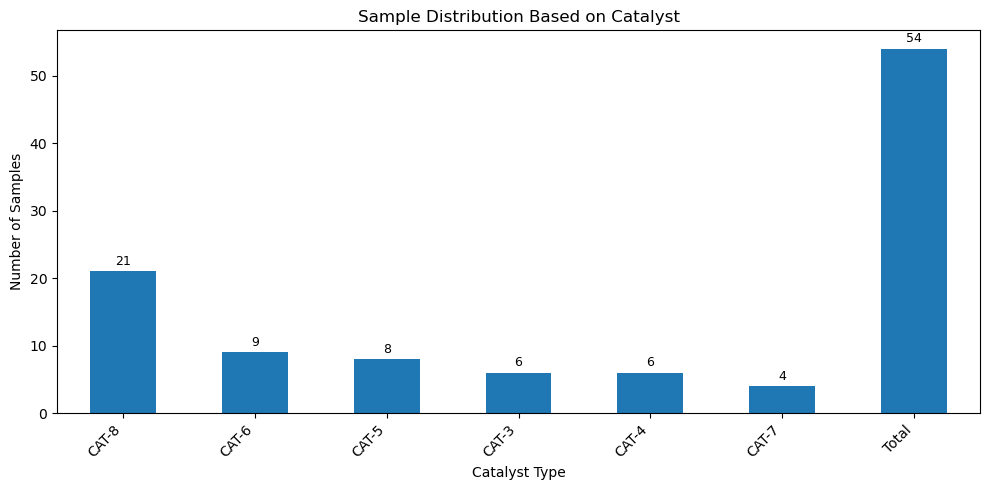

In [9]:
# --- Count samples per Catalyst ---
catalyst_counts = df['Catalyst'].value_counts()

# --- Add final "Total" row ---
catalyst_counts_with_total = pd.concat([
    catalyst_counts,
    pd.Series({'Total': catalyst_counts.sum()})
])

print(catalyst_counts_with_total)

# --- Plot ---
plt.figure(figsize=(10, 5))
ax = catalyst_counts_with_total.plot(kind='bar')

plt.xlabel('Catalyst Type')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution Based on Catalyst')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# --- Add numbers on top of bars ---
for i, value in enumerate(catalyst_counts_with_total):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

# Save figure
plt.savefig('Sample Distribution Based on Catalyst.png', dpi=300, bbox_inches='tight')

plt.show()


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 38 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   RUN No.                                54 non-null     object 
 1   Avg ROT ( °C)                          54 non-null     float64
 2   Catalyst                               54 non-null     object 
 3   STM.(% of feed)                        54 non-null     float64
 4   Feed                                   54 non-null     object 
 5   Mass balance (%)                       54 non-null     float64
 6   Cat/Oil                                54 non-null     float64
 7   Conversion (%)                         54 non-null     float64
 8   H2                                     54 non-null     float64
 9   C1                                     54 non-null     float64
 10  C2                                     54 non-null     float64
 11  C2=     

In [11]:
#dropping the columns with missing data
df = df.drop(columns = ["C4=(Liq.)", "Res Time based on exit cond, (second)"])

In [12]:
#fixing the data types
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except ValueError:
        df[col] = df[col].astype(str)

In [13]:
#separating data
tags = df[['RUN No.', 'Catalyst', 'Feed']]
data = df.drop(columns =['RUN No.', 'Catalyst', 'Feed'])
targets = df[['Conversion (%)', 'Gasoline']]

Avg ROT ( °C)
Skew : 0.94


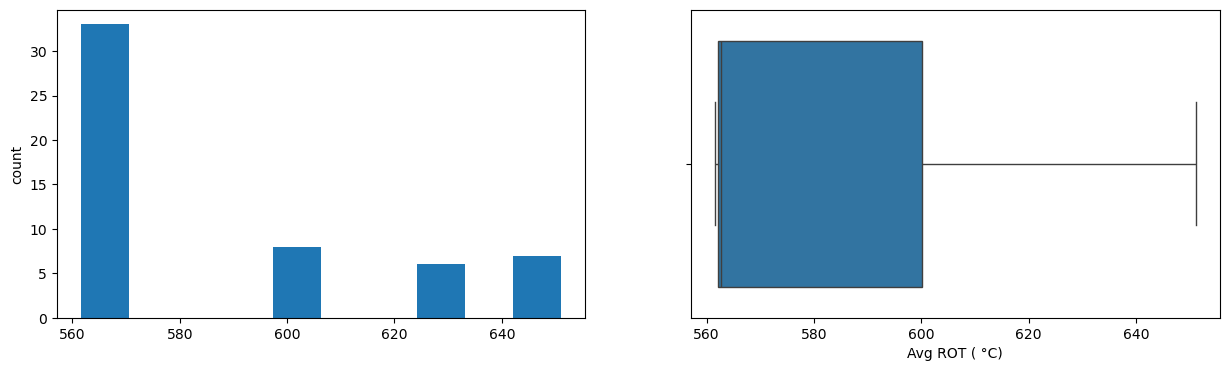

STM.(% of feed)
Skew : -0.29


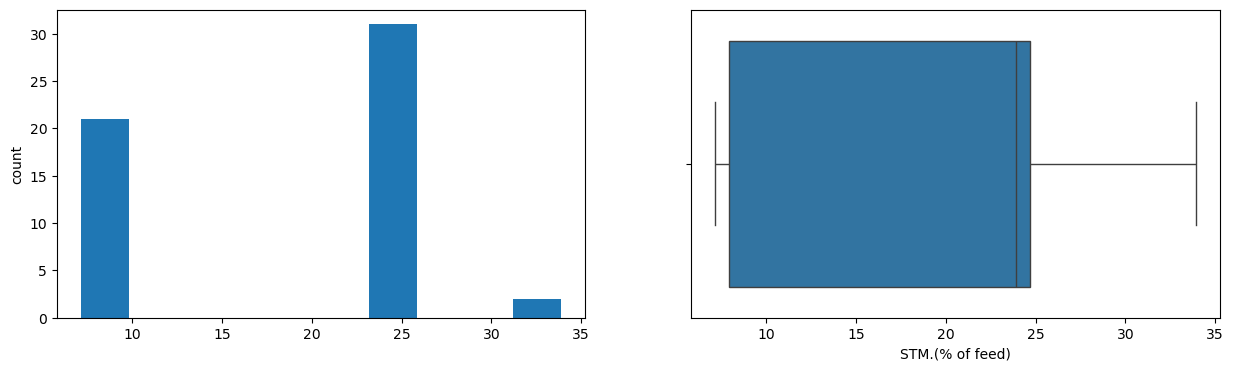

Mass balance (%)
Skew : -0.48


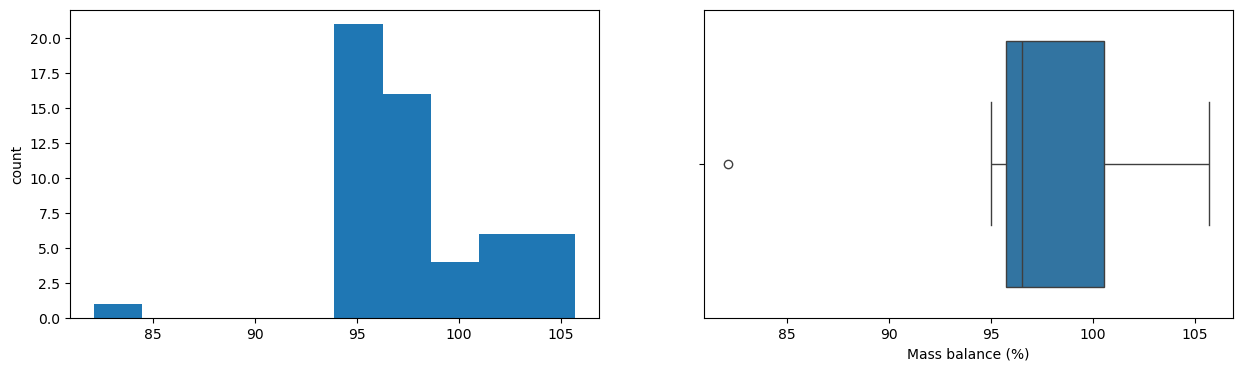

Cat/Oil
Skew : 1.12


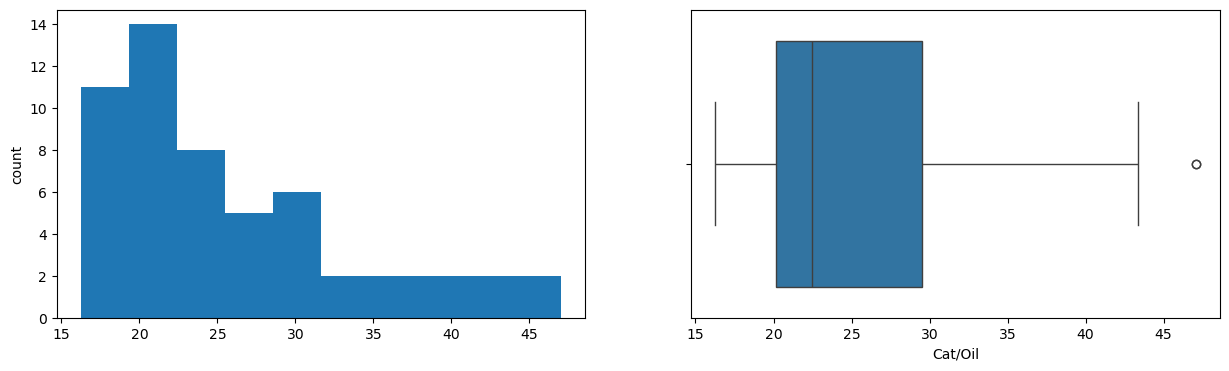

Conversion (%)
Skew : -0.02


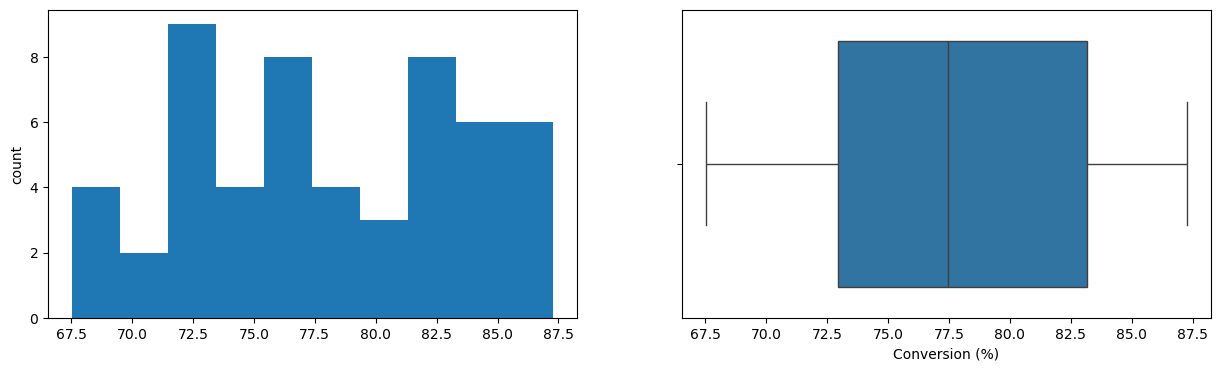

H2
Skew : 1.17


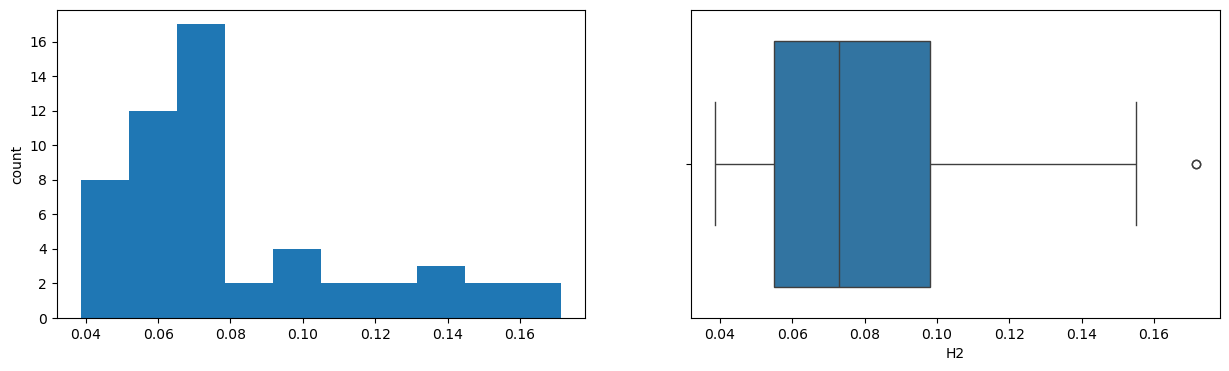

C1
Skew : 1.24


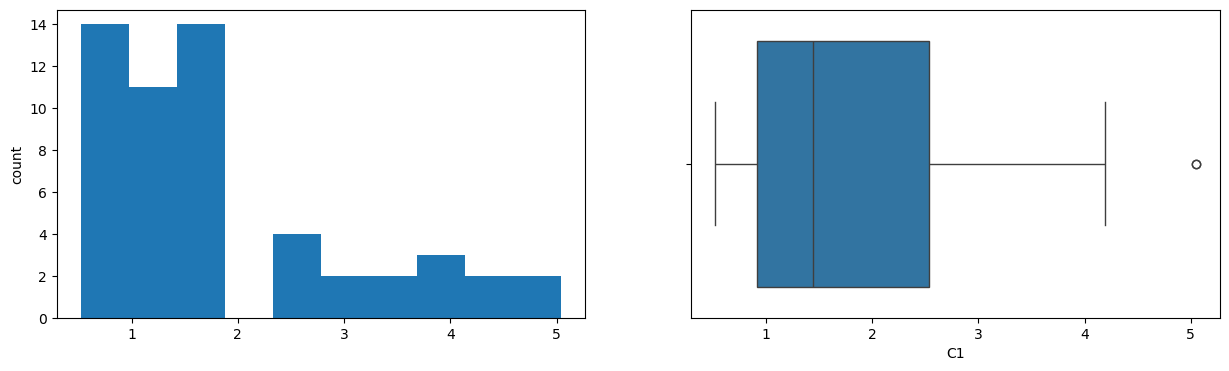

C2
Skew : 1.09


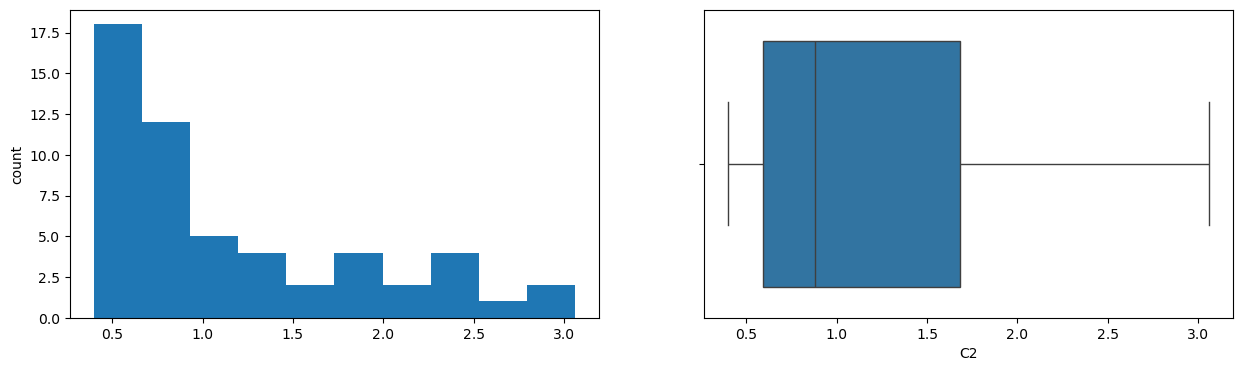

C2=
Skew : 0.86


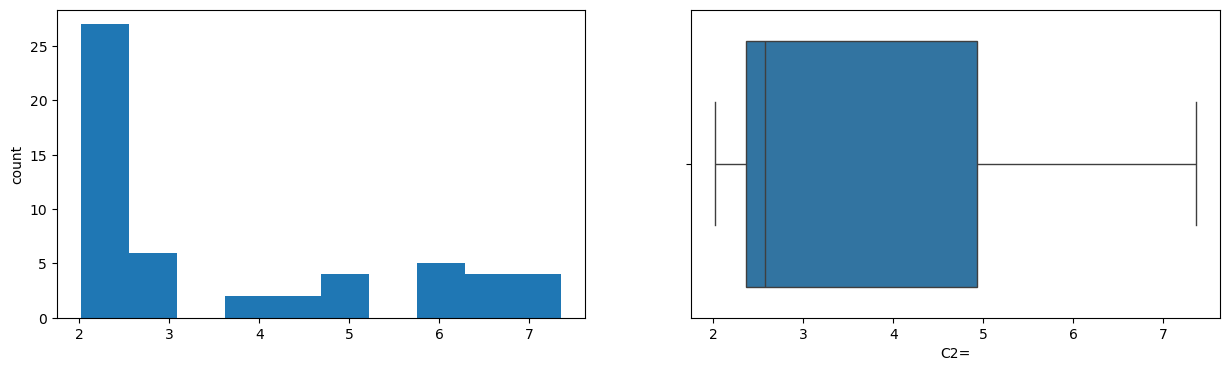

C3
Skew : 0.82


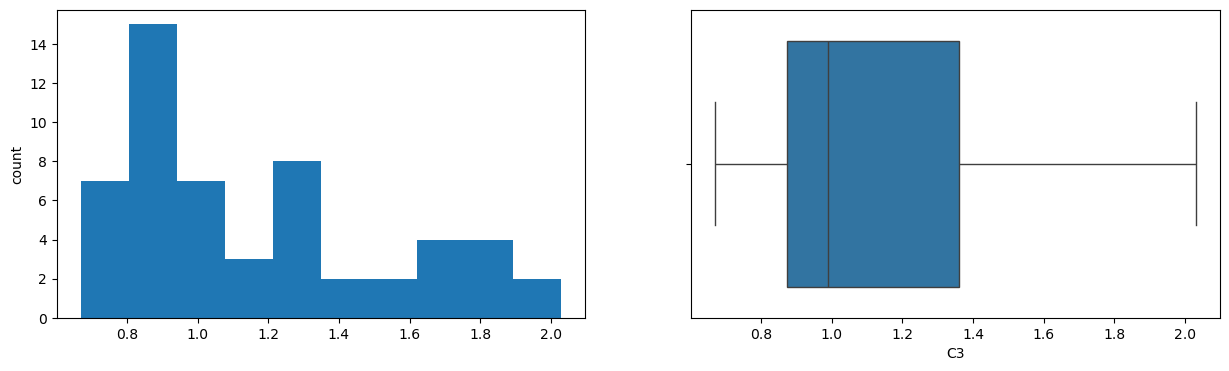

C3=
Skew : 0.41


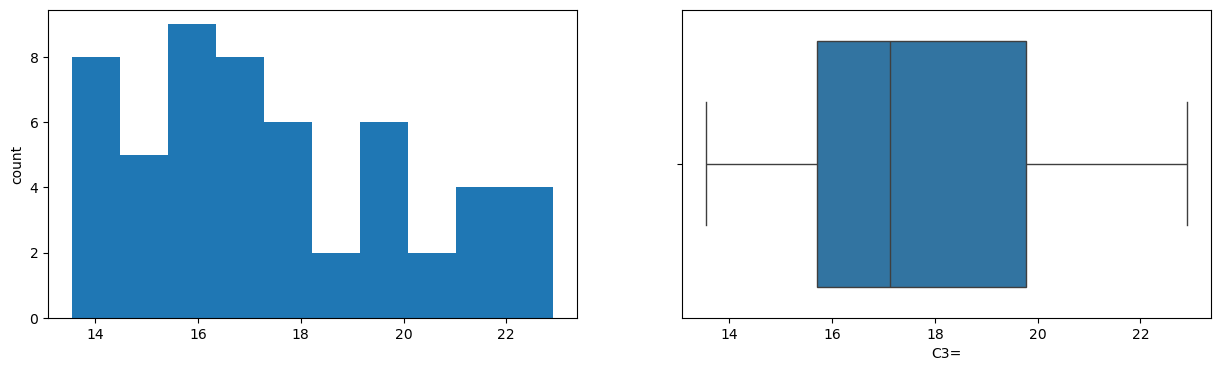

iC4
Skew : -0.5


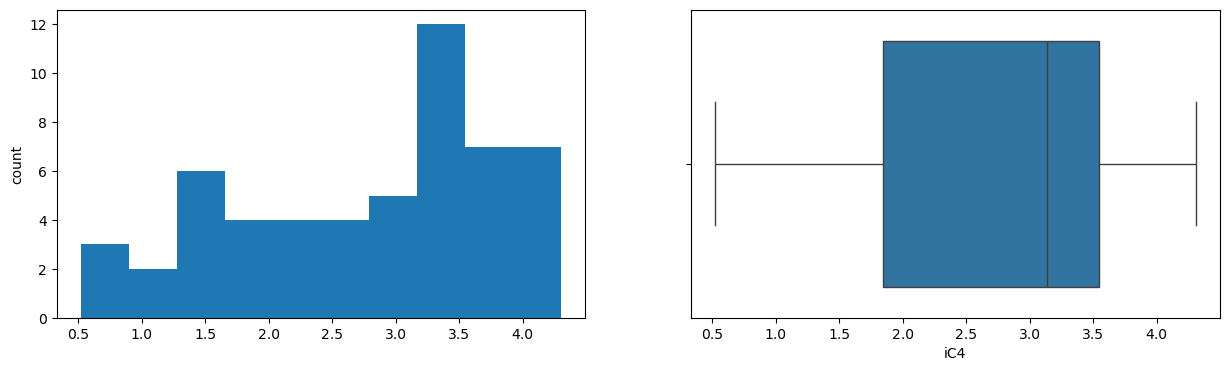

nC4
Skew : 0.41


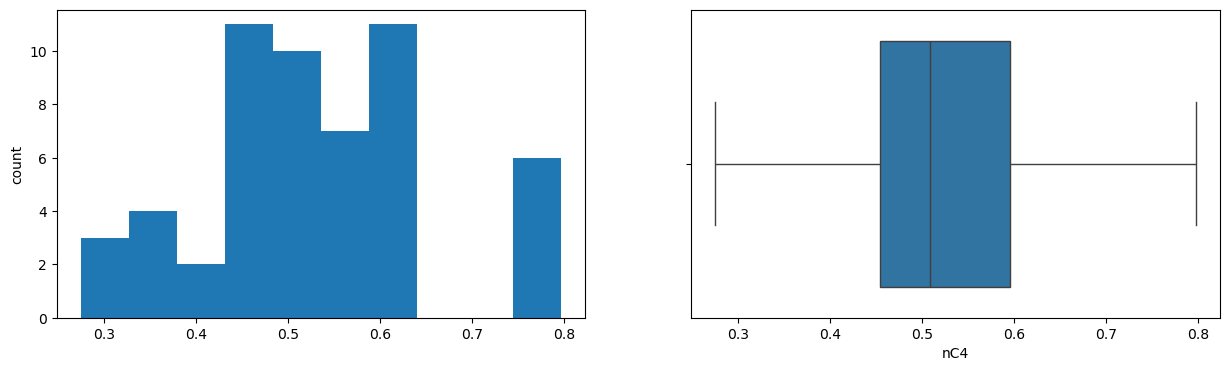

t2C4=
Skew : -0.02


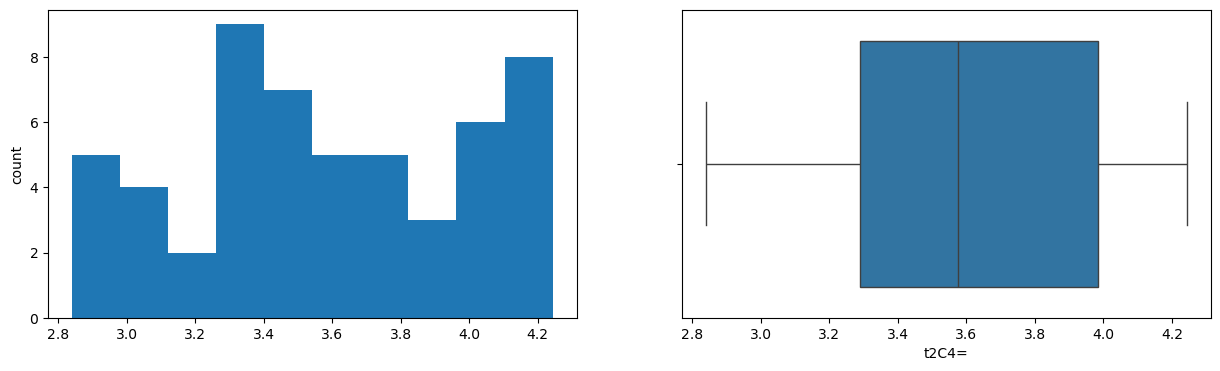

1C4=
Skew : 0.03


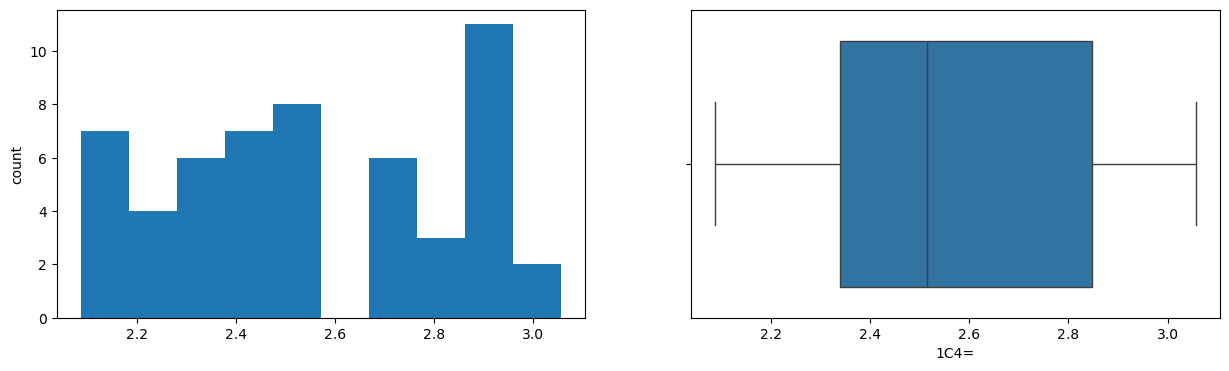

iC4=
Skew : -0.49


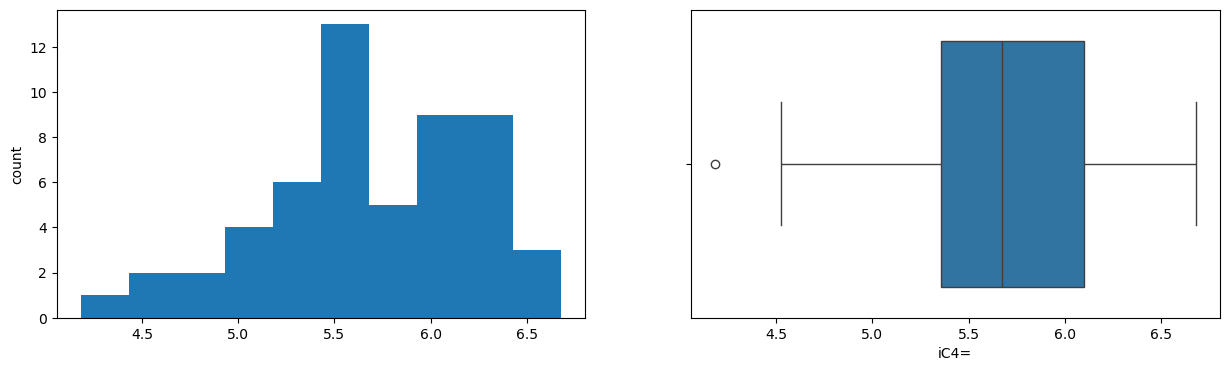

c2C4=
Skew : -0.23


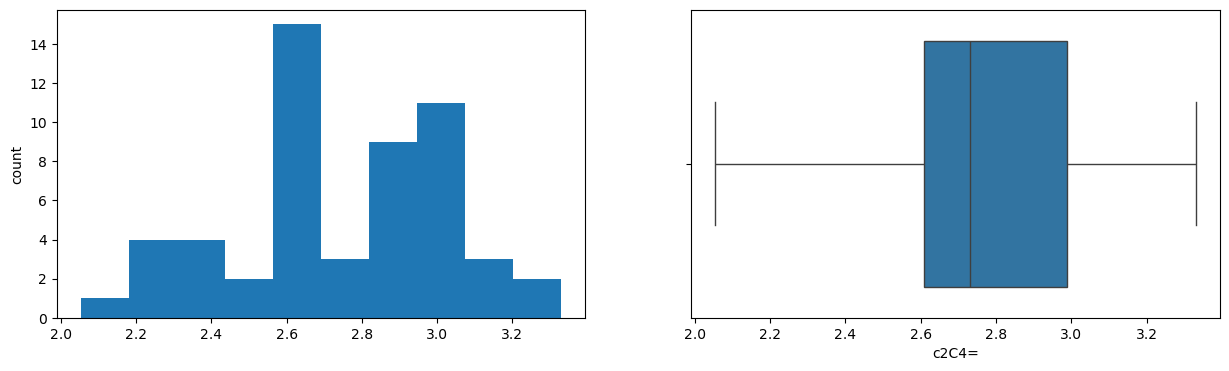

1,3-BD
Skew : 0.47


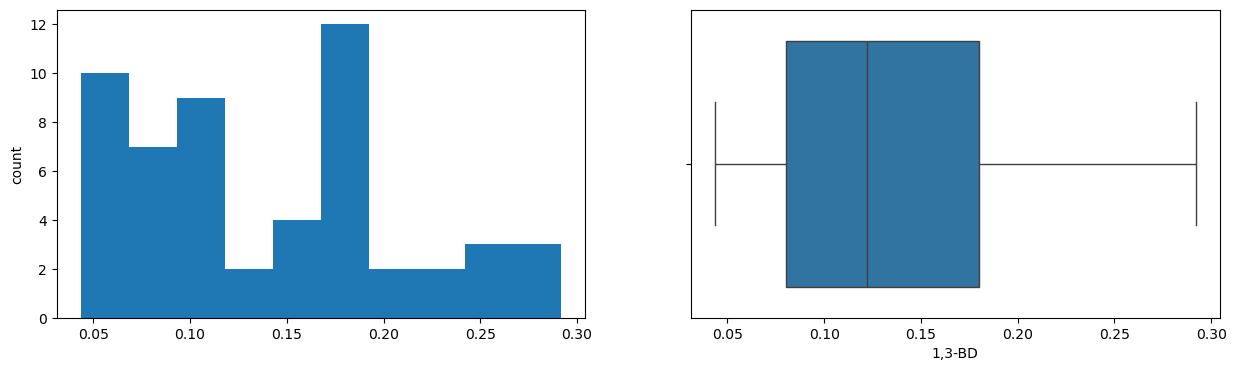

Total Gas
Skew : 0.4


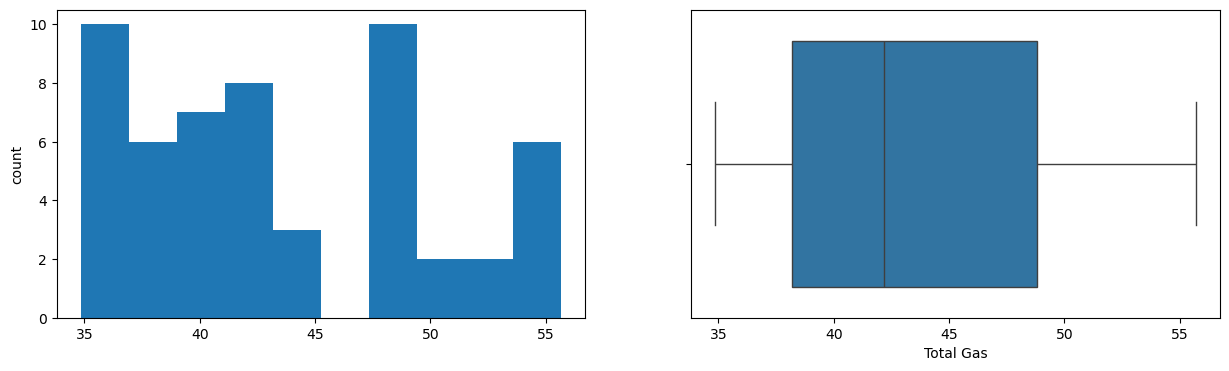

Gasoline
Skew : -0.49


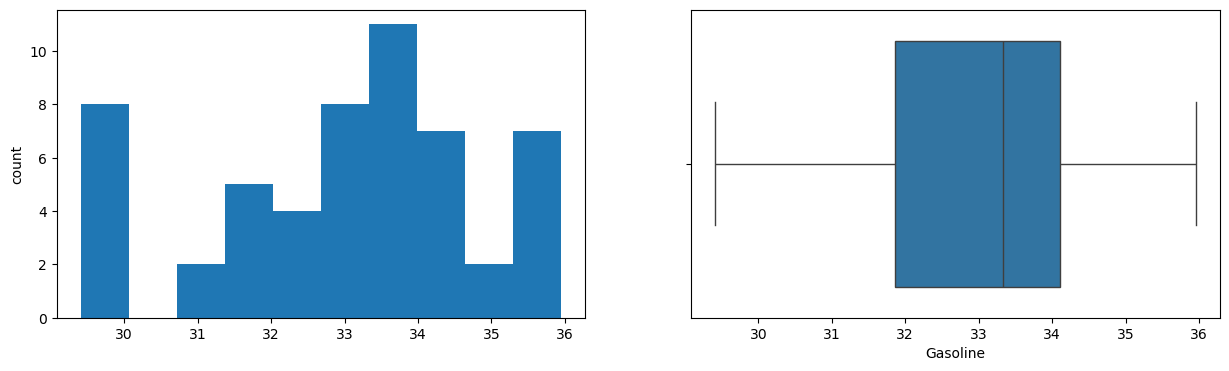

LCO
Skew : -0.27


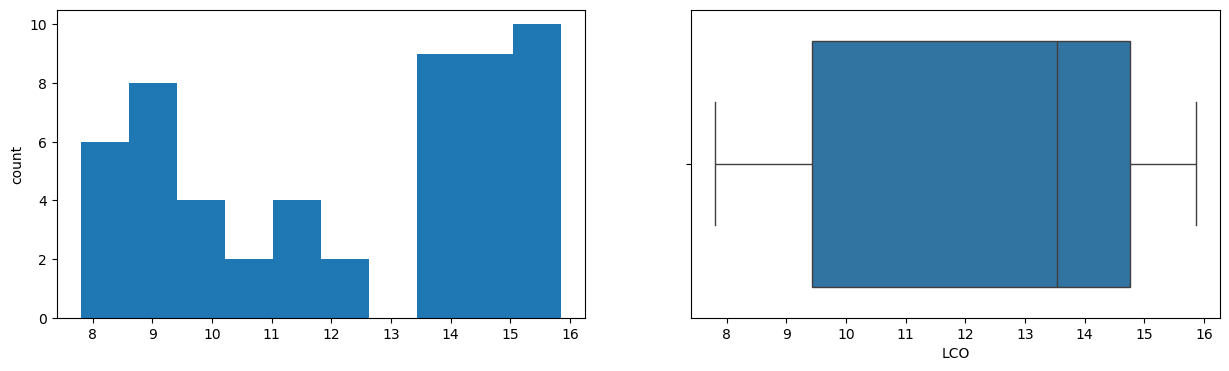

HCO
Skew : 0.43


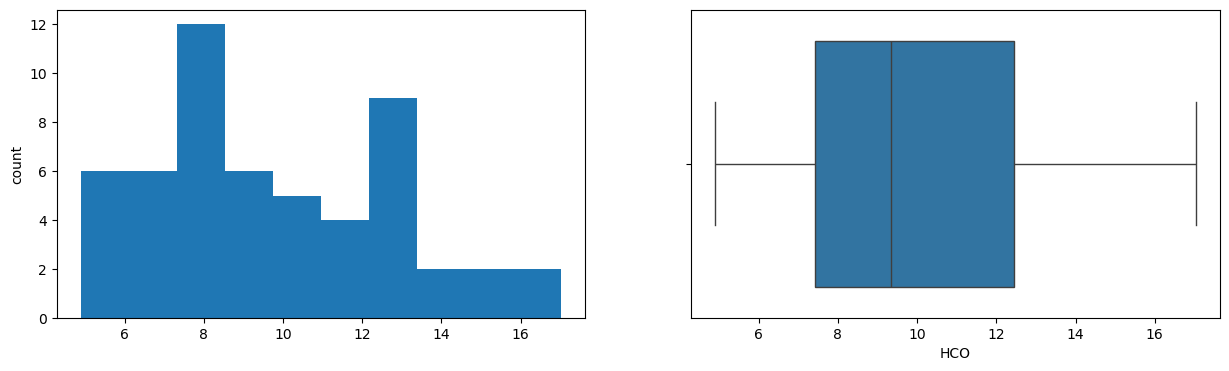

Coke
Skew : 0.32


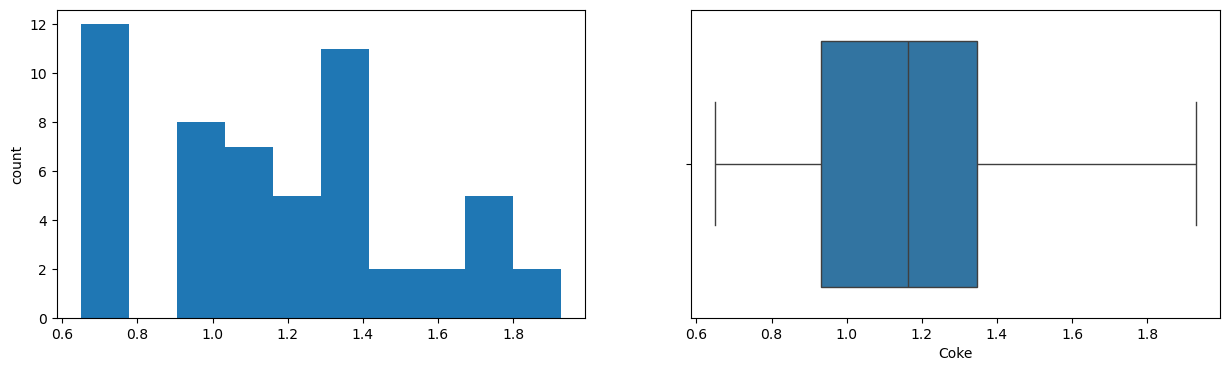

H2-C2 (dry gas)
Skew : 1.02


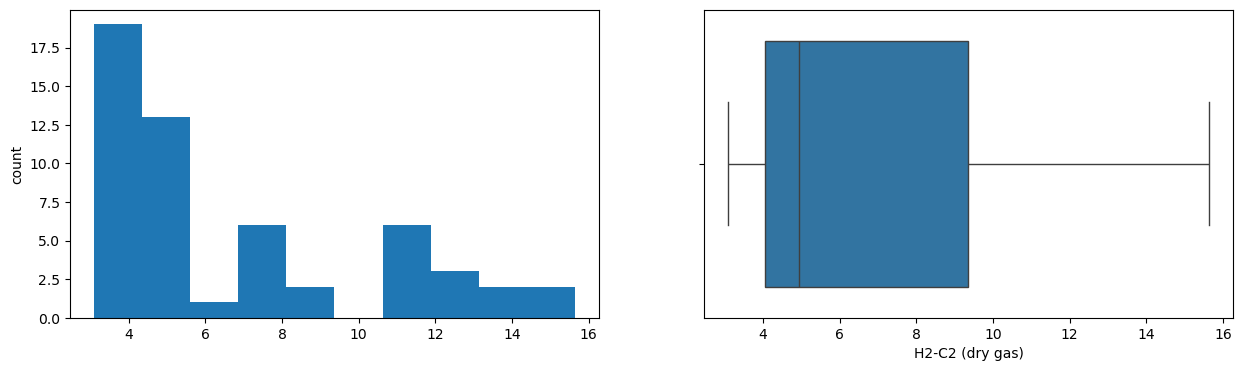

C3-C4 (LPG)
Skew : 0.14


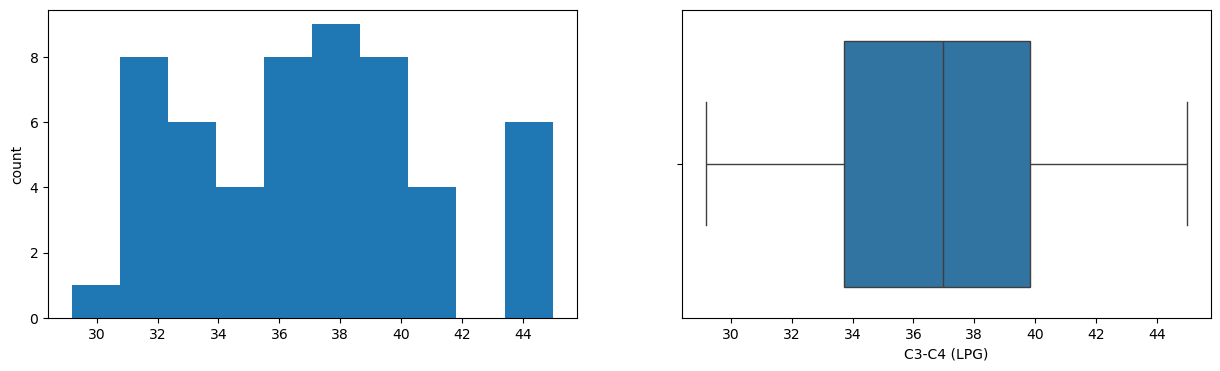

C2=-C4= (Light olefins)
Skew : 0.31


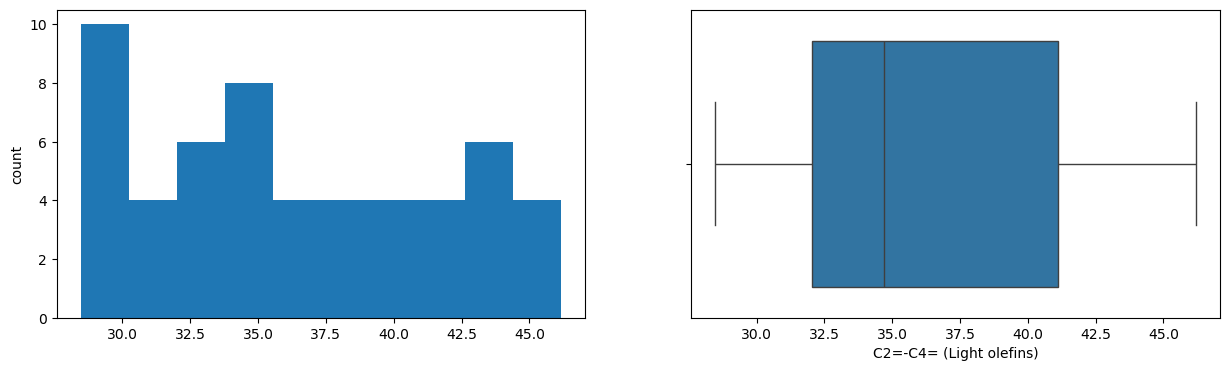

C3=+C4=
Skew : 0.17


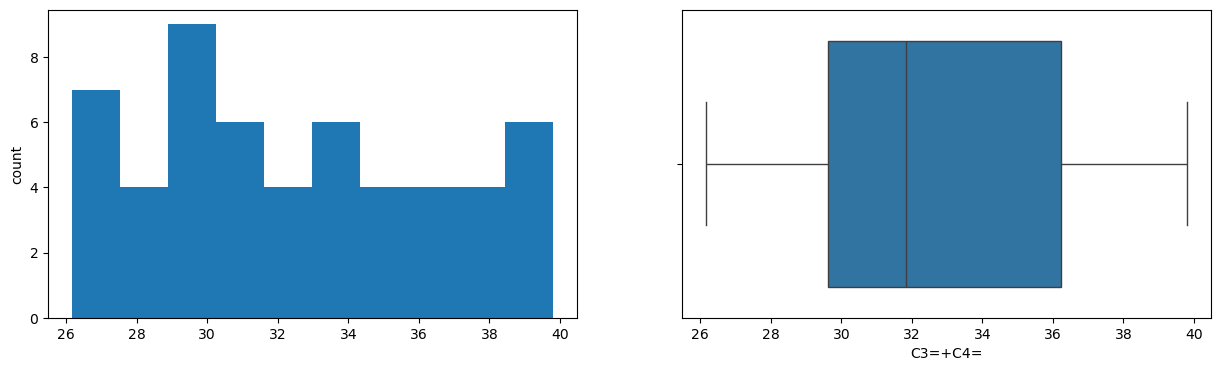

C4= (Butenes)
Skew : -0.02


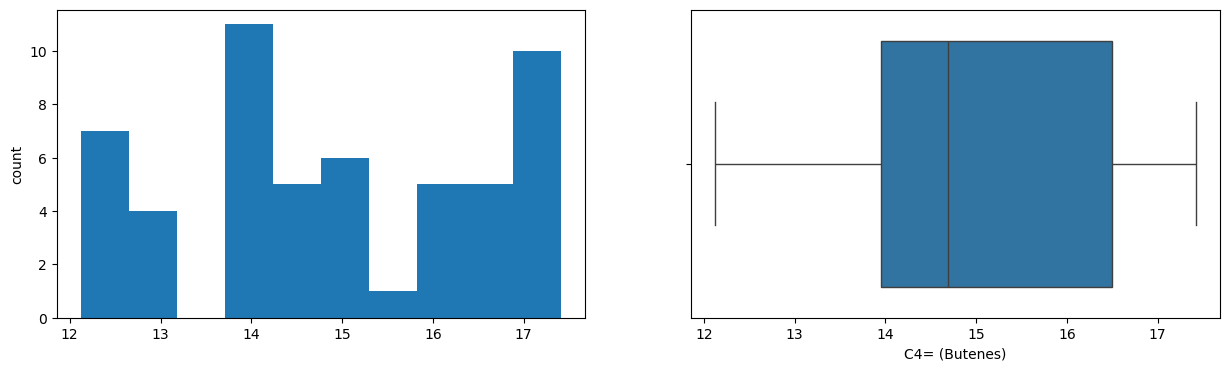

C2=/C2
Skew : 0.01


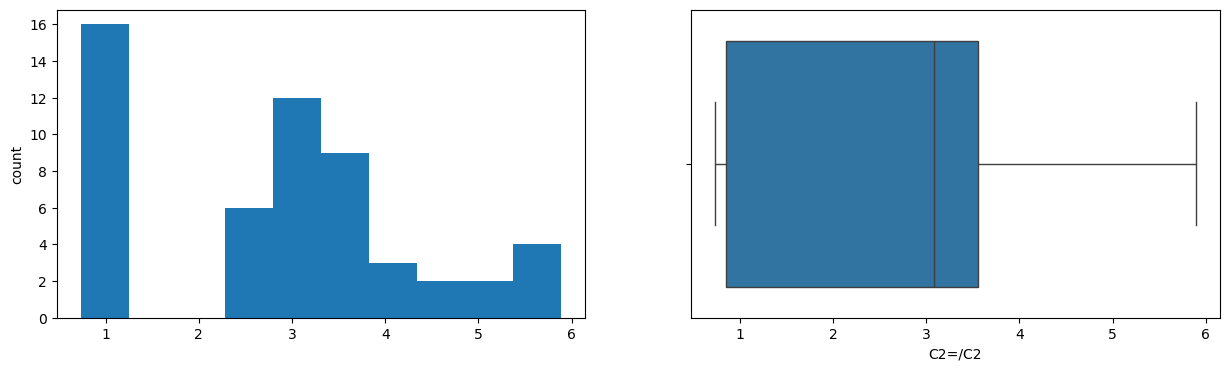

C3=/C3
Skew : -0.41


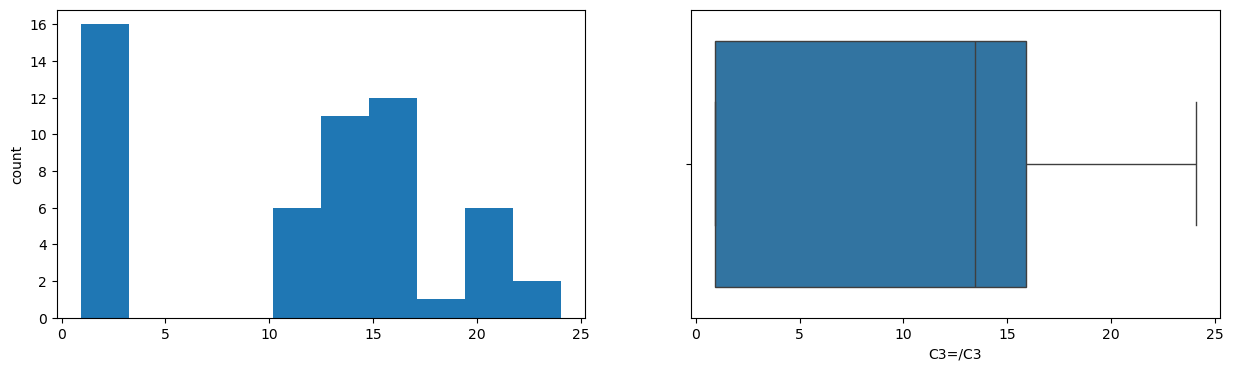

C4=/C4
Skew : 1.05


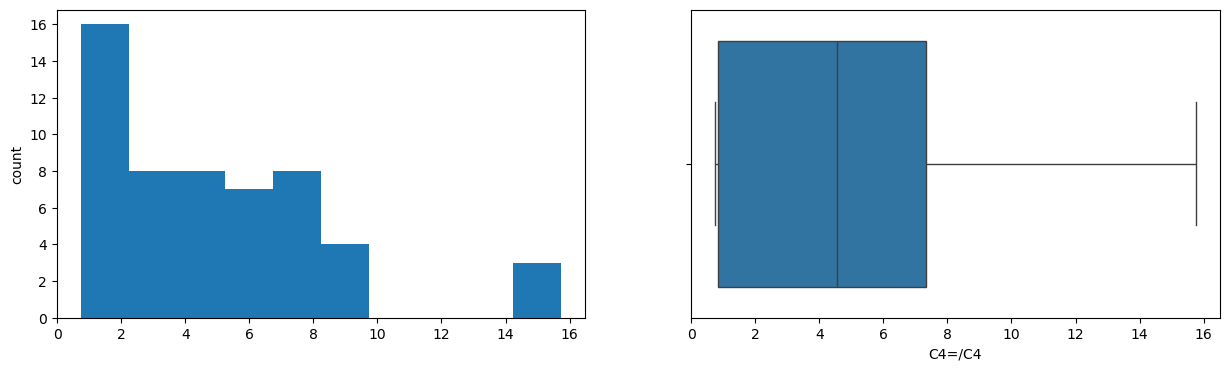

iC4=/C4=
Skew : -0.42


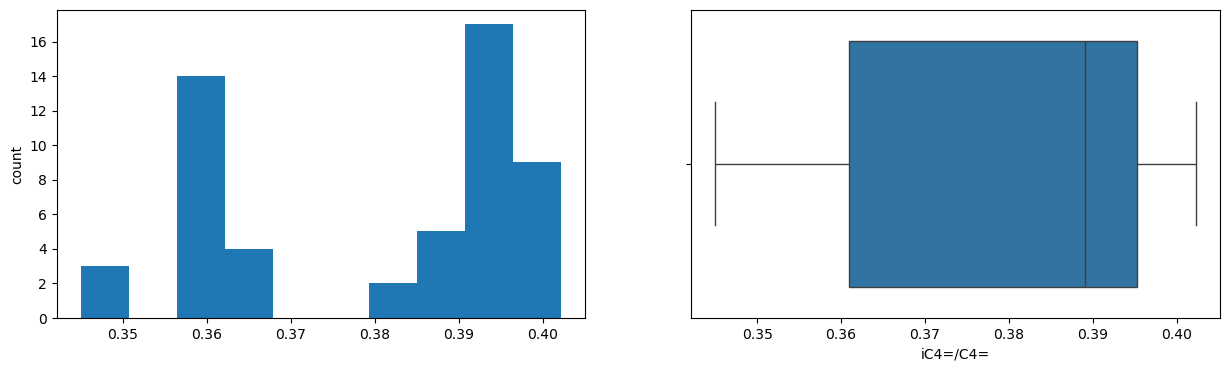

iC4=/iC4
Skew : 2.01


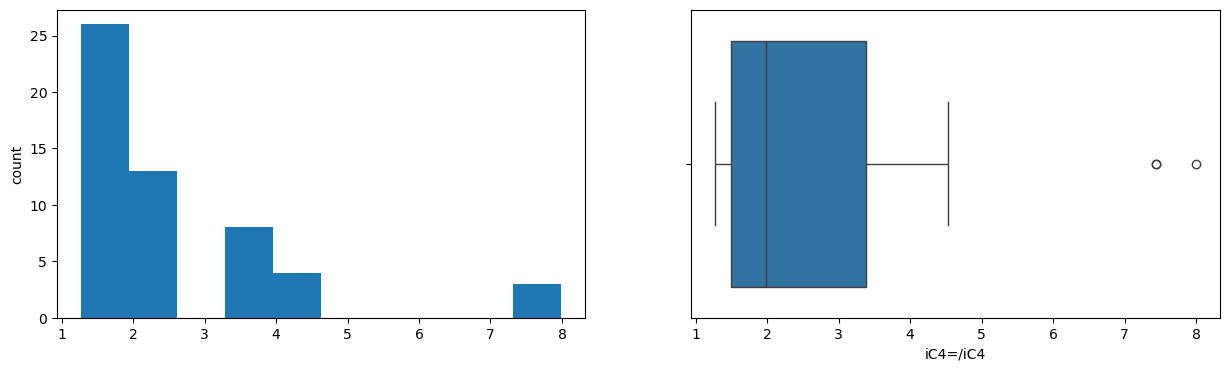

In [14]:
#plotting the data
for col in data:
    print(col)
    print('Skew :', round(data[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    data[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.show()

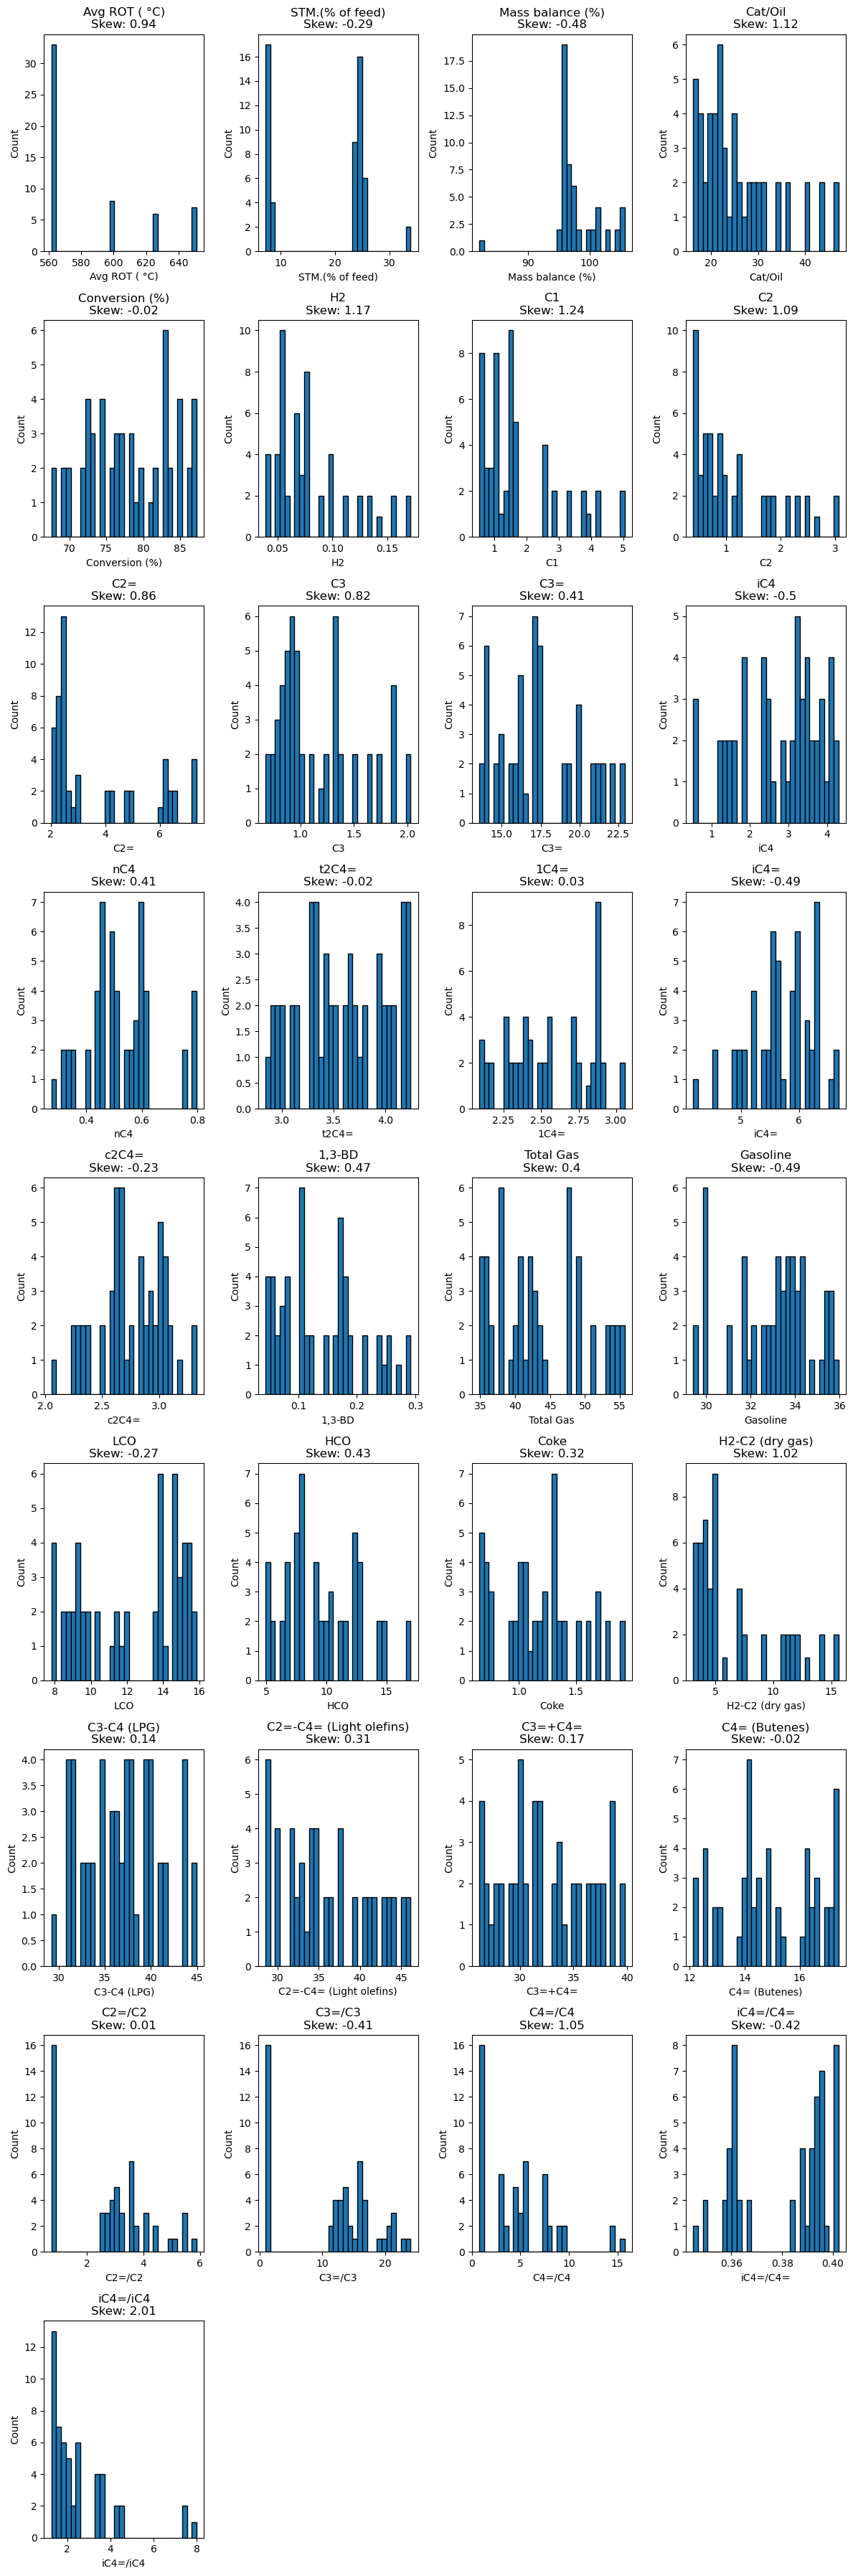

In [15]:
# Histograms
# Number of histograms per row
n_cols = 4
n_features = len(data.columns)
n_rows = math.ceil(n_features / n_cols)

# Set up the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()  # Flatten in case we have multiple rows

# Plot each histogram
for i, col in enumerate(data.columns):
    axes[i].hist(data[col], bins=30, edgecolor='black')
    axes[i].set_title(f'{col}\nSkew: {round(data[col].skew(), 2)}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save
plt.tight_layout()
plt.savefig("all_histograms_subplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Columns we do NOT scale
id_cols = ['Catalyst', 'RUN No.', 'Feed']

# 1. Identify numeric feature columns to plot
features = df.columns[~df.columns.isin(id_cols)]
numeric_features = df[features].select_dtypes(include=[np.number]).columns

# 2. Fit scaler on numeric columns
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[numeric_features])

# 3. Build a scaled dataframe for just the numeric features
df_scaled_numeric = pd.DataFrame(
    scaled_array,
    columns=numeric_features,
    index=df.index
)

# 4. Reattach the non-scaled identifier columns
df_scaled = pd.concat([df[id_cols], df_scaled_numeric], axis=1)

# Optional sanity check
#print(df_scaled.head())


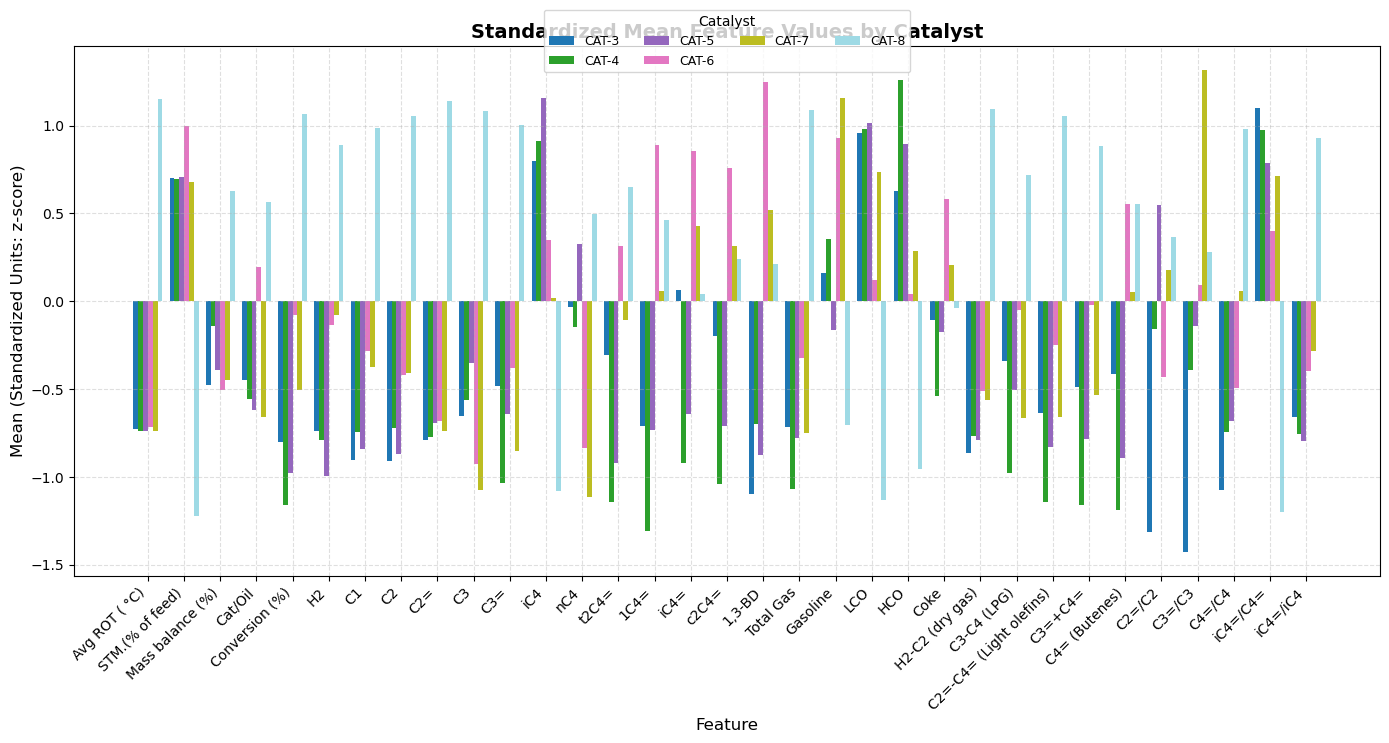

In [17]:
# --- Setup ---
id_cols = ['Catalyst', 'RUN No.', 'Feed']

# Features (numeric, scaled)
features = df_scaled.columns[~df_scaled.columns.isin(id_cols)]

# Unique catalyst labels
catalyst_levels = df_scaled['Catalyst'].unique()

# Colormap with enough distinct colors
cmap = plt.cm.get_cmap('tab20', len(catalyst_levels))
catalyst_colors = {cat: cmap(i) for i, cat in enumerate(catalyst_levels)}

# Geometry
num_features = len(features)
num_cats = len(catalyst_levels)

bar_width = 0.8 / num_cats
x_base = np.arange(num_features)

plt.figure(figsize=(14, 8))

legend_handles = []
legend_labels = []

# --- Plot loop ---
for j, cat in enumerate(catalyst_levels):
    subset = df_scaled[df_scaled['Catalyst'] == cat]
    means_for_cat = [subset[feature].mean() for feature in features]

    x_positions = x_base + j * bar_width

    bars = plt.bar(
        x_positions,
        means_for_cat,
        width=bar_width,
        color=catalyst_colors.get(cat, 'gray'),
        label=str(cat)
    )

    legend_handles.append(bars)
    legend_labels.append(str(cat))

# --- Cosmetics ---
plt.title('Standardized Mean Feature Values by Catalyst', fontsize=14, weight='bold')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Mean (Standardized Units: z-score)', fontsize=12)

# Center ticks under bar clusters
cluster_centers = x_base + (num_cats / 2 - 0.5) * bar_width
plt.xticks(cluster_centers, features, rotation=45, ha='right')

plt.grid(True, linestyle='--', alpha=0.4)

# Legend on top
plt.legend(
    legend_handles,
    legend_labels,
    title='Catalyst',
    title_fontsize=10,
    fontsize=9,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.08),
    ncol=4
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("scaled_singleplot_by_catalyst.png", dpi=300, bbox_inches="tight")
plt.show()

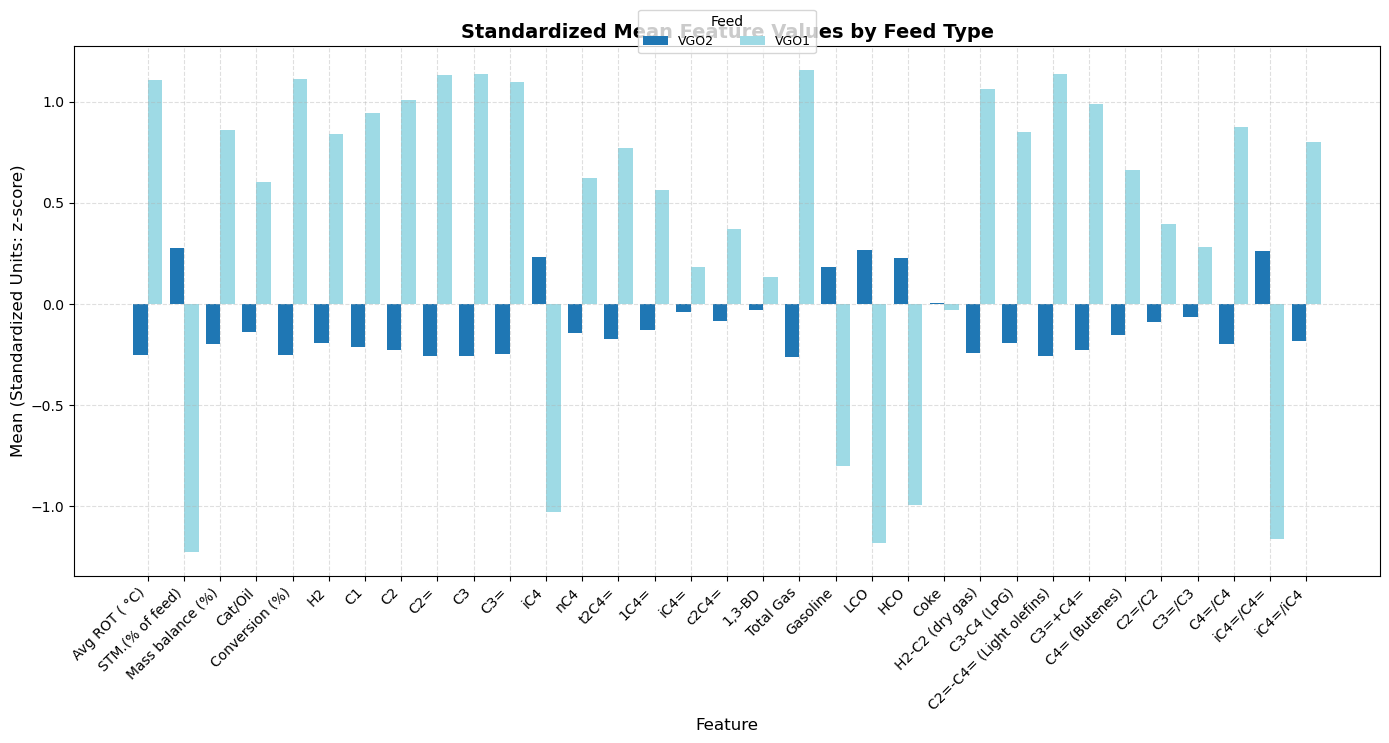

In [18]:
# --- Setup ---
id_cols = ['Catalyst', 'RUN No.', 'Feed']

# Features to plot (numeric, scaled)
features = df_scaled.columns[~df_scaled.columns.isin(id_cols)]

# Unique feed types (you can reorder this list manually if you want a certain order)
feed_types = df_scaled['Feed'].unique()

# Colormap with enough distinct colors
cmap = plt.cm.get_cmap('tab20', len(feed_types))
feed_colors = {feed: cmap(i) for i, feed in enumerate(feed_types)}

# Geometry
num_features = len(features)
num_feeds = len(feed_types)

bar_width = 0.8 / num_feeds          # cluster width ~0.8 total
x_base = np.arange(num_features)     # one x-position per feature

plt.figure(figsize=(14, 8))

legend_handles = []
legend_labels = []

# --- Plot loop: one bar per (feed, feature) ---
for j, feed in enumerate(feed_types):
    # mean of each feature for this feed
    subset = df_scaled[df_scaled['Feed'] == feed]
    means_for_feed = [subset[feature].mean() for feature in features]

    # shift each feed's bars within the cluster
    x_positions = x_base + j * bar_width

    bars = plt.bar(
        x_positions,
        means_for_feed,
        width=bar_width,
        color=feed_colors.get(feed, 'gray'),
        label=str(feed)
    )

    legend_handles.append(bars)
    legend_labels.append(str(feed))

# --- Axes / cosmetics ---
plt.title('Standardized Mean Feature Values by Feed Type', fontsize=14, weight='bold')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Mean (Standardized Units: z-score)', fontsize=12)

# Center tick labels under each cluster
cluster_centers = x_base + (num_feeds / 2 - 0.5) * bar_width
plt.xticks(cluster_centers, features, rotation=45, ha='right')

plt.grid(True, linestyle='--', alpha=0.4)

# Legend on top, multi-column if needed
plt.legend(
    legend_handles,
    legend_labels,
    title='Feed',
    title_fontsize=10,
    fontsize=9,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.08),
    ncol=4  # tweak if you have many feeds
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("scaled_singleplot_by_feed.png", dpi=300, bbox_inches="tight")
plt.show()

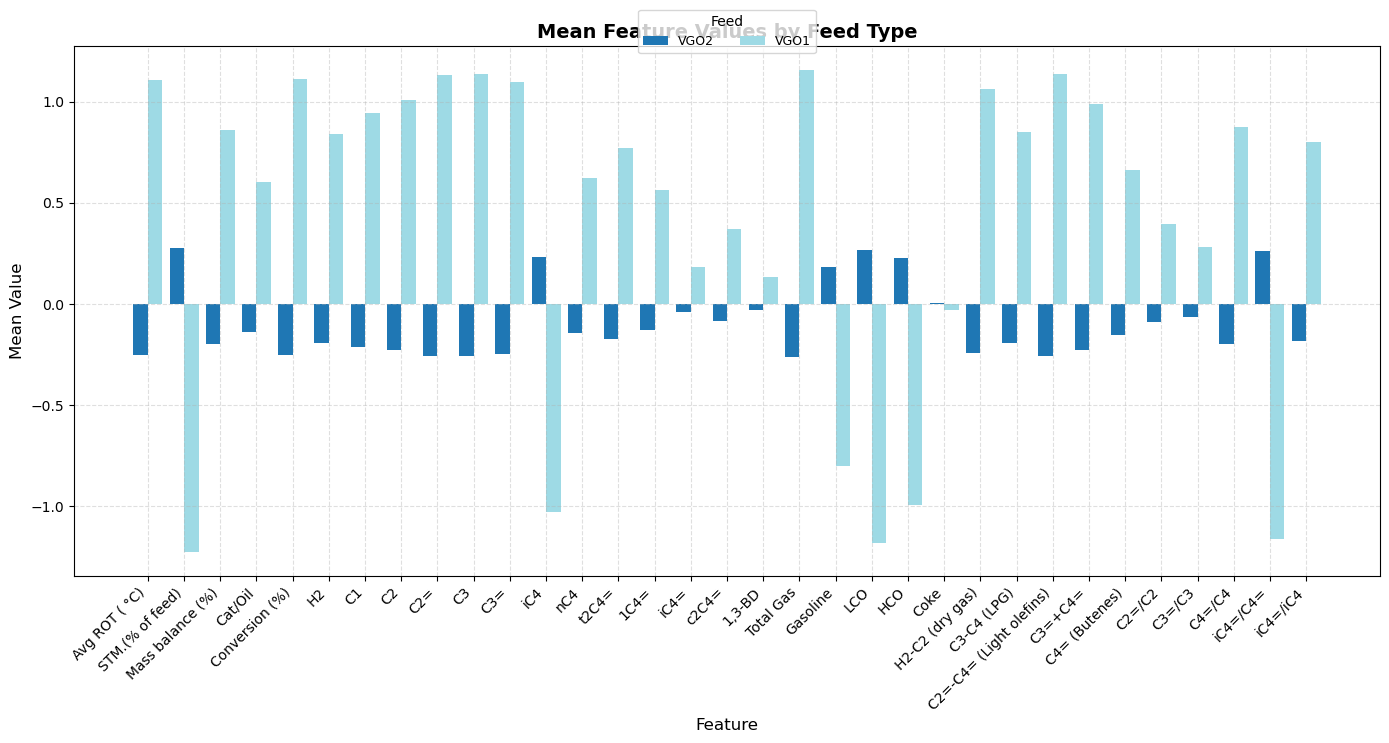

In [19]:
# Features to plot (exclude non-numeric/grouping columns)
features = df_scaled.columns[~df_scaled.columns.isin(['Catalyst', 'RUN No.', 'Feed'])]

# Unique feed types
feed_types = df_scaled['Feed'].unique()

# Build a color map with enough colors for ALL feed types
cmap = plt.cm.get_cmap('tab20', len(feed_types))  # 'tab20' gives up to 20 distinct colors
feed_colors = {feed: cmap(i) for i, feed in enumerate(feed_types)}

# Set bar geometry
num_features = len(features)
num_feeds = len(feed_types)

bar_width = 0.8 / num_feeds  # make the total width per feature about 0.8
x_base = np.arange(num_features)  # one position per feature

plt.figure(figsize=(14, 8))

legend_handles = []
legend_labels = []

# Loop over feeds (each feed gets a cluster across all features)
for j, feed in enumerate(feed_types):
    means_for_feed = []
    for feature in features:
        subset = df_scaled[df_scaled['Feed'] == feed]
        means_for_feed.append(subset[feature].mean())

    # X positions for this feed: shift by j * bar_width
    x_positions = x_base + j * bar_width

    bars = plt.bar(
        x_positions,
        means_for_feed,
        width=bar_width,
        color=feed_colors.get(feed, 'gray'),
        label=str(feed)  # we'll use this for the legend
    )

    # Only add to legend once
    legend_handles.append(bars)
    legend_labels.append(str(feed))

# Axis cosmetics
plt.title('Mean Feature Values by Feed Type', fontsize=14, weight='bold')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Mean Value', fontsize=12)

# Put x-ticks in the middle of each cluster
cluster_centers = x_base + (num_feeds / 2 - 0.5) * bar_width
plt.xticks(cluster_centers, features, rotation=45, ha='right')

plt.grid(True, linestyle='--', alpha=0.4)

# Legend outside/above for clarity
plt.legend(
    legend_handles,
    legend_labels,
    title='Feed',
    title_fontsize=10,
    fontsize=9,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.08),
    ncol=4  # adjust if you have many feed types
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("comparison_of_yields_by_feed.png", dpi=300, bbox_inches="tight")
plt.show()

# Removing outliers

In [20]:
#becuase my data is in different scales, it is better to scale using standard scaler.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
#convert to dataframe
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

['Avg ROT ( °C)', 'STM.(% of feed)', 'Mass balance (%)', 'Cat/Oil', 'Conversion (%)', 'H2', 'C1', 'C2', 'C2=', 'C3', 'C3=', 'iC4', 'nC4', 't2C4=', '1C4=', 'iC4=', 'c2C4=', '1,3-BD', 'Total Gas', 'Gasoline', 'LCO', 'HCO', 'Coke', 'H2-C2 (dry gas)', 'C3-C4 (LPG)', 'C2=-C4= (Light olefins)', 'C3=+C4=', 'C4= (Butenes)', 'C2=/C2', 'C3=/C3', 'C4=/C4', 'iC4=/C4=', 'iC4=/iC4']


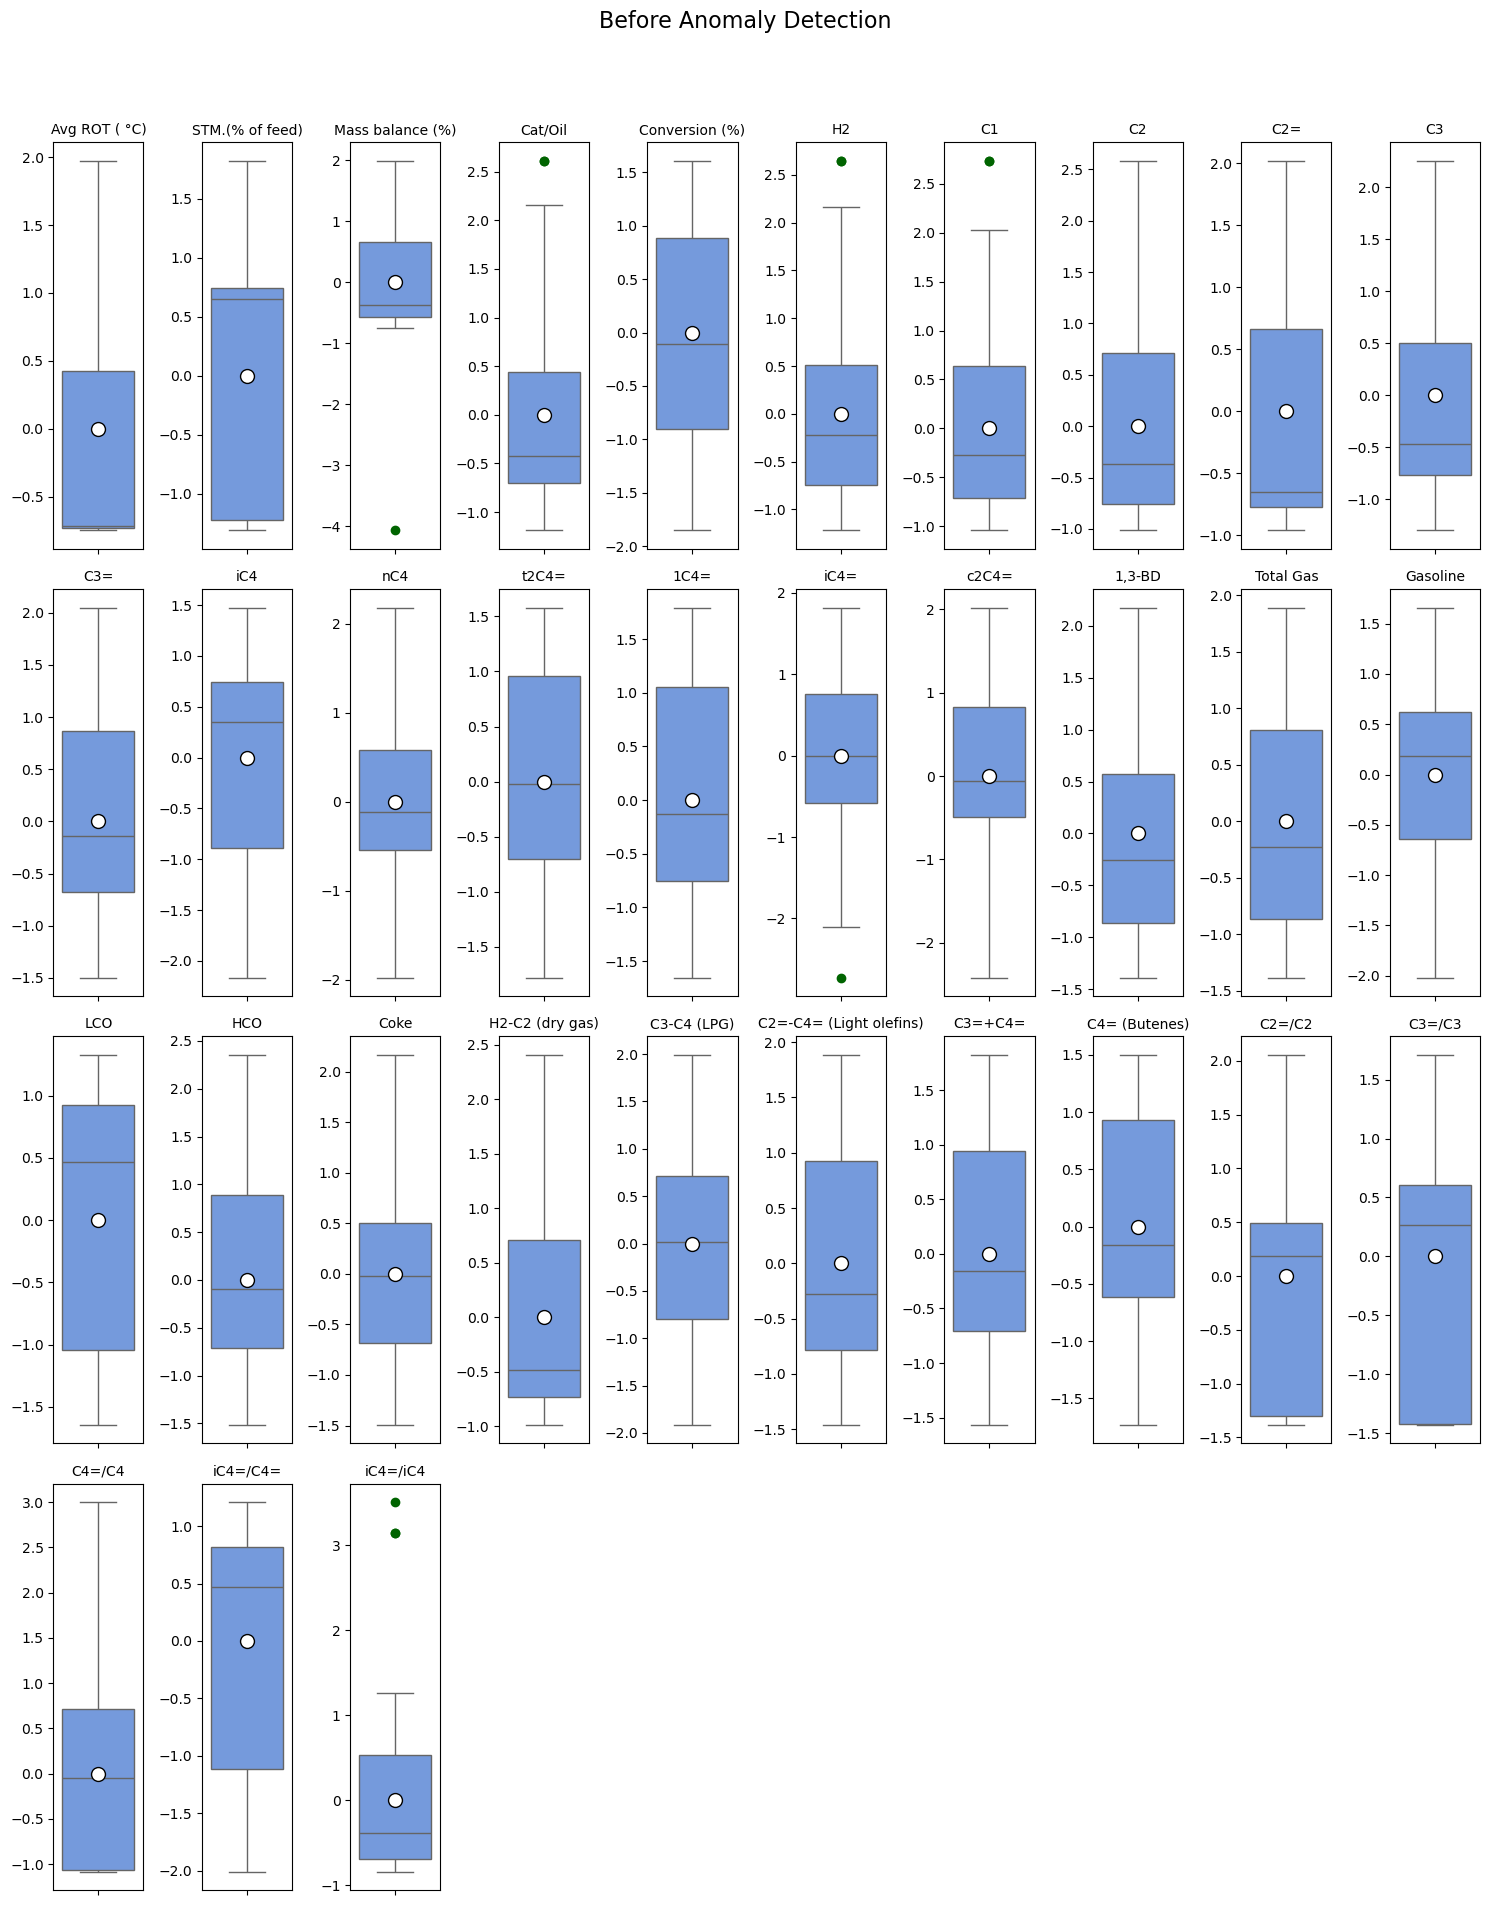

In [21]:
#Check the new columns which shows the anomaly
inputs = list(scaled_data.columns)
# Before anomaly detection
print(inputs)
make_combined_boxplot(scaled_data, inputs, title="Before Anomaly Detection", filename="boxplots_before.png")


In [22]:
# Create a copy of the dataframe so that the original remanins untouched and extract the required curves
anomaly_df = scaled_data.copy()

# Drop any null values. This method drops the entire row of data if one of the cells in that row
# contains a null (NaN) value
anomaly_df.dropna(inplace=True)

# Define the inputs for the anomaly detection
anomaly_inputs = ['Avg ROT ( °C)', 'STM.(% of feed)', 'Mass balance (%)', 'Cat/Oil', 'Conversion (%)', 'H2', 'C1', 'C2', 'C2=', 'C3', 'C3=', 'iC4', 'nC4', 't2C4=', '1C4=', 'iC4=', 'c2C4=', '1,3-BD', 'Total Gas', 'Gasoline', 'LCO', 'HCO', 'Coke', 'H2-C2 (dry gas)', 'C3-C4 (LPG)', 'C2=-C4= (Light olefins)', 'C3=+C4=', 'C4= (Butenes)', 'C2=/C2', 'C3=/C3', 'C4=/C4', 'iC4=/C4=', 'iC4=/iC4']

# Setup the models, each will have a contamination (outlier) fraction of 0.1
# The random_state is set to allow repeatable results for the Isolation Forest. This can be omitted if required.
model_IF = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1), max_features=1.0, random_state=42)
model_SVM = OneClassSVM(nu=0.10)
model_lof = LocalOutlierFactor(contamination=0.1, novelty=True)

models = {'IF':model_IF,
         'SVM': model_SVM,
         'LOF': model_lof}

for name, model in models.items():
    print(f'Fitting: {name}')
    model.fit(anomaly_df[anomaly_inputs])
    anomaly_df[f'{name}_anomaly_scores'] = model.decision_function(anomaly_df[anomaly_inputs])
    anomaly_df[f'{name}_anomaly'] = model.predict(anomaly_df[anomaly_inputs])

# Identify common anomalies across all models (where each model flags the row as an anomaly)
# Common anomaly will be when all models predict -1 (anomaly)
anomaly_df['common_anomaly'] = (anomaly_df[['IF_anomaly', 'SVM_anomaly', 'LOF_anomaly']] == -1).all(axis=1)

print('Model Fitting Complete')
anomaly_df.head(5)

Fitting: IF
Fitting: SVM
Fitting: LOF
Model Fitting Complete


Avg ROT ( °C)  STM.(% of feed)  Mass balance (%)   Cat/Oil  Conversion (%)  \
0      -0.731231         0.754407         -0.529209 -0.797664       -1.061656   
1      -0.749481         0.735359         -0.267748 -0.492351       -0.912926   
2      -0.706897         0.617399         -0.633878 -0.062905       -0.435190   
3      -0.740356         0.749621          0.451927 -1.041338       -1.853538   
4      -0.730318         0.693404         -0.385057 -0.579836       -1.391988   

         H2        C1        C2       C2=        C3  ...    C4=/C4  iC4=/C4=  \
0 -0.585772 -0.783836 -0.782416 -0.778734 -0.669189  ... -1.073269  1.208916   
1 -0.890006 -1.043254 -1.014660 -0.863178 -0.772277  ... -1.073506  1.203330   
2 -0.745247 -0.879391 -0.927921 -0.719549 -0.519226  ... -1.074995  0.885779   
3 -0.743923 -0.656143 -0.614942 -0.801723 -0.663127  ... -0.361134  1.117724   
4 -0.712815 -0.640118 -0.596672 -0.776711 -0.616662  ... -0.406670  1.117724   

   iC4=/iC4  IF_anomaly_scores  IF_anomaly  SVM_anomaly_scores  SVM_anomaly  \
0 -0.618458           0.126505           1            0.124358            1   
1 -0.620027           0.103216           1            0.081427            1   
2 -0.667230           0.118222           1            0.064321            1   
3 -0.696840           0.047468           1            0.000314            1   
4 -0.750581           0.071852           1            0.064838            1   

   LOF_anomaly_scores  LOF_anomaly  common_anomaly  
0            0.085202            1           False  
1            0.095948            1           False  
2            0.107804            1           False  
3            0.053527            1           False  
4            0.079995            1           False  

[5 rows x 40 columns]

In [23]:
(anomaly_df['common_anomaly'] == True).value_counts()

common_anomaly
False    53
True      1
Name: count, dtype: int64

In [24]:
print("data shape:", scaled_data.shape)
print("anomaly_df shape:", scaled_data.shape)

print("data rows:", len(scaled_data))
print("anomaly_df rows:", len(anomaly_df))

data shape: (54, 33)
anomaly_df shape: (54, 33)
data rows: 54
anomaly_df rows: 54


['Avg ROT ( °C)', 'STM.(% of feed)', 'Mass balance (%)', 'Cat/Oil', 'Conversion (%)', 'H2', 'C1', 'C2', 'C2=', 'C3', 'C3=', 'iC4', 'nC4', 't2C4=', '1C4=', 'iC4=', 'c2C4=', '1,3-BD', 'Total Gas', 'Gasoline', 'LCO', 'HCO', 'Coke', 'H2-C2 (dry gas)', 'C3-C4 (LPG)', 'C2=-C4= (Light olefins)', 'C3=+C4=', 'C4= (Butenes)', 'C2=/C2', 'C3=/C3', 'C4=/C4', 'iC4=/C4=', 'iC4=/iC4']


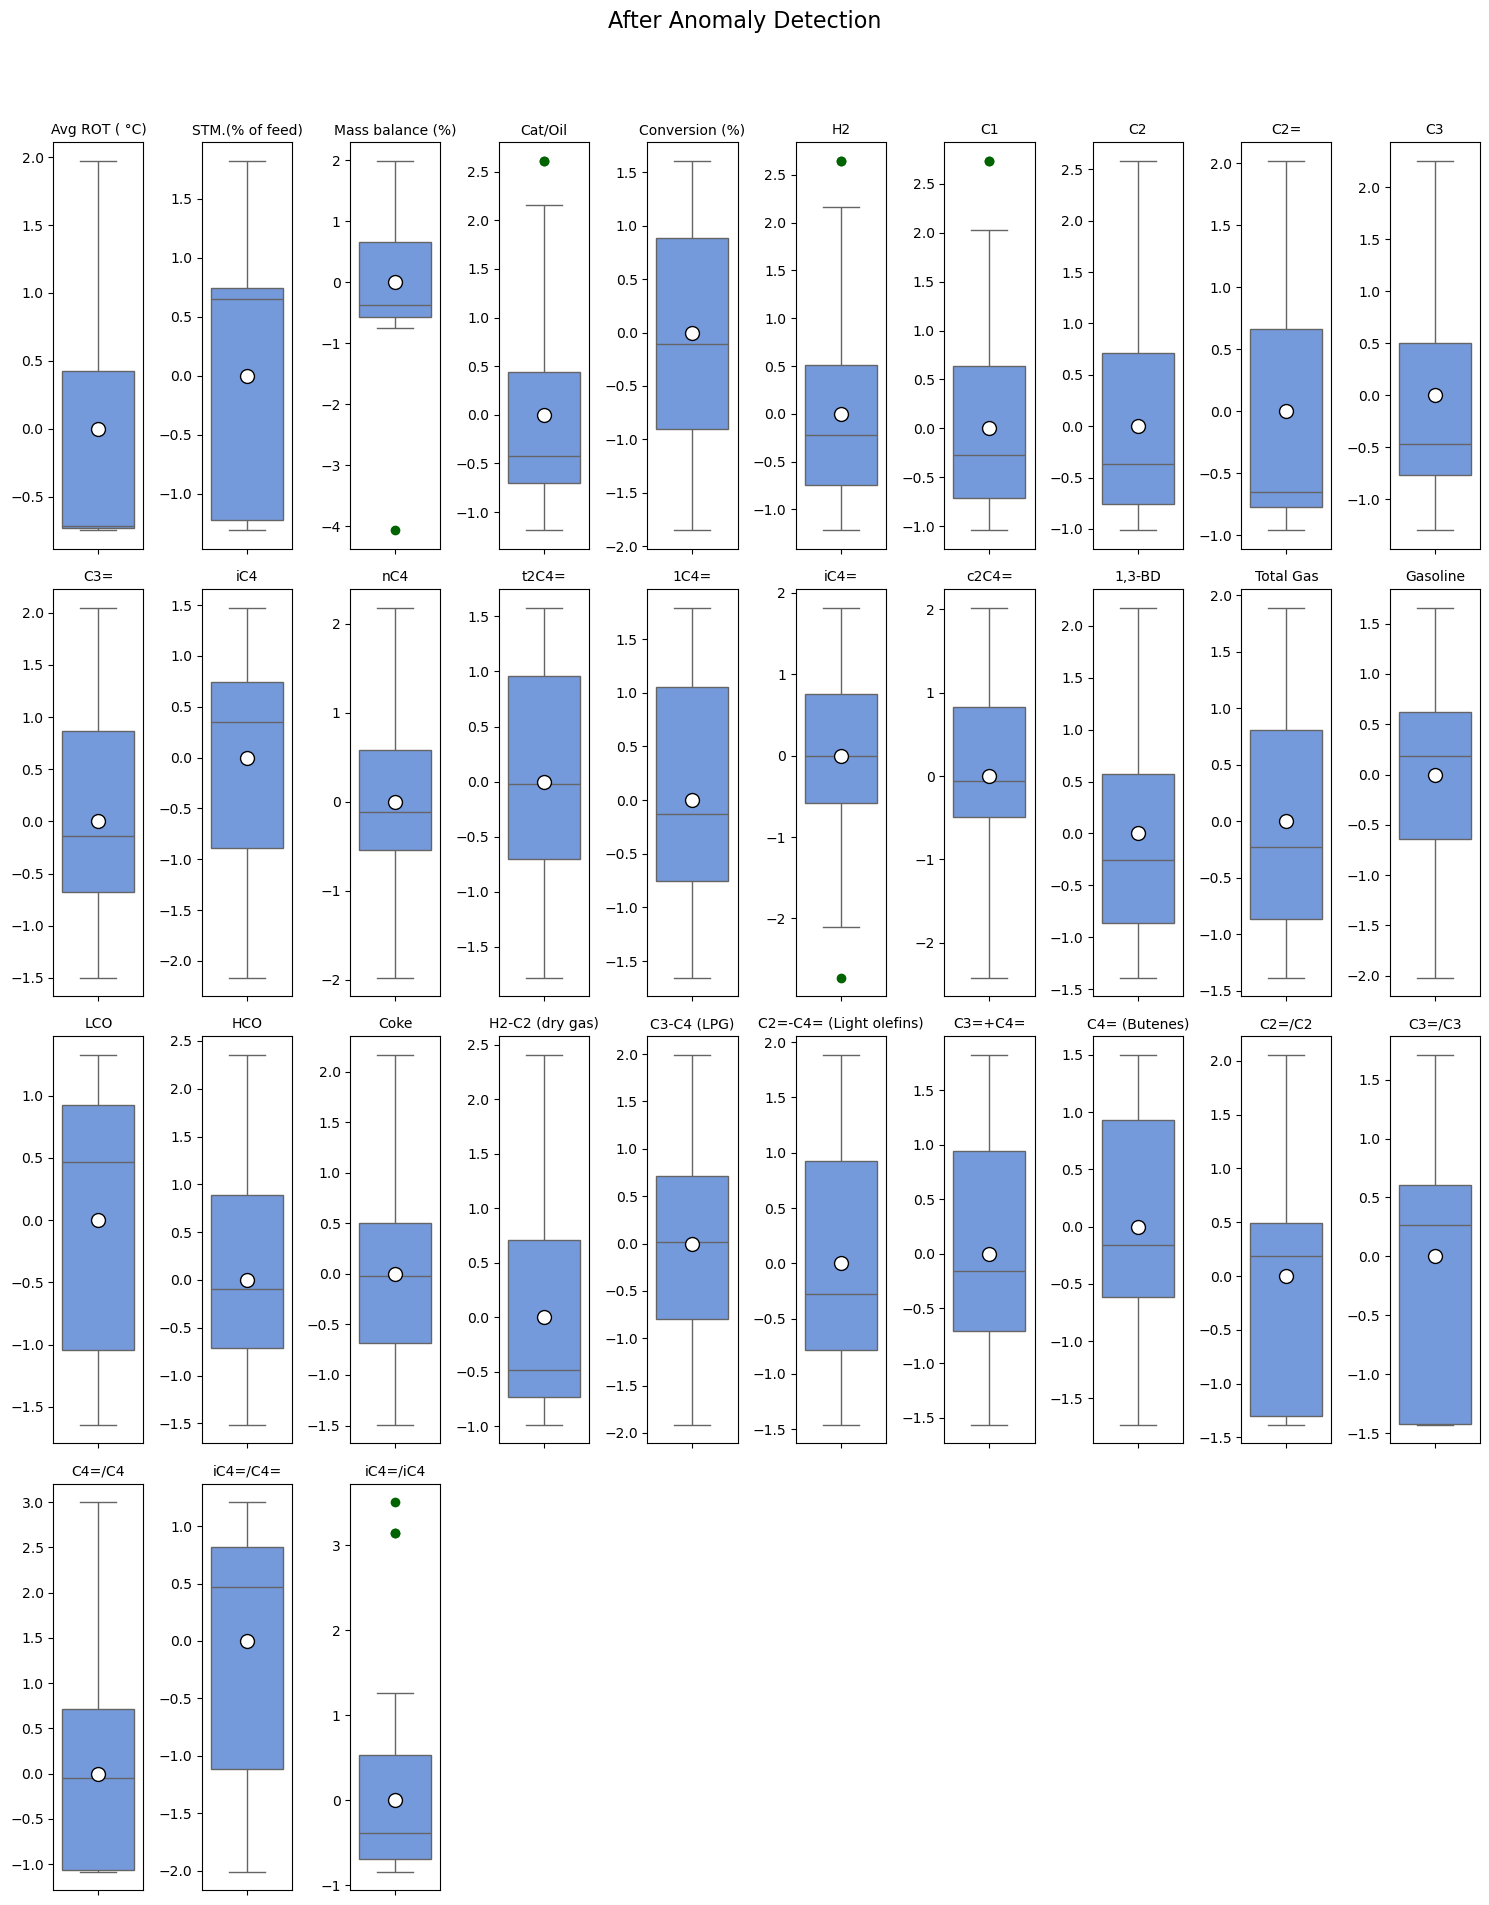

In [25]:
#Check the new columns which shows the anomaly
inputs = list(scaled_data.columns)
print(inputs)
# After anomaly detection
make_combined_boxplot(scaled_data, inputs, title="After Anomaly Detection", filename="boxplots_after.png")

In [26]:
data_filtered = scaled_data.loc[~anomaly_df['common_anomaly']]

In [27]:
# Create a copy that includes the Feed column, without altering data_filtered
if 'Feed' in data_filtered.columns:
    df_filtered = data_filtered.copy()
else:
    df_filtered = pd.concat([tags[['Feed']], data_filtered], axis=1)
#dropping null values
df_filtered = df_filtered.dropna()

VGO2     43
VGO1     10
Total    53
dtype: int64


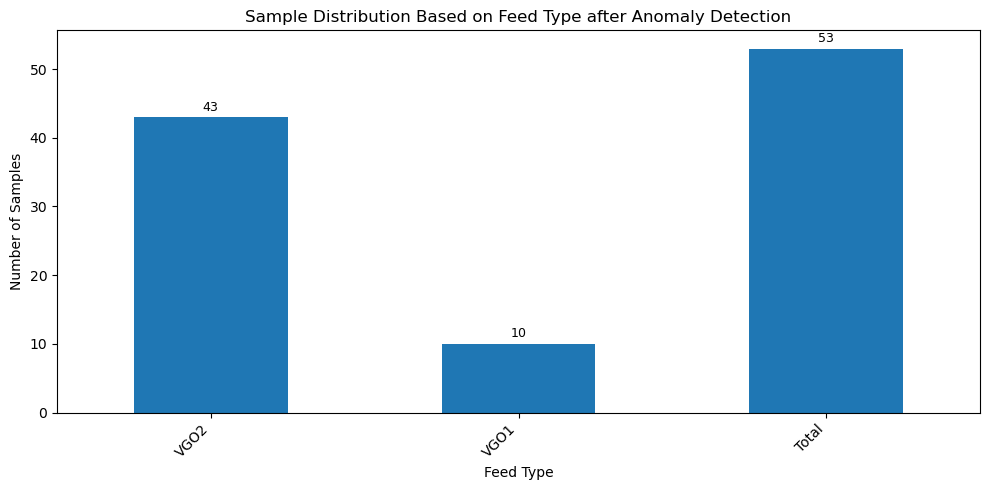

In [28]:
# --- Count samples per feed ---
feed_counts = df_filtered['Feed'].value_counts()

# --- Add final "Total" row ---
feed_counts_with_total = pd.concat([
    feed_counts,
    pd.Series({'Total': feed_counts.sum()})
])

print(feed_counts_with_total)

# --- Plot ---
plt.figure(figsize=(10, 5))
ax = feed_counts_with_total.plot(kind='bar')

plt.xlabel('Feed Type')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution Based on Feed Type after Anomaly Detection')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# --- Add numbers on top of bars ---
for i, value in enumerate(feed_counts_with_total):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

# Save figure
plt.savefig('Sample Distribution Based on Feed Type after Anomaly Detection.png', dpi=300, bbox_inches='tight')

plt.show()

In [29]:
# Create a copy that includes the Catalyst column, without altering data_filtered
if 'Catalyst' in data_filtered.columns:
    df_filtered = data_filtered.copy()
else:
    df_filtered = pd.concat([tags[['Catalyst']], data_filtered], axis=1)
#dropping null values
df_filtered = df_filtered.dropna()

CAT-8    21
CAT-5     8
CAT-6     8
CAT-3     6
CAT-4     6
CAT-7     4
Total    53
dtype: int64


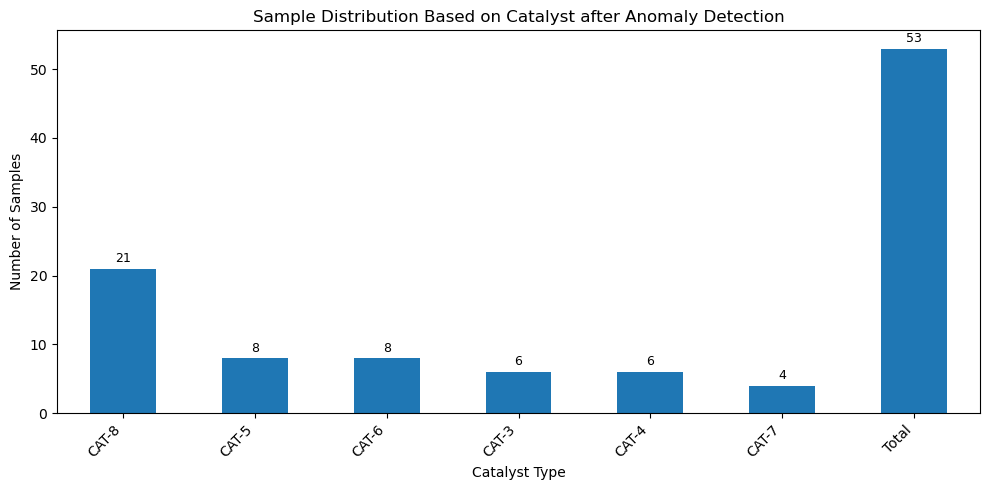

In [30]:
# --- Count samples per Catalyst ---
catalyst_counts = df_filtered['Catalyst'].value_counts()

# --- Add final "Total" row ---
catalyst_counts_with_total = pd.concat([
    catalyst_counts,
    pd.Series({'Total': catalyst_counts.sum()})
])

print(catalyst_counts_with_total)

# --- Plot ---
plt.figure(figsize=(10, 5))
ax = catalyst_counts_with_total.plot(kind='bar')

plt.xlabel('Catalyst Type')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution Based on Catalyst after Anomaly Detection')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# --- Add numbers on top of bars ---
for i, value in enumerate(catalyst_counts_with_total):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

# Save figure
plt.savefig('Sample Distribution Based on Catalyst after Anomaly Detection.png', dpi=300, bbox_inches='tight')

plt.show()


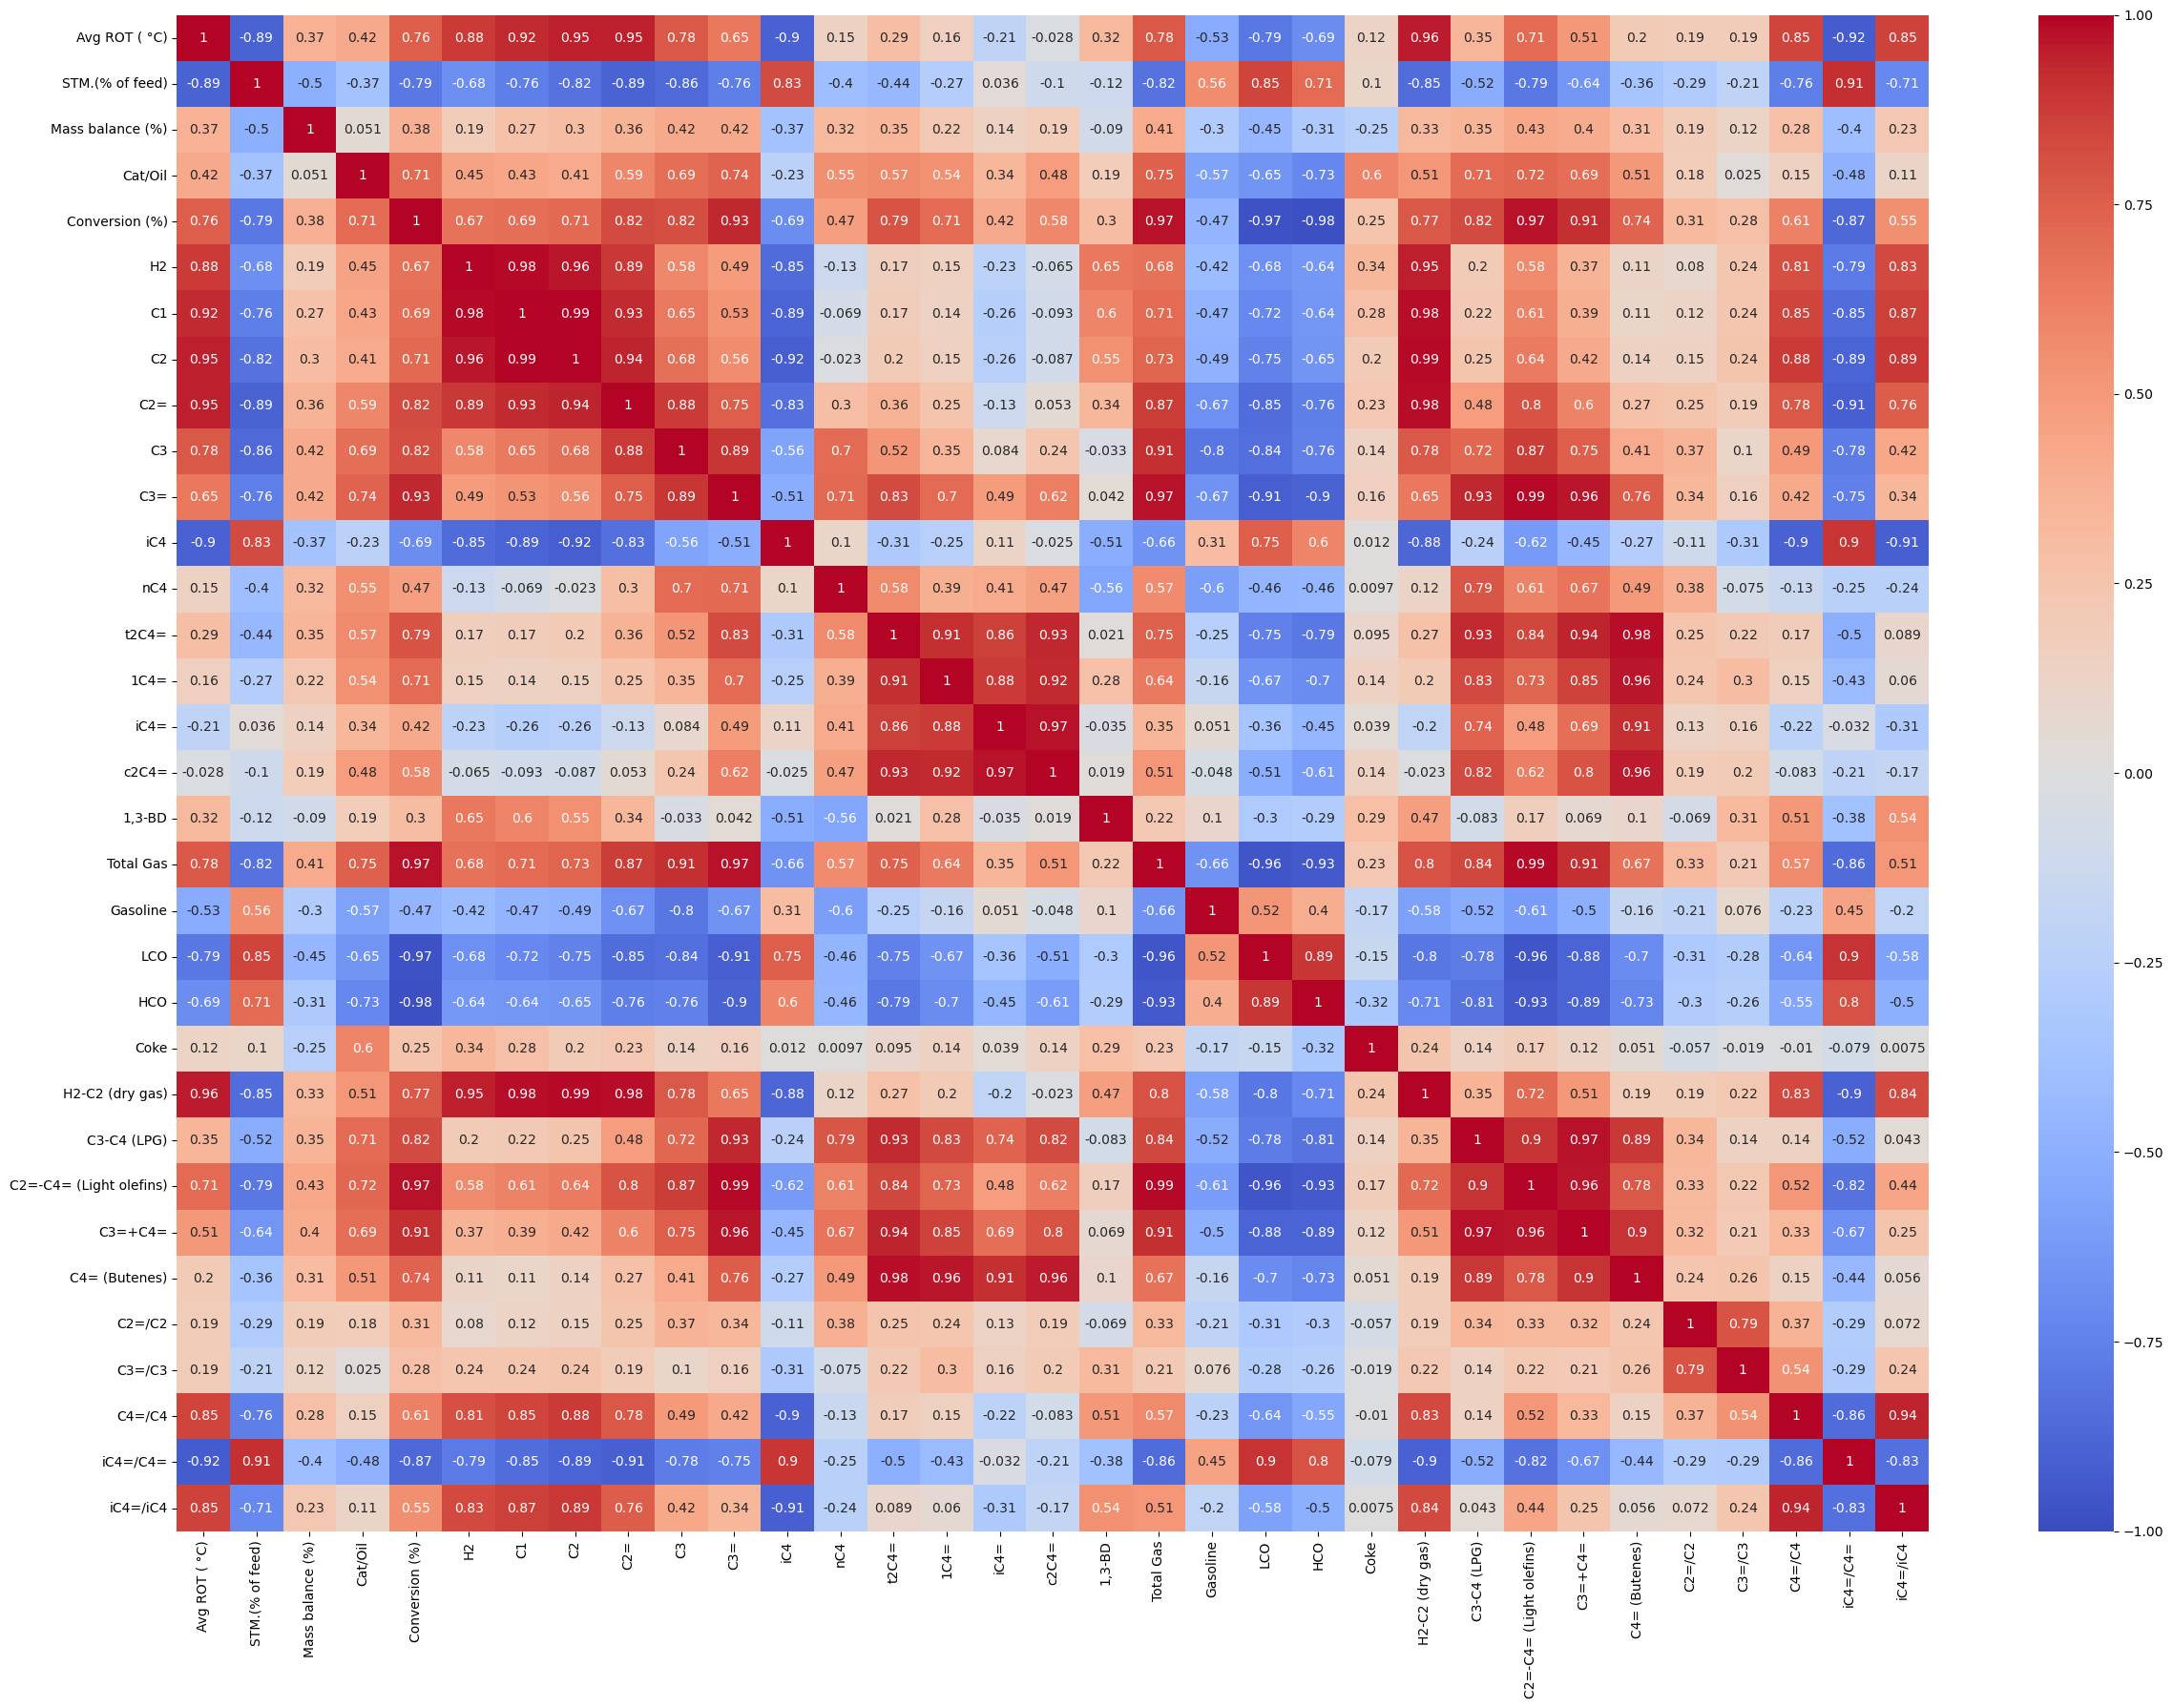

In [31]:
#correlation matrix
plt.figure(figsize=(25, 18))  # Adjust as needed
sns.heatmap(scaled_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300)  # Save before showing
plt.show()

# Defining the Functions for Storing and Plotting Results

In [32]:
# =========================================================
# === Reusable K-Fold plotting utilities (OOF-based) ===
# =========================================================

def _to_1d_array(y):
    y = np.asarray(y)
    if y.ndim > 1:
        y = y.reshape(-1)
    return y

def _fit_best_line(x, y) -> Tuple[np.ndarray, np.ndarray]:
    x = _to_1d_array(x); y = _to_1d_array(y)
    order = np.argsort(x)
    x_sorted = x[order]
    reg = LinearRegression()
    reg.fit(x_sorted.reshape(-1, 1), y[order])
    y_fit = reg.predict(x_sorted.reshape(-1, 1))
    return x_sorted, y_fit

def _metrics(y_true, y_pred):
    y_true = _to_1d_array(y_true); y_pred = _to_1d_array(y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    return r2, rmse, mae

# === NEW: Pearson's r ===
from scipy.stats import pearsonr
def _pearson_r(y_true, y_pred):
    y_true = _to_1d_array(y_true)
    y_pred = _to_1d_array(y_pred)
    r, _ = pearsonr(y_true, y_pred)
    return float(r)

def _plot_series(ax, y_true, y_pred, title, ylabel="Value"):
    y_true = _to_1d_array(y_true); y_pred = _to_1d_array(y_pred)
    ax.plot(y_true, label='Actual', linestyle='--', marker='o')
    ax.plot(y_pred, label='OOF Prediction', linestyle='-', marker='x')
    ax.set_title(title); ax.set_xlabel('Samples (original order)'); ax.set_ylabel(ylabel)
    ax.grid(True); ax.legend()

def _plot_scatter(ax, y_true, y_pred, title, xlab, ylab):
    y_true = _to_1d_array(y_true); y_pred = _to_1d_array(y_pred)
    ax.scatter(y_true, y_pred, alpha=0.85)
    low = min(np.min(y_true), np.min(y_pred))
    high = max(np.max(y_true), np.max(y_pred))
    ax.plot([low, high], [low, high], linestyle='--', linewidth=1, label='y = x')
    x_sorted, y_fit = _fit_best_line(y_true, y_pred)
    ax.plot(x_sorted, y_fit, linewidth=2, label='Best Fit')
    ax.set_title(title); ax.set_xlabel(xlab); ax.set_ylabel(ylab)
    ax.grid(True); ax.legend()

def plot_kfold_subplots(
    y1_true,
    y1_oof_pred,
    y2_true: Optional[np.ndarray] = None,
    y2_oof_pred: Optional[np.ndarray] = None,
    *,
    cv_rmse1=None,
    cv_mae1=None,
    cv_r21=None,
    cv_r21_std=None,
    cv_rmse2=None,
    cv_mae2=None,
    cv_r22=None,
    cv_r22_std=None,
    model_name: str = "Model",
    t1_name: str = "Target 1",
    t2_name: str = "Target 2",
    save: bool = True,
    filename: Optional[str] = None,
    show: bool = True
):

    # Convert to arrays
    y1_true = _to_1d_array(y1_true)
    y1_oof_pred = _to_1d_array(y1_oof_pred)

    has_second = (y2_true is not None) and (y2_oof_pred is not None)
    if has_second:
        y2_true = _to_1d_array(y2_true)
        y2_oof_pred = _to_1d_array(y2_oof_pred)

    # ============================================================
    # 🔥 TARGET 1 ANNOTATION
    # ============================================================
    pearson1 = _pearson_r(y1_true, y1_oof_pred)

    if cv_rmse1 is not None:
        title1_bot = (
            f"{t1_name} – Actual vs Pred (OOF) | "
            f"RMSE={cv_rmse1:.3f}, MAE={cv_mae1:.3f}, "
            f"R²={cv_r21:.3f}±{cv_r21_std:.3f}, "
            f"Pearson r={pearson1:.3f}"
        )
    else:
        r2_1, rmse_1, mae_1 = _metrics(y1_true, y1_oof_pred)
        pearson1 = _pearson_r(y1_true, y1_oof_pred)
        title1_bot = (
            f"{t1_name} – Actual vs Pred (OOF) | "
            f"RMSE={rmse_1:.3f}, MAE={mae_1:.3f}, "
            f"R²={r2_1:.3f}, Pearson r={pearson1:.3f}"
        )

    title1_top = f"{t1_name} – OOF Series ({model_name})"

    # ============================================================
    # 🔥 TARGET 2 ANNOTATION
    # ============================================================
    if has_second:
        pearson2 = _pearson_r(y2_true, y2_oof_pred)

        if cv_rmse2 is not None:
            title2_bot = (
                f"{t2_name} – Actual vs Pred (OOF) | "
                f"RMSE={cv_rmse2:.3f}, MAE={cv_mae2:.3f}, "
                f"R²={cv_r22:.3f}±{cv_r22_std:.3f}, "
                f"Pearson r={pearson2:.3f}"
            )
        else:
            r2_2, rmse_2, mae_2 = _metrics(y2_true, y2_oof_pred)
            pearson2 = _pearson_r(y2_true, y2_oof_pred)
            title2_bot = (
                f"{t2_name} – Actual vs Pred (OOF) | "
                f"RMSE={rmse_2:.3f}, MAE={mae_2:.3f}, "
                f"R²={r2_2:.3f}, Pearson r={pearson2:.3f}"
            )

        title2_top = f"{t2_name} – OOF Series ({model_name})"
    else:
        title2_top = title2_bot = "(unused)"
        pearson2 = r2_2 = rmse_2 = mae_2 = None

    # ============================================================
    # PLOTTING
    # ============================================================
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))
    fig.suptitle(f"{model_name} – K-Fold CV (OOF) Results", fontsize=14, y=0.98)

    # Target 1 series
    _plot_series(axs[0, 0], y1_true, y1_oof_pred, title1_top,
                 ylabel=f"{t1_name} Value")

    # Target 2 series
    if has_second:
        _plot_series(axs[0, 1], y2_true, y2_oof_pred, title2_top,
                     ylabel=f"{t2_name} Value")
    else:
        axs[0, 1].axis('off')

    # Target 1 scatter
    _plot_scatter(axs[1, 0], y1_true, y1_oof_pred, title1_bot,
                  xlab=f"Actual {t1_name}", ylab=f"Predicted {t1_name}")

    # Target 2 scatter
    if has_second:
        _plot_scatter(axs[1, 1], y2_true, y2_oof_pred, title2_bot,
                      xlab=f"Actual {t2_name}", ylab=f"Predicted {t2_name}")
    else:
        axs[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save file
    if save:
        if filename is None:
            base = f"{model_name.replace(' ', '_').lower()}_{t1_name.replace(' ', '_').lower()}"
            if has_second:
                base += f"_{t2_name.replace(' ', '_').lower()}"
            filename = f"{base}_kfold_oof_results.png"

        plt.savefig(filename, dpi=300)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return (cv_r21, cv_rmse1, cv_mae1), (cv_r22, cv_rmse2, cv_mae2) if has_second else None

In [33]:
# ---------- Helpers ----------

def _ensure_2d_df(X):
    if isinstance(X, pd.Series): return X.to_frame()
    if isinstance(X, np.ndarray):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return pd.DataFrame(X)
    return X  # assume DataFrame

def _ensure_1d_series(y):
    return y if isinstance(y, pd.Series) else pd.Series(np.ravel(np.asarray(y)))

def ensure_2d_X(X):
    if isinstance(X, pd.Series): return X.to_frame()
    if isinstance(X, pd.DataFrame): return X
    X = np.asarray(X)
    if X.ndim == 1: return pd.DataFrame(X, columns=["x0"])
    return pd.DataFrame(X)

def ensure_1d_y(y):
    return pd.Series(np.ravel(np.asarray(y)))

# === NEW: add Pearson r ===
from scipy.stats import pearsonr

def _regression_metrics(y_true, y_pred):
    y_true = np.ravel(np.asarray(y_true))
    y_pred = np.ravel(np.asarray(y_pred))

    r2 = r2_score(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))

    # NEW
    pearson_r, _ = pearsonr(y_true, y_pred)

    return r2, rmse, mae, float(pearson_r)

# Data Splitting

In [34]:
# two targets to model
full_X_conversion = data_filtered[['Avg ROT ( °C)', 'STM.(% of feed)', 'Cat/Oil']]
full_y_conversion = data_filtered['Conversion (%)']
full_X_gasoline = data_filtered[['Avg ROT ( °C)', 'STM.(% of feed)', 'Cat/Oil']]
full_y_gasoline = data_filtered['Gasoline']

In [35]:
# # -------------------------------
# # Conversion (%)
# # -------------------------------
# X_conv = data_filtered[['Avg ROT ( °C)', 'STM.(% of feed)', 'Cat/Oil']]
# y_conv = data_filtered['Conversion (%)']

# X_train_conv, X_test_conv, y_train_conv, y_test_conv = train_test_split(
#     X_conv,
#     y_conv,
#     test_size=0.3,        # 30% test set
#     random_state=42,      # reproducibility
#     shuffle=True
# )

# # -------------------------------
# # Gasoline yield
# # -------------------------------
# X_gas = data_filtered[['Avg ROT ( °C)', 'STM.(% of feed)', 'Cat/Oil']]
# y_gas = data_filtered['Gasoline']

# X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(
#     X_gas,
#     y_gas,
#     test_size=0.3,
#     random_state=42,
#     shuffle=True
# )

# # Optional sanity check
# print("Conversion split:", X_train_conv.shape, X_test_conv.shape)
# print("Gasoline split  :", X_train_gas.shape, X_test_gas.shape)

# GPR

In [36]:
# the base model
# =============================
# GPR with PURE K-Fold CV (NO Optimization)
# - Fixed kernel hyperparameters
# - Uses OOF predictions for plotting

SEED = 42
N_SPLITS = 5
NORMALIZE_Y = False  

# --- kernel hyperparameters ---
CONST_AMPLITUDE = 1.0     # ConstantKernel amplitude
LENGTH_SCALE     = 1.0     # RBF length scale
NOISE_LEVEL      = 1e-3    # WhiteKernel noise


def make_fixed_kernel():
    # All bounds set to "fixed" so there is nothing to optimize.
    return (
        C(constant_value=CONST_AMPLITUDE, constant_value_bounds="fixed")
        * RBF(length_scale=LENGTH_SCALE, length_scale_bounds="fixed")
        + WhiteKernel(noise_level=NOISE_LEVEL, noise_level_bounds="fixed")
    )

def make_GPR():
    return GaussianProcessRegressor(
        kernel=make_fixed_kernel(),
        alpha=0.0,                # no extra noise beyond WhiteKernel
        normalize_y=NORMALIZE_Y,
        optimizer=None,           # <-- disable optimizer completely
        n_restarts_optimizer=0,   # safety (not used when optimizer=None)
        random_state=SEED
    )


from scipy.stats import pearsonr

def kfold_cv_with_oof_fixed(
    X, y, 
    n_splits=N_SPLITS, 
    random_state=SEED,
    return_stats=False,       
    compare_to=None,
    return_pearson=False     # <-- NEW FLAG
):
    """
    K-Fold CV (shuffle=True) with fixed GPR.
    Computes RMSE, MAE, R² per fold.
    
    Returns:
        mean_rmse, rmses, maes, r2s, y_oof
        + pearsons (if return_pearson=True)

    If return_stats=True and compare_to is provided:
        returns statistical-test dictionary using RMSE.
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmses, maes, r2s = [], [], []
    pearsons = []              # <-- NEW
    y_oof = pd.Series(index=y.index, dtype=float)

    for tr_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        gpr = make_GPR()
        gpr.fit(X_tr, y_tr)
        y_val_pred = gpr.predict(X_val)

        y_oof.iloc[val_idx] = y_val_pred

        # --- Metrics ---
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae = mean_absolute_error(y_val, y_val_pred)
        r2 = r2_score(y_val, y_val_pred)
        r_pearson, _ = pearsonr(y_val, y_val_pred)   # <-- NEW

        rmses.append(rmse)
        maes.append(mae)
        r2s.append(r2)
        pearsons.append(float(r_pearson))            # <-- NEW

    mean_rmse = float(np.mean(rmses))

    # ============================================================
    # STATISTICAL TESTING
    # ============================================================
    if return_stats and compare_to is not None:
        compare_to = np.array(compare_to)

        if len(compare_to) != len(rmses):
            raise ValueError("compare_to list must have same number of folds as rmses.")

        rmses_arr = np.array(rmses)

        # Paired t-test
        ttest_p = ttest_rel(rmses_arr, compare_to).pvalue

        # Wilcoxon
        wilcox_p = wilcoxon(rmses_arr, compare_to).pvalue

        # 95% CI for RMSE
        mean_ci_mean, mean_ci_range = confidence_interval(rmses_arr)

        stats = {
            "paired_ttest_pvalue": ttest_p,
            "wilcoxon_pvalue": wilcox_p,
            "mean_RMSE": mean_ci_mean,
            "RMSE_CI_95": mean_ci_range,
        }

        if return_pearson:
            return mean_rmse, rmses, maes, r2s, y_oof, pearsons, stats
        else:
            return mean_rmse, rmses, maes, r2s, y_oof, stats

    # =======================
    # NORMAL RETURN
    # =======================
    if return_pearson:
        return mean_rmse, rmses, maes, r2s, y_oof, pearsons
    else:
        return mean_rmse, rmses, maes, r2s, y_oof

In [37]:
print("\n================= K-Fold Cross-Validation (NO optimization, NO BO) =================")

X1_GPR, y1_GPR = _ensure_2d_df(full_X_conversion), _ensure_1d_series(full_y_conversion)
X2_GPR, y2_GPR = _ensure_2d_df(full_X_gasoline),  _ensure_1d_series(full_y_gasoline)

# ----------------------- Conversion: K-Fold (fixed) -----------------------
(
    cv_rmse1_GPR,
    rmse_list1_GPR,
    mae_list1_GPR,
    r2_list1_GPR,
    y1_oof_GPR,
    pearson_list1_GPR    # <-- NEW
) = kfold_cv_with_oof_fixed(X1_GPR, y1_GPR, return_pearson=True)

gpr1 = make_GPR()
gpr1.fit(X1_GPR, y1_GPR)

print("Conversion kernel (fixed, no optimization):", gpr1.kernel_)
print(
    f" Conversion CV: RMSE={cv_rmse1_GPR:.6f} | "
    f"MAE={np.mean(mae_list1_GPR):.6f} | "
    f"R²={np.mean(r2_list1_GPR):.4f}±{np.std(r2_list1_GPR):.4f} | "
    f"Pearson r={np.mean(pearson_list1_GPR):.4f}±{np.std(pearson_list1_GPR):.4f}"   # <-- NEW
)

# -------------------------- Gasoline Yield: K-Fold (fixed) -------------------------
(
    cv_rmse2_GPR,
    rmse_list2_GPR,
    mae_list2_GPR,
    r2_list2_GPR,
    y2_oof_GPR,
    pearson_list2_GPR    # <-- NEW
) = kfold_cv_with_oof_fixed(X2_GPR, y2_GPR, return_pearson=True)

gpr2 = make_GPR()
gpr2.fit(X2_GPR, y2_GPR)

print("Gasoline Yield kernel (fixed, no optimization):", gpr2.kernel_)
print(
    f" Gasoline Yield CV: RMSE={cv_rmse2_GPR:.6f} | "
    f"MAE={np.mean(mae_list2_GPR):.6f} | "
    f"R²={np.mean(r2_list2_GPR):.4f}±{np.std(r2_list2_GPR):.4f} | "
    f"Pearson r={np.mean(pearson_list2_GPR):.4f}±{np.std(pearson_list2_GPR):.4f}"   # <-- NEW
)

# -------------------------- Results / Logging ---------------------------
gpr_no_bo_kcv = pd.DataFrame([
    {
        "Dataset": "Conversion",
        "CV_K": N_SPLITS,
        "CV_RMSE_mean": cv_rmse1_GPR,
        "CV_RMSE_std": float(np.std(rmse_list1_GPR)),
        "CV_MAE_mean": float(np.mean(mae_list1_GPR)),
        "CV_MAE_std": float(np.std(mae_list1_GPR)),
        "CV_R2_mean": float(np.mean(r2_list1_GPR)),
        "CV_R2_std": float(np.std(r2_list1_GPR)),
        "CV_Pearson_r_mean": float(np.mean(pearson_list1_GPR)),  
        "CV_Pearson_r_std": float(np.std(pearson_list1_GPR)),  
        "ConstAmplitude": CONST_AMPLITUDE,
        "LengthScale": LENGTH_SCALE,
        "NoiseLevel": NOISE_LEVEL
    },
    {
        "Dataset": "Gasoline Yield",
        "CV_K": N_SPLITS,
        "CV_RMSE_mean": cv_rmse2_GPR,
        "CV_RMSE_std": float(np.std(rmse_list2_GPR)),
        "CV_MAE_mean": float(np.mean(mae_list2_GPR)),
        "CV_MAE_std": float(np.std(mae_list2_GPR)),
        "CV_R2_mean": float(np.mean(r2_list2_GPR)),
        "CV_R2_std": float(np.std(r2_list2_GPR)),
        "CV_Pearson_r_mean": float(np.mean(pearson_list2_GPR)),
        "CV_Pearson_r_std": float(np.std(pearson_list2_GPR)),     
        "ConstAmplitude": CONST_AMPLITUDE,
        "LengthScale": LENGTH_SCALE,
        "NoiseLevel": NOISE_LEVEL
    }
])

print("\n📊 K-Fold CV Summary (NO Optimization):")
print(gpr_no_bo_kcv)

# -------------------------- Save CV metrics table ---------------------------
gpr_no_bo_kcv.to_csv("gpr_kfold_cv_metrics_no_optimization.csv", index=False)



================= K-Fold Cross-Validation (NO optimization, NO BO) =================
Conversion kernel (fixed, no optimization): 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.001)
 Conversion CV: RMSE=0.429879 | MAE=0.271729 | R²=0.7354±0.2399 | Pearson r=0.9087±0.0888
Gasoline Yield kernel (fixed, no optimization): 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.001)
 Gasoline Yield CV: RMSE=0.779369 | MAE=0.505647 | R²=0.1839±0.3946 | Pearson r=0.5694±0.3272

📊 K-Fold CV Summary (NO Optimization):
          Dataset  CV_K  CV_RMSE_mean  CV_RMSE_std  CV_MAE_mean  CV_MAE_std  \
0      Conversion     5      0.429879     0.157562     0.271729    0.079434   
1  Gasoline Yield     5      0.779369     0.206795     0.505647    0.174745   

   CV_R2_mean  CV_R2_std  CV_Pearson_r_mean  CV_Pearson_r_std  ConstAmplitude  \
0     0.73538   0.239943           0.908742          0.088777             1.0   
1     0.18392   0.394568           0.569377          0.327190             1.0 

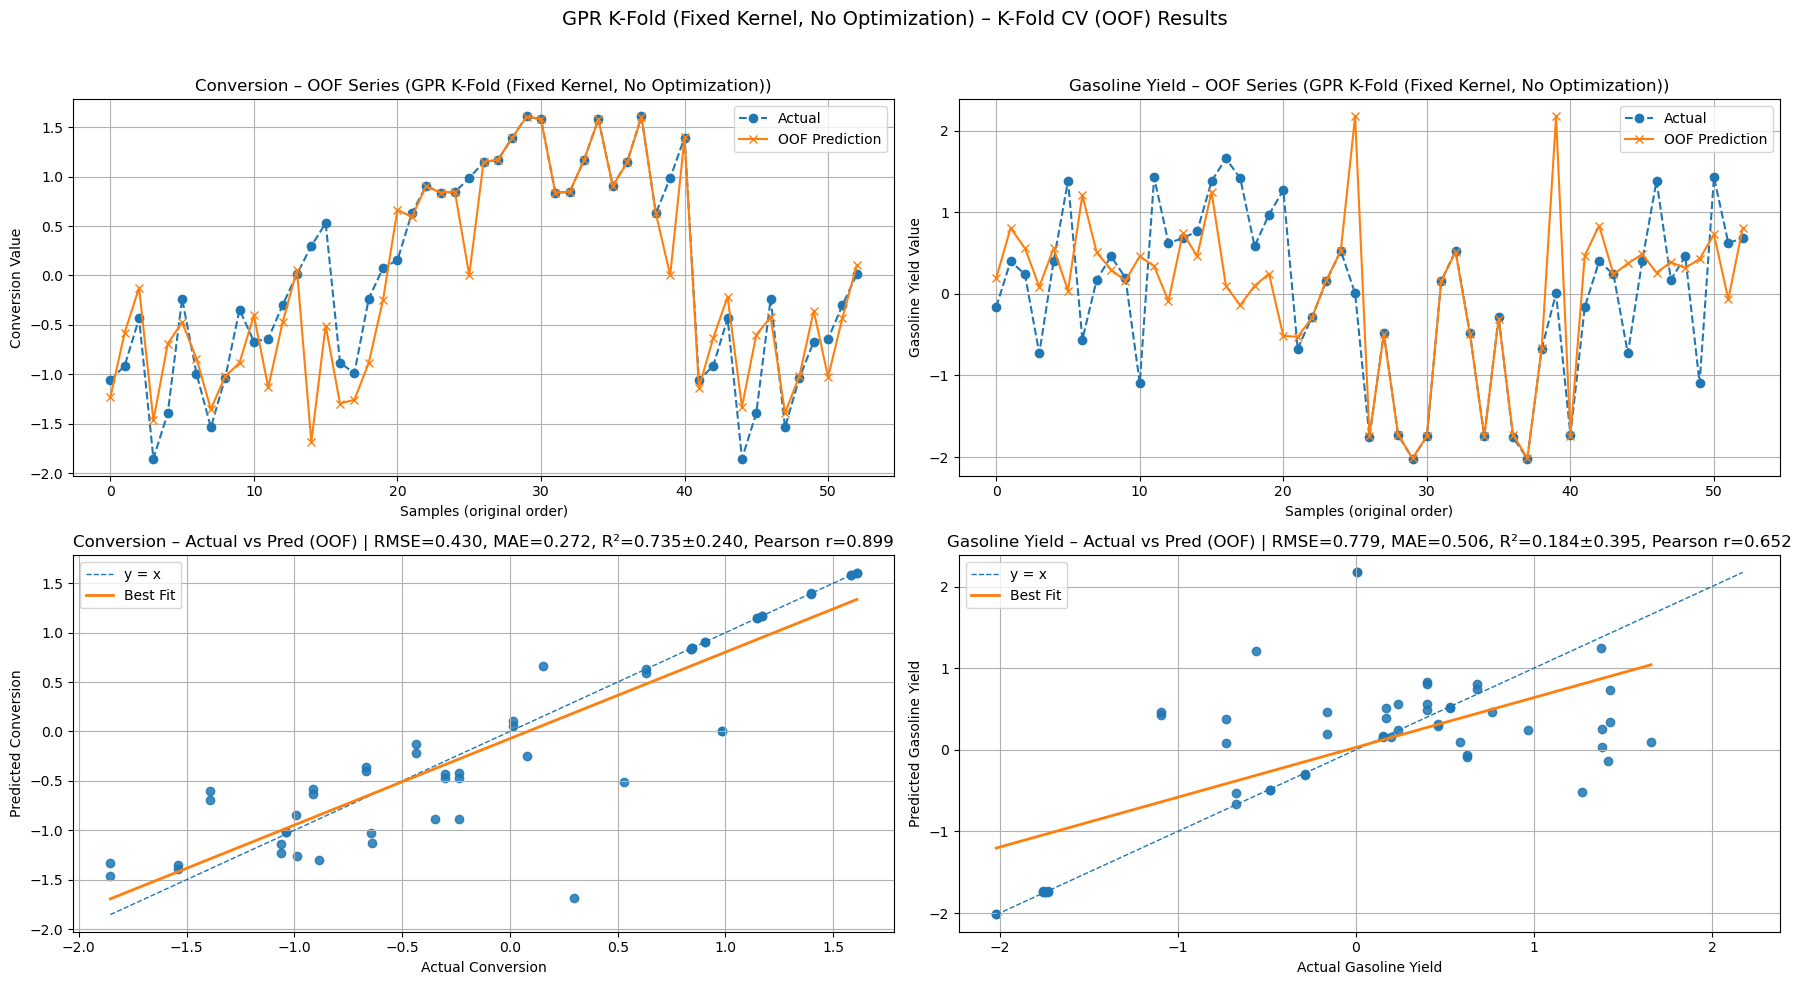

((0.7353802948976063, 0.42987891656611205, 0.2717293115589175),
 (0.18392010815519794, 0.779369307428085, 0.5056472497834268))

In [38]:
plot_kfold_subplots(
    y1_true=y1_GPR,
    y1_oof_pred=y1_oof_GPR,
    y2_true=y2_GPR,
    y2_oof_pred=y2_oof_GPR,
    model_name="GPR K-Fold (Fixed Kernel, No Optimization)",
    t1_name="Conversion",
    t2_name="Gasoline Yield",

    # --- GPR CV Metrics (corrected names) ---
    cv_rmse1=cv_rmse1_GPR,
    cv_mae1=np.mean(mae_list1_GPR),
    cv_r21=np.mean(r2_list1_GPR),
    cv_r21_std=np.std(r2_list1_GPR),

    cv_rmse2=cv_rmse2_GPR,
    cv_mae2=np.mean(mae_list2_GPR),
    cv_r22=np.mean(r2_list2_GPR),
    cv_r22_std=np.std(r2_list2_GPR),

    save=True,
    show=True
)

# GPR-BO

In [39]:
# ---- Settings ----
SEED = 42
N_SPLITS = 5                 # K in K-Fold CV
USE_DOUBLE_NOISE = False     # True → alpha=noise_level as well as WhiteKernel
USE_NORMALIZE_Y = False      # y is already normalized
N_BO_CALLS = 10              # Bayesian Optimization iterations

# Hyperparameter search space: tune ONLY observation noise
space = [Real(1e-9, 1e-1, prior="log-uniform", name="noise_level")]


def make_kernel(n_features, noise_level):
    return (
        C(1.0, (1e-3, 1e3))
        * (RBF(length_scale=np.ones(n_features), length_scale_bounds=(1e-3, 1e3))
           + RationalQuadratic(length_scale=1.0, alpha=1.0))
        + DotProduct()
        + WhiteKernel(noise_level=noise_level, noise_level_bounds=(1e-9, 1e-1))
    )

def make_GPR_BO(n_features, noise_level):
    kernel = make_kernel(n_features, noise_level)
    alpha = noise_level if USE_DOUBLE_NOISE else 0.0
    return GaussianProcessRegressor(
        kernel=kernel,
        alpha=alpha,
        normalize_y=USE_NORMALIZE_Y,
        n_restarts_optimizer=10,
        random_state=SEED
    )

def confidence_interval(values, confidence=0.95):
    values = np.array(values)
    mean = np.mean(values)
    std = np.std(values, ddof=1)
    n = len(values)
    ci = 1.96 * (std / np.sqrt(n))
    return mean, ci
def kfold_cv_with_oof(
    X, y, noise_level, 
    n_splits=N_SPLITS, 
    random_state=SEED, 
    return_stats=False,      
    compare_to=None,
    return_pearson=False     # <-- NEW FLAG
):
    """
    K-Fold CV for GPR-BO version.
    Computes RMSE, MAE, R², Pearson r (optional), and OOF predictions.
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    rmses, maes, r2s = [], [], []
    pearsons = []  # <-- NEW
    y_oof = pd.Series(index=y.index, dtype=float)

    nfeat = X.shape[1]

    for tr_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        gpr = make_GPR_BO(nfeat, noise_level)
        gpr.fit(X_tr, y_tr)
        y_val_pred = gpr.predict(X_val)

        y_oof.iloc[val_idx] = y_val_pred

        # -------------------------
        # Metrics
        # -------------------------
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae  = mean_absolute_error(y_val, y_val_pred)
        r2   = r2_score(y_val, y_val_pred)
        r_p, _ = pearsonr(y_val, y_val_pred)   # <-- NEW

        rmses.append(rmse)
        maes.append(mae)
        r2s.append(r2)
        pearsons.append(float(r_p))            # <-- NEW

    mean_rmse = float(np.mean(rmses))

    # -----------------------------------------------------------
    # STATISTICAL TESTING
    # -----------------------------------------------------------
    if return_stats and compare_to is not None:
        rmses_arr = np.array(rmses)
        compare_to = np.array(compare_to)

        if len(compare_to) != len(rmses_arr):
            raise ValueError("compare_to must have same length as rmses.")

        ttest_p = ttest_rel(rmses_arr, compare_to).pvalue
        wilcox_p = wilcoxon(rmses_arr, compare_to).pvalue

        mean_ci_mean, mean_ci_range = confidence_interval(rmses_arr)

        stats = {
            "mean_RMSE": mean_ci_mean,
            "RMSE_CI95": mean_ci_range,
            "paired_ttest_pvalue": ttest_p,
            "wilcoxon_pvalue": wilcox_p,
            # Optional: Pearson summaries could be added here
            # "pearson_r_mean": float(np.mean(pearsons)),
            # "pearson_r_std": float(np.std(pearsons)),
        }

        if return_pearson:
            return mean_rmse, rmses, maes, r2s, y_oof, pearsons, stats
        else:
            return mean_rmse, rmses, maes, r2s, y_oof, stats

    # =======================
    # NORMAL RETURN
    # =======================
    if return_pearson:
        return mean_rmse, rmses, maes, r2s, y_oof, pearsons
    else:
        return mean_rmse, rmses, maes, r2s, y_oof

In [40]:
print("\n================= K-Fold Cross-Validation (no hold-out) =================")

# Ensure X and y shapes
X1_GPR, y1_GPR = _ensure_2d_df(full_X_conversion), _ensure_1d_series(full_y_conversion)
X2_GPR, y2_GPR = _ensure_2d_df(full_X_gasoline),  _ensure_1d_series(full_y_gasoline)

nfeat1 = X1_GPR.shape[1]
nfeat2 = X2_GPR.shape[1]

# ============================================================
# Define BO search space (fresh, clean)
# ============================================================
from skopt.space import Real

space = [Real(1e-9, 1e-1, prior="log-uniform", name="noise_level")]

# ============================================================
# Conversion: BO on K-Fold
# ============================================================
from skopt.utils import use_named_args

@use_named_args(space)
def objective_conv(noise_level):
    # kfold_cv_with_oof returns: mean_rmse, rmses, maes, r2s, y_oof  (no Pearson here)
    mean_rmse, _, _, _, _ = kfold_cv_with_oof(X1_GPR, y1_GPR, noise_level)
    return mean_rmse   # minimize RMSE

print(" Optimizing GPR (K-Fold CV) for Conversion...")
res1 = gp_minimize(objective_conv, space, n_calls=N_BO_CALLS, random_state=SEED)
best_noise1 = res1.x[0]

(
    cv_rmse1_GPR_BO,
    rmse_list1_GPR_BO,
    mae_list1_GPR_BO,
    r2_list1_GPR_BO,
    y1_oof_GPR_BO,
    pearson_list1_GPR_BO      # <-- Pearson list
) = kfold_cv_with_oof(X1_GPR, y1_GPR, best_noise1, return_pearson=True)

print(
    f" Best (CV) for Conversion: noise={best_noise1:.3e} | "
    f"RMSE={cv_rmse1_GPR_BO:.6f} | "
    f"MAE={np.mean(mae_list1_GPR_BO):.6f} | "
    f"R²={np.mean(r2_list1_GPR_BO):.4f}±{np.std(r2_list1_GPR_BO):.4f} | "
    f"Pearson r={np.mean(pearson_list1_GPR_BO):.4f}±{np.std(pearson_list1_GPR_BO):.4f}"
)

gpr1_BO = make_GPR_BO(nfeat1, best_noise1)
gpr1_BO.fit(X1_GPR, y1_GPR)
print("Conversion fitted kernel:", gpr1_BO.kernel_)

# ============================================================
# Gasoline Yield: BO on K-Fold
# ============================================================
@use_named_args(space)
def objective_gasoline(noise_level):
    mean_rmse, _, _, _, _ = kfold_cv_with_oof(X2_GPR, y2_GPR, noise_level)
    return mean_rmse

print("\n Optimizing GPR (K-Fold CV) for Gasoline Yield...")
res2 = gp_minimize(objective_gasoline, space, n_calls=N_BO_CALLS, random_state=SEED)
best_noise2 = res2.x[0]

(
    cv_rmse2_GPR_BO,
    rmse_list2_GPR_BO,
    mae_list2_GPR_BO,
    r2_list2_GPR_BO,
    y2_oof_GPR_BO,
    pearson_list2_GPR_BO      # <-- Pearson list
) = kfold_cv_with_oof(X2_GPR, y2_GPR, best_noise2, return_pearson=True)

print(
    f" Best (CV) for Gasoline Yield: noise={best_noise2:.3e} | "
    f"RMSE={cv_rmse2_GPR_BO:.6f} | "
    f"MAE={np.mean(mae_list2_GPR_BO):.6f} | "
    f"R²={np.mean(r2_list2_GPR_BO):.4f}±{np.std(r2_list2_GPR_BO):.4f} | "
    f"Pearson r={np.mean(pearson_list2_GPR_BO):.4f}±{np.std(pearson_list2_GPR_BO):.4f}"
)

gpr2_BO = make_GPR_BO(nfeat2, best_noise2)
gpr2_BO.fit(X2_GPR, y2_GPR)
print("Gasoline Yield fitted kernel:", gpr2_BO.kernel_)

# ============================================================
# Store Results
# ============================================================
all_results_full = pd.DataFrame([
    {
        "Dataset": "Conversion",
        "CV_K": N_SPLITS,
        "Best_Noise": best_noise1,
        "CV_RMSE_mean": cv_rmse1_GPR_BO,
        "CV_RMSE_std": float(np.std(rmse_list1_GPR_BO)),
        "CV_MAE_mean": float(np.mean(mae_list1_GPR_BO)),
        "CV_MAE_std": float(np.std(mae_list1_GPR_BO)),
        "CV_R2_mean": float(np.mean(r2_list1_GPR_BO)),
        "CV_R2_std": float(np.std(r2_list1_GPR_BO)),
        "CV_Pearson_r_mean": float(np.mean(pearson_list1_GPR_BO)),
        "CV_Pearson_r_std": float(np.std(pearson_list1_GPR_BO)),
    },
    {
        "Dataset": "Gasoline Yield",
        "CV_K": N_SPLITS,
        "Best_Noise": best_noise2,
        "CV_RMSE_mean": cv_rmse2_GPR_BO,
        "CV_RMSE_std": float(np.std(rmse_list2_GPR_BO)),
        "CV_MAE_mean": float(np.mean(mae_list2_GPR_BO)),
        "CV_MAE_std": float(np.std(mae_list2_GPR_BO)),
        "CV_R2_mean": float(np.mean(r2_list2_GPR_BO)),
        "CV_R2_std": float(np.std(r2_list2_GPR_BO)),
        "CV_Pearson_r_mean": float(np.mean(pearson_list2_GPR_BO)),
        "CV_Pearson_r_std": float(np.std(pearson_list2_GPR_BO)),
    }
])

print("\n📊 K-Fold CV Summary (GPR-BO):")
print(all_results_full)

# Save results
all_results_full.to_csv("gpr_bo_kfold_cv_metrics.csv", index=False)


================= K-Fold Cross-Validation (no hold-out) =================
 Optimizing GPR (K-Fold CV) for Conversion...
 Best (CV) for Conversion: noise=2.934e-08 | RMSE=0.199316 | MAE=0.079125 | R²=0.9235±0.0845 | Pearson r=0.9670±0.0364
Conversion fitted kernel: 0.477**2 * RBF(length_scale=[841, 0.0223, 0.203]) + RationalQuadratic(alpha=9.09e+04, length_scale=1.99) + DotProduct(sigma_0=1e-05) + WhiteKernel(noise_level=3.85e-08)

 Optimizing GPR (K-Fold CV) for Gasoline Yield...
 Best (CV) for Gasoline Yield: noise=6.307e-09 | RMSE=0.356423 | MAE=0.162890 | R²=0.7995±0.1672 | Pearson r=0.9096±0.0774
Gasoline Yield fitted kernel: 0.784**2 * RBF(length_scale=[1e+03, 0.00116, 0.24]) + RationalQuadratic(alpha=1.07e-05, length_scale=3.07e+04) + DotProduct(sigma_0=0.000807) + WhiteKernel(noise_level=1.93e-07)

📊 K-Fold CV Summary (GPR-BO):
          Dataset  CV_K    Best_Noise  CV_RMSE_mean  CV_RMSE_std  CV_MAE_mean  \
0      Conversion     5  2.934123e-08      0.199316     0.155064     0.

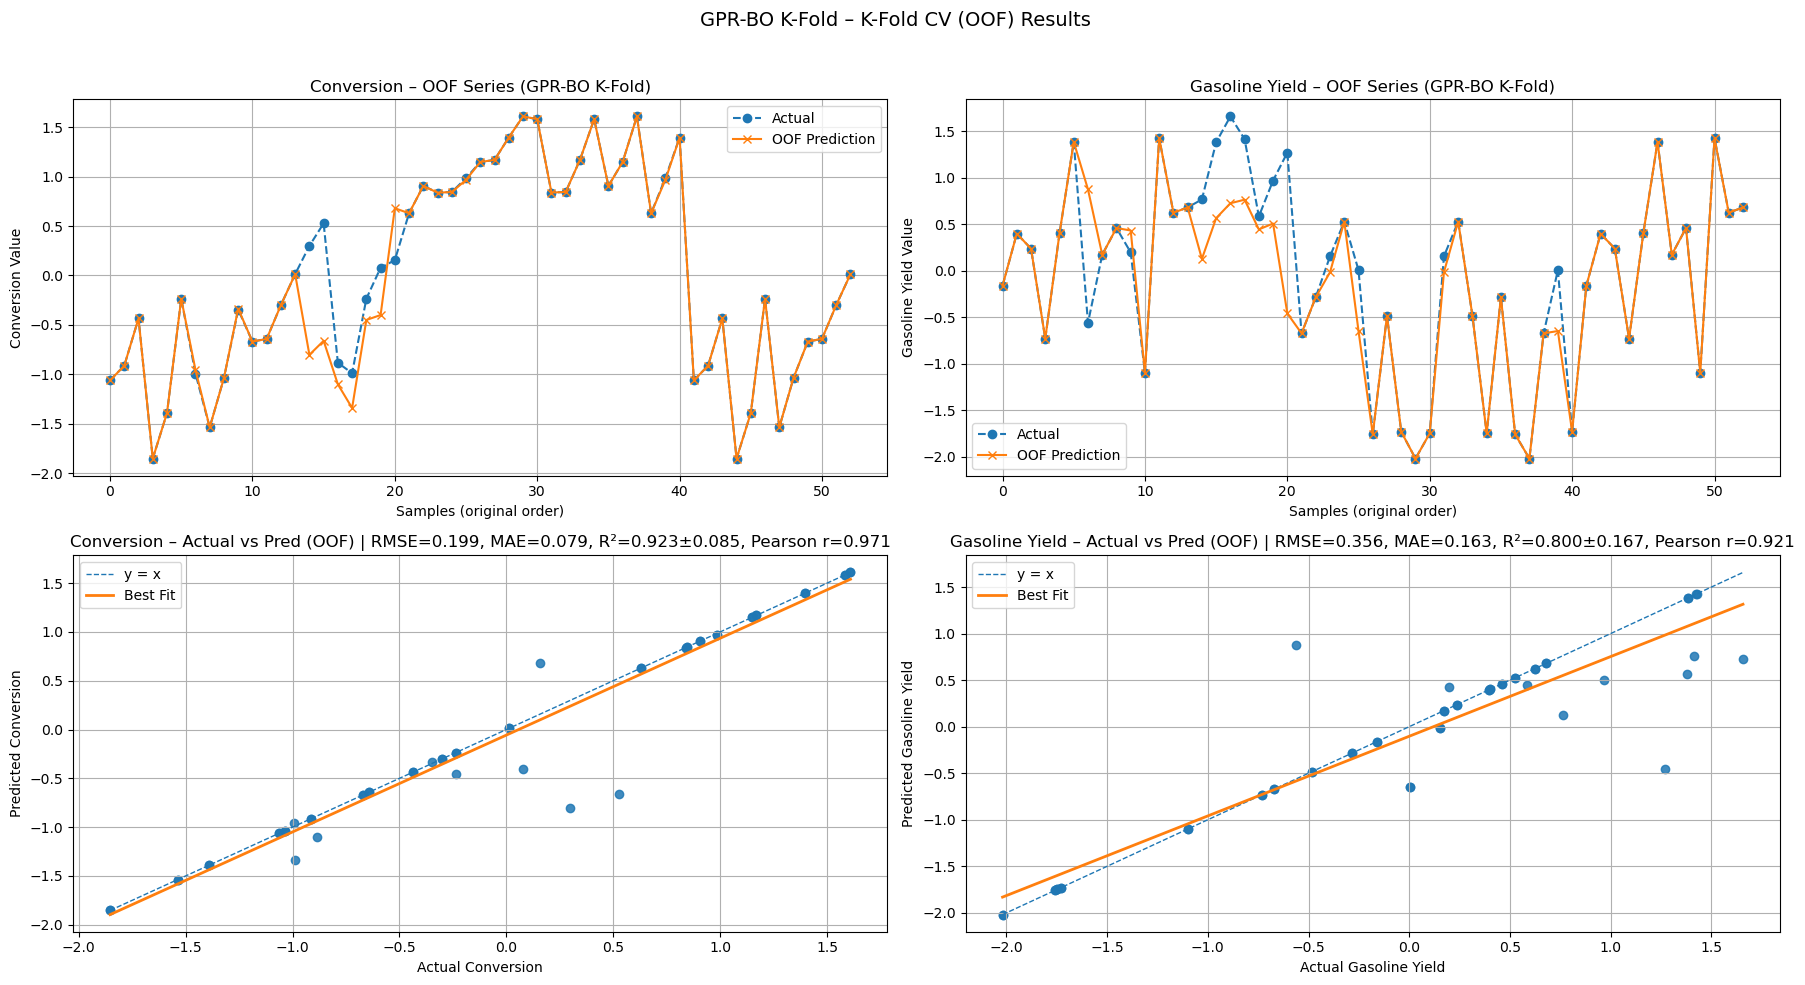

((0.9234755085455506, 0.19931577549579552, 0.07912517060151243),
 (0.7995200967909103, 0.3564230297456392, 0.1628900795443151))

In [41]:
plot_kfold_subplots(
    y1_true=y1_GPR,
    y1_oof_pred=y1_oof_GPR_BO,
    y2_true=y2_GPR,
    y2_oof_pred=y2_oof_GPR_BO,
    model_name="GPR-BO K-Fold",
    t1_name="Conversion",
    t2_name="Gasoline Yield",

    # --- CV Metrics from BO ---
    cv_rmse1=cv_rmse1_GPR_BO,
    cv_mae1=np.mean(mae_list1_GPR_BO),
    cv_r21=np.mean(r2_list1_GPR_BO),
    cv_r21_std=np.std(r2_list1_GPR_BO),

    cv_rmse2=cv_rmse2_GPR_BO,
    cv_mae2=np.mean(mae_list2_GPR_BO),
    cv_r22=np.mean(r2_list2_GPR_BO),
    cv_r22_std=np.std(r2_list2_GPR_BO),

    save=True,
    show=True
)

# BT/GBR

In [42]:
# ============================================
# Gradient Boosting K-Fold CV (NO Optimization)
# ============================================

SEED = 42
N_SPLITS = 5

# Fixed baseline hyperparameters
BASE_N_ESTIMATORS = 200
BASE_MAX_DEPTH   = 3
BASE_LR          = 0.10
BASE_SUBSAMPLE   = 0.7


def make_GBR():
    """Fixed-parameter Gradient Boosting Regressor"""
    return GradientBoostingRegressor(
        n_estimators=BASE_N_ESTIMATORS,
        learning_rate=BASE_LR,
        max_depth=BASE_MAX_DEPTH,
        subsample=BASE_SUBSAMPLE,
        loss="squared_error",
        random_state=SEED,
        n_iter_no_change=None
    )


from scipy.stats import pearsonr

def kfold_cv_with_oof_GBR(
    X, y,
    n_splits=N_SPLITS,
    random_state=SEED,
    return_stats=False,
    compare_to=None,
    return_pearson=False     # <-- NEW FLAG
):
    """
    K-Fold CV for GBR (fixed hyperparameters).
    Computes RMSE, MAE, R², Pearson r (optional), and OOF predictions.
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    rmses, maes, r2s = [], [], []
    pearsons = []       # <-- NEW
    y_oof = pd.Series(index=y.index, dtype=float)

    for tr_idx, val_idx in kf.split(X):

        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        model = make_GBR()
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)

        # Store OOF predictions
        y_oof.iloc[val_idx] = y_val_pred

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae  = mean_absolute_error(y_val, y_val_pred)
        r2   = r2_score(y_val, y_val_pred)
        r_p, _ = pearsonr(y_val, y_val_pred)       # <-- NEW

        rmses.append(rmse)
        maes.append(mae)
        r2s.append(r2)
        pearsons.append(float(r_p))                # <-- NEW

    mean_rmse = float(np.mean(rmses))

    # ============================================
    # 🔥 STATISTICAL TESTING (RMSE)
    # ============================================
    if return_stats and compare_to is not None:
        rmses_arr = np.array(rmses)
        compare_to = np.array(compare_to)

        if len(compare_to) != len(rmses_arr):
            raise ValueError("compare_to must have same length as RMSE list")

        # Paired t-test
        ttest_p = ttest_rel(rmses_arr, compare_to).pvalue

        # Wilcoxon signed-rank
        wilcox_p = wilcoxon(rmses_arr, compare_to).pvalue

        # 95% CI
        mean_ci_mean, mean_ci_range = confidence_interval(rmses_arr)

        stats = {
            "mean_RMSE": mean_ci_mean,
            "RMSE_CI95": mean_ci_range,
            "paired_ttest_pvalue": ttest_p,
            "wilcoxon_pvalue": wilcox_p,
            # Optional:
            # "pearson_r_mean": float(np.mean(pearsons)),
            # "pearson_r_std": float(np.std(pearsons)),
        }

        if return_pearson:
            return mean_rmse, rmses, maes, r2s, y_oof, pearsons, stats
        else:
            return mean_rmse, rmses, maes, r2s, y_oof, stats

    # ----------------- NORMAL RETURN -----------------
    if return_pearson:
        return mean_rmse, rmses, maes, r2s, y_oof, pearsons
    else:
        return mean_rmse, rmses, maes, r2s, y_oof

In [43]:
# ====================================================
# RUNNING THE FIXED-PARAMETER GBR K-Fold CV MODEL (_GBR)
# ====================================================

print("\n=== GBR K-Fold CV (NO Optimization): Conversion ===")

(
    cv_rmse1_GBR,
    rmse_list1_GBR,
    mae_list1_GBR,
    r2_list1_GBR,
    y1_oof_GBR,
    pearson_list1_GBR     # <-- NEW
) = kfold_cv_with_oof_GBR(X1_GPR, y1_GPR, return_pearson=True)

print(
    f" CV RMSE={cv_rmse1_GBR:.6f} | "
    f"MAE={np.mean(mae_list1_GBR):.6f} | "
    f"R²={np.mean(r2_list1_GBR):.4f}±{np.std(r2_list1_GBR):.4f} | "
    f"Pearson r={np.mean(pearson_list1_GBR):.4f}±{np.std(pearson_list1_GBR):.4f}"
)


print("\n=== GBR K-Fold CV (NO Optimization): Gasoline Yield ===")

(
    cv_rmse2_GBR,
    rmse_list2_GBR,
    mae_list2_GBR,
    r2_list2_GBR,
    y2_oof_GBR,
    pearson_list2_GBR     # <-- NEW
) = kfold_cv_with_oof_GBR(X2_GPR, y2_GPR, return_pearson=True)

print(
    f" CV RMSE={cv_rmse2_GBR:.6f} | "
    f"MAE={np.mean(mae_list2_GBR):.6f} | "
    f"R²={np.mean(r2_list2_GBR):.4f}±{np.std(r2_list2_GBR):.4f} | "
    f"Pearson r={np.mean(pearson_list2_GBR):.4f}±{np.std(pearson_list2_GBR):.4f}"
)


# ====================================================
# BUILD A SUMMARY TABLE FOR EXPORT
# ====================================================

all_results_gbr_kcv = pd.DataFrame([
    {
        "Dataset": "Conversion",
        "CV_K": N_SPLITS,
        "CV_RMSE_mean": cv_rmse1_GBR,
        "CV_RMSE_std": float(np.std(rmse_list1_GBR)),
        "CV_MAE_mean": float(np.mean(mae_list1_GBR)),
        "CV_MAE_std": float(np.std(mae_list1_GBR)),
        "CV_R2_mean": float(np.mean(r2_list1_GBR)),
        "CV_R2_std": float(np.std(r2_list1_GBR)),
        "CV_Pearson_r_mean": float(np.mean(pearson_list1_GBR)),    # <-- NEW
        "CV_Pearson_r_std": float(np.std(pearson_list1_GBR)),      # <-- NEW
        "n_estimators": BASE_N_ESTIMATORS,
        "max_depth": BASE_MAX_DEPTH,
        "learning_rate": BASE_LR,
        "subsample": BASE_SUBSAMPLE,
    },
    {
        "Dataset": "Gasoline Yield",
        "CV_K": N_SPLITS,
        "CV_RMSE_mean": cv_rmse2_GBR,
        "CV_RMSE_std": float(np.std(rmse_list2_GBR)),
        "CV_MAE_mean": float(np.mean(mae_list2_GBR)),
        "CV_MAE_std": float(np.std(mae_list2_GBR)),
        "CV_R2_mean": float(np.mean(r2_list2_GBR)),
        "CV_R2_std": float(np.std(r2_list2_GBR)),
        "CV_Pearson_r_mean": float(np.mean(pearson_list2_GBR)),    # <-- NEW
        "CV_Pearson_r_std": float(np.std(pearson_list2_GBR)),      # <-- NEW
        "n_estimators": BASE_N_ESTIMATORS,
        "max_depth": BASE_MAX_DEPTH,
        "learning_rate": BASE_LR,
        "subsample": BASE_SUBSAMPLE,
    }
])

print("\n📊 GBR K-Fold CV Summary (NO Optimization):")
print(all_results_gbr_kcv)

all_results_gbr_kcv.to_csv("gbr_kfold_cv_metrics_no_optimization.csv", index=False)


=== GBR K-Fold CV (NO Optimization): Conversion ===
 CV RMSE=0.166880 | MAE=0.070706 | R²=0.9580±0.0309 | Pearson r=0.9847±0.0093

=== GBR K-Fold CV (NO Optimization): Gasoline Yield ===
 CV RMSE=0.577636 | MAE=0.259767 | R²=0.5202±0.2516 | Pearson r=0.7970±0.1028

📊 GBR K-Fold CV Summary (NO Optimization):
          Dataset  CV_K  CV_RMSE_mean  CV_RMSE_std  CV_MAE_mean  CV_MAE_std  \
0      Conversion     5      0.166880     0.093393     0.070706    0.039768   
1  Gasoline Yield     5      0.577636     0.280712     0.259767    0.157312   

   CV_R2_mean  CV_R2_std  CV_Pearson_r_mean  CV_Pearson_r_std  n_estimators  \
0    0.958021   0.030946           0.984724          0.009282           200   
1    0.520198   0.251599           0.797010          0.102833           200   

   max_depth  learning_rate  subsample  
0          3            0.1        0.7  
1          3            0.1        0.7  


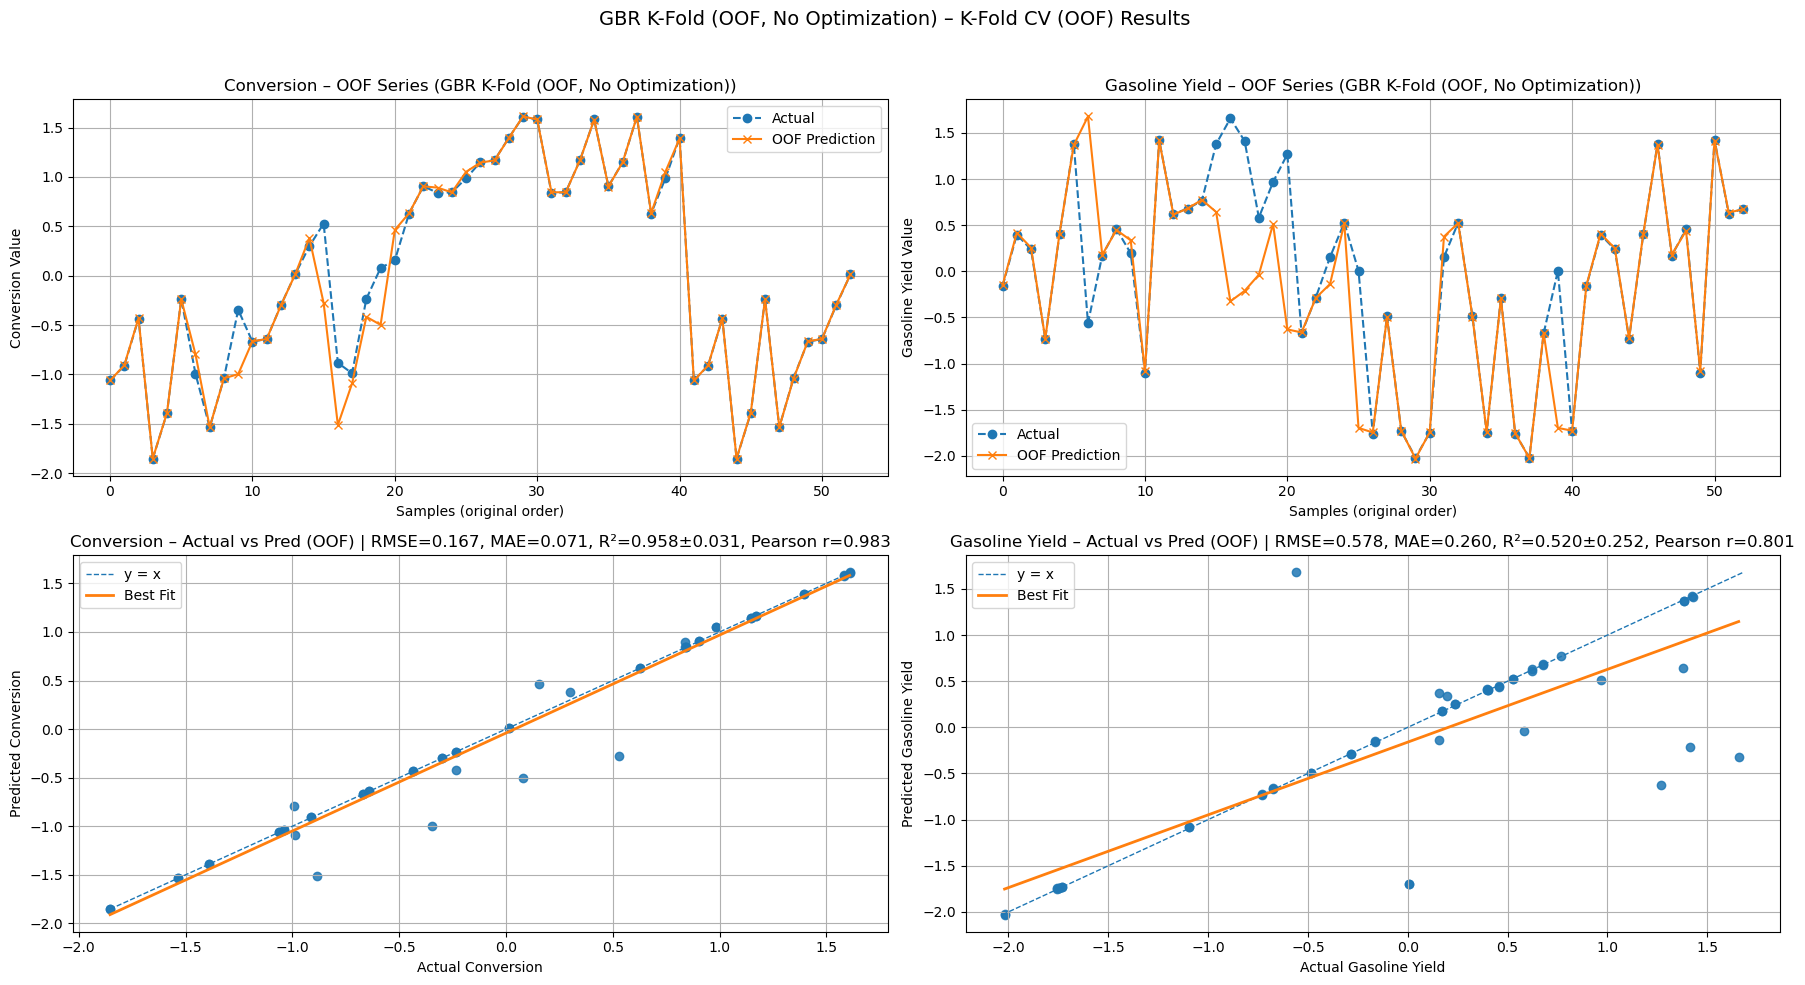

In [44]:
# =======================
# PLOTTING — GBR (NO BO)
# =======================

_ = plot_kfold_subplots(
    y1_true=y1_GPR,
    y1_oof_pred=y1_oof_GBR,
    y2_true=y2_GPR,
    y2_oof_pred=y2_oof_GBR,

    model_name="GBR K-Fold (OOF, No Optimization)",
    t1_name="Conversion",
    t2_name="Gasoline Yield",

    # --- Conversion metrics ---
    cv_rmse1=cv_rmse1_GBR,
    cv_mae1=np.mean(mae_list1_GBR),
    cv_r21=np.mean(r2_list1_GBR),
    cv_r21_std=np.std(r2_list1_GBR),

    # --- Gasoline Yield metrics ---
    cv_rmse2=cv_rmse2_GBR,
    cv_mae2=np.mean(mae_list2_GBR),
    cv_r22=np.mean(r2_list2_GBR),
    cv_r22_std=np.std(r2_list2_GBR),

    save=True,
    show=True
)

# BT-BO

In [45]:
# ============================================
# Gradient Boosting K-Fold CV (NO Optimization)
# ============================================

SEED = 42
N_SPLITS_GBR = 5
N_BO_CALLS_GBR = 10

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# ---- BO search space for GBR ----
space_gbr = [
    Integer(50, 500,   name="n_estimators"),
    Integer(2, 10,     name="max_depth"),
    Real(0.01, 0.30,   name="learning_rate"),
    Real(0.10, 1.00,   name="subsample"),
]

# ---- GBR model for BO ----
def make_GBR_BO(n_estimators, max_depth, learning_rate, subsample):
    return GradientBoostingRegressor(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        subsample=float(subsample),
        loss="squared_error",
        validation_fraction=0.10,
        n_iter_no_change=10,
        tol=1e-4,
        random_state=SEED,
    )
    
def kfold_cv_with_oof_GBR_BO(
    X, y,
    n_estimators, max_depth, learning_rate, subsample,
    n_splits=N_SPLITS_GBR,
    random_state=SEED,
    return_pearson=False    # <-- NEW FLAG
):
    """
    K-Fold CV for GBR-BO.
    Returns:
      mean_rmse, rmse_list, mae_list, r2_list, y_oof
    If return_pearson=True:
      also returns pearson_list
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    rmse_list, mae_list, r2_list = [], [], []
    pearson_list = []             # <-- NEW
    y_oof = pd.Series(index=y.index, dtype=float)

    for tr_idx, val_idx in kf.split(X):

        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        model = make_GBR_BO(n_estimators, max_depth, learning_rate, subsample)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        y_oof.iloc[val_idx] = y_pred

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae  = mean_absolute_error(y_val, y_pred)
        r2   = r2_score(y_val, y_pred)
        r_p, _ = pearsonr(y_val, y_pred)    # <-- NEW

        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)
        pearson_list.append(float(r_p))      # <-- NEW

    mean_rmse = float(np.mean(rmse_list))

    # Return results (with optional Pearson)
    if return_pearson:
        return mean_rmse, rmse_list, mae_list, r2_list, y_oof, pearson_list
    else:
        return mean_rmse, rmse_list, mae_list, r2_list, y_oof

In [46]:
# ============================================================
# Gradient Boosting Regression — Bayesian Optimization + K-Fold CV
# ============================================================

# ---------- Preprocessed data ----------
X1_GBR, y1_GBR = _ensure_2d_df(full_X_conversion), _ensure_1d_series(full_y_conversion)
X2_GBR, y2_GBR = _ensure_2d_df(full_X_gasoline),  _ensure_1d_series(full_y_gasoline)

# ---------- BO Objective Functions ----------
@use_named_args(space_gbr)
def objective_conv_gbr(n_estimators, max_depth, learning_rate, subsample):
    mean_rmse, _, _, _, _ = kfold_cv_with_oof_GBR_BO(
        X1_GBR, y1_GBR,
        n_estimators, max_depth, learning_rate, subsample
    )
    return mean_rmse

@use_named_args(space_gbr)
def objective_yield_gbr(n_estimators, max_depth, learning_rate, subsample):
    mean_rmse, _, _, _, _ = kfold_cv_with_oof_GBR_BO(
        X2_GBR, y2_GBR,
        n_estimators, max_depth, learning_rate, subsample
    )
    return mean_rmse


# ============================================================
# Conversion — BO + K-Fold CV
# ============================================================
print("\n=== GBR-BO K-Fold CV: Conversion ===")

res1_gbr = gp_minimize(
    objective_conv_gbr, space_gbr,
    n_calls=N_BO_CALLS_GBR,
    random_state=SEED
)

best_conv_gbr = res1_gbr.x   # [n_estimators, max_depth, learning_rate, subsample]

(
    cv_rmse1_GBR_BO,
    rmse_list1_GBR_BO,
    mae_list1_GBR_BO,
    r2_list1_GBR_BO,
    y1_oof_GBR_BO,
    pearson_list1_GBR_BO         # <-- NEW
) = kfold_cv_with_oof_GBR_BO(X1_GBR, y1_GBR, *best_conv_gbr, return_pearson=True)

print(
    f" Best params (Conversion, GBR-BO): "
    f"n_estimators={best_conv_gbr[0]}, max_depth={best_conv_gbr[1]}, "
    f"learning_rate={best_conv_gbr[2]:.3f}, subsample={best_conv_gbr[3]:.3f}"
)
print(
    f" CV RMSE={cv_rmse1_GBR_BO:.6f} | "
    f"MAE={np.mean(mae_list1_GBR_BO):.6f} | "
    f"R²={np.mean(r2_list1_GBR_BO):.4f}±{np.std(r2_list1_GBR_BO):.4f} | "
    f"Pearson r={np.mean(pearson_list1_GBR_BO):.4f}±{np.std(pearson_list1_GBR_BO):.4f}"
)


# ============================================================
# Gasoline Yield — BO + K-Fold CV
# ============================================================
print("\n=== GBR-BO K-Fold CV: Gasoline Yield ===")

res2_gbr = gp_minimize(
    objective_yield_gbr, space_gbr,
    n_calls=N_BO_CALLS_GBR,
    random_state=SEED
)

best_yield_gbr = res2_gbr.x

(
    cv_rmse2_GBR_BO,
    rmse_list2_GBR_BO,
    mae_list2_GBR_BO,
    r2_list2_GBR_BO,
    y2_oof_GBR_BO,
    pearson_list2_GBR_BO         # <-- NEW
) = kfold_cv_with_oof_GBR_BO(X2_GBR, y2_GBR, *best_yield_gbr, return_pearson=True)

print(
    f" Best params (Yield, GBR-BO): "
    f"n_estimators={best_yield_gbr[0]}, max_depth={best_yield_gbr[1]}, "
    f"learning_rate={best_yield_gbr[2]:.3f}, subsample={best_yield_gbr[3]:.3f}"
)
print(
    f" CV RMSE={cv_rmse2_GBR_BO:.6f} | "
    f"MAE={np.mean(mae_list2_GBR_BO):.6f} | "
    f"R²={np.mean(r2_list2_GBR_BO):.4f}±{np.std(r2_list2_GBR_BO):.4f} | "
    f"Pearson r={np.mean(pearson_list2_GBR_BO):.4f}±{np.std(pearson_list2_GBR_BO):.4f}"
)


# ============================================================
# Results Table
# ============================================================
all_results_gbr_bo_kcv = pd.DataFrame([
    {
        "Dataset": "Conversion",
        "CV_K": N_SPLITS_GBR,
        "CV_RMSE_mean": cv_rmse1_GBR_BO,
        "CV_RMSE_std": float(np.std(rmse_list1_GBR_BO)),
        "CV_MAE_mean": float(np.mean(mae_list1_GBR_BO)),
        "CV_MAE_std": float(np.std(mae_list1_GBR_BO)),
        "CV_R2_mean": float(np.mean(r2_list1_GBR_BO)),
        "CV_R2_std": float(np.std(r2_list1_GBR_BO)),
        "CV_Pearson_r_mean": float(np.mean(pearson_list1_GBR_BO)),     # <-- NEW
        "CV_Pearson_r_std": float(np.std(pearson_list1_GBR_BO)),       # <-- NEW
        "Best_n_estimators": best_conv_gbr[0],
        "Best_max_depth": best_conv_gbr[1],
        "Best_learning_rate": best_conv_gbr[2],
        "Best_subsample": best_conv_gbr[3],
    },
    {
        "Dataset": "Gasoline Yield",
        "CV_K": N_SPLITS_GBR,
        "CV_RMSE_mean": cv_rmse2_GBR_BO,
        "CV_RMSE_std": float(np.std(rmse_list2_GBR_BO)),
        "CV_MAE_mean": float(np.mean(mae_list2_GBR_BO)),
        "CV_MAE_std": float(np.std(mae_list2_GBR_BO)),
        "CV_R2_mean": float(np.mean(r2_list2_GBR_BO)),
        "CV_R2_std": float(np.std(r2_list2_GBR_BO)),
        "CV_Pearson_r_mean": float(np.mean(pearson_list2_GBR_BO)),     # <-- NEW
        "CV_Pearson_r_std": float(np.std(pearson_list2_GBR_BO)),       # <-- NEW
        "Best_n_estimators": best_yield_gbr[0],
        "Best_max_depth": best_yield_gbr[1],
        "Best_learning_rate": best_yield_gbr[2],
        "Best_subsample": best_yield_gbr[3],
    }
])

print("\n📊 GBR-BO K-Fold CV Summary:")
print(all_results_gbr_bo_kcv)

all_results_gbr_bo_kcv.to_csv("gbr_bo_kfold_cv_metrics.csv", index=False)


=== GBR-BO K-Fold CV: Conversion ===
 Best params (Conversion, GBR-BO): n_estimators=408, max_depth=3, learning_rate=0.236, subsample=0.637
 CV RMSE=0.187450 | MAE=0.105825 | R²=0.9543±0.0259 | Pearson r=0.9819±0.0121

=== GBR-BO K-Fold CV: Gasoline Yield ===
 Best params (Yield, GBR-BO): n_estimators=260, max_depth=9, learning_rate=0.207, subsample=0.505
 CV RMSE=0.571373 | MAE=0.359815 | R²=0.5553±0.3306 | Pearson r=0.8077±0.1424

📊 GBR-BO K-Fold CV Summary:
          Dataset  CV_K  CV_RMSE_mean  CV_RMSE_std  CV_MAE_mean  CV_MAE_std  \
0      Conversion     5      0.187450     0.095371     0.105825    0.049326   
1  Gasoline Yield     5      0.571373     0.331368     0.359815    0.232506   

   CV_R2_mean  CV_R2_std  CV_Pearson_r_mean  CV_Pearson_r_std  \
0    0.954254   0.025943           0.981873          0.012054   
1    0.555253   0.330636           0.807741          0.142421   

   Best_n_estimators  Best_max_depth  Best_learning_rate  Best_subsample  
0                408     

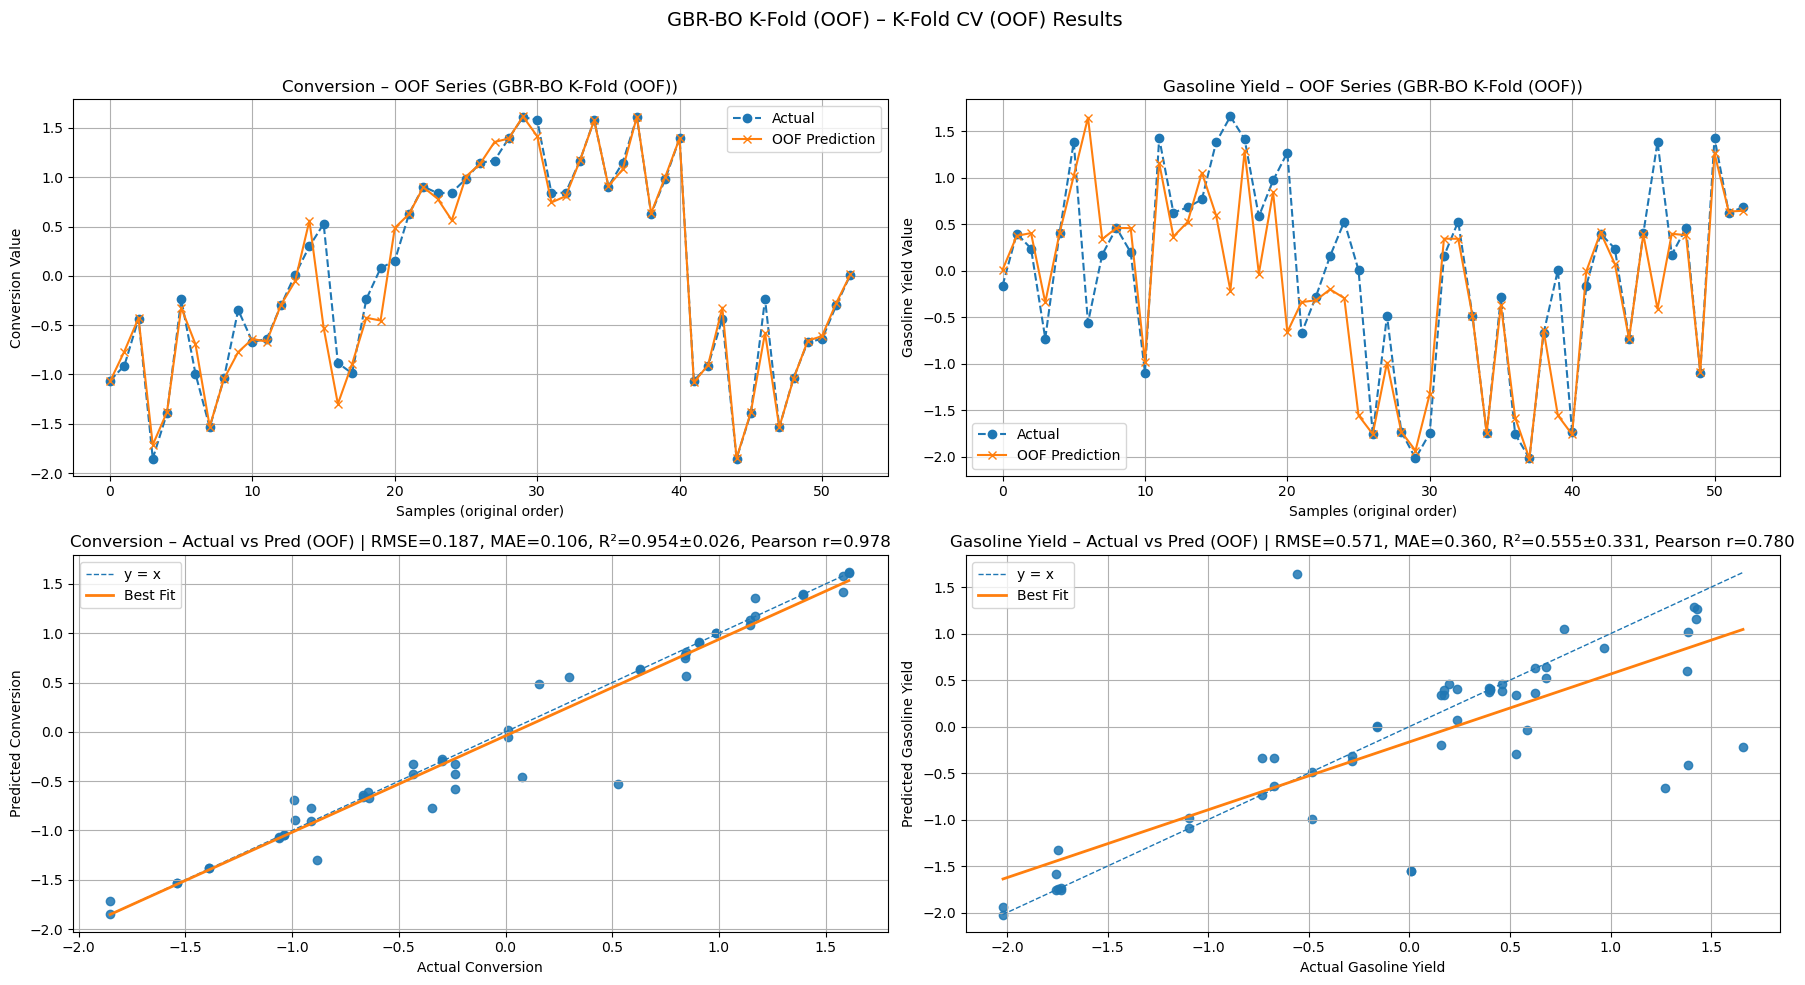

In [47]:
_ = plot_kfold_subplots(
    y1_true=y1_GBR,
    y1_oof_pred=y1_oof_GBR_BO,
    y2_true=y2_GBR,
    y2_oof_pred=y2_oof_GBR_BO,

    model_name="GBR-BO K-Fold (OOF)",
    t1_name="Conversion",
    t2_name="Gasoline Yield",

    # --- Conversion metrics ---
    cv_rmse1=cv_rmse1_GBR_BO,
    cv_mae1=np.mean(mae_list1_GBR_BO),
    cv_r21=np.mean(r2_list1_GBR_BO),
    cv_r21_std=np.std(r2_list1_GBR_BO),

    # --- Gasoline Yield metrics ---
    cv_rmse2=cv_rmse2_GBR_BO,
    cv_mae2=np.mean(mae_list2_GBR_BO),
    cv_r22=np.mean(r2_list2_GBR_BO),
    cv_r22_std=np.std(r2_list2_GBR_BO),

    save=True,
    show=True
)

# RLR

In [48]:
# ===============================================================
# RANSAC (Robust Linear Regression) — PURE K-Fold CV (NO BO)
# ===============================================================

SEED = 42
N_SPLITS_RANSAC = 5

# Fixed hyperparameters
RANSAC_MAX_TRIALS = 200
RANSAC_MIN_SAMPLES = 0.10
RANSAC_RESIDUAL_THRESHOLD = None


def make_RLR(seed=SEED):
    """Fixed RANSAC model compatible with sklearn versions."""
    common = dict(
        max_trials=RANSAC_MAX_TRIALS,
        min_samples=RANSAC_MIN_SAMPLES,
        residual_threshold=RANSAC_RESIDUAL_THRESHOLD,
        random_state=seed
    )

    try:
        return RANSACRegressor(estimator=LinearRegression(), **common)
    except TypeError:
        return RANSACRegressor(base_estimator=LinearRegression(), **common)


from scipy.stats import pearsonr

def kfold_cv_with_oof_RANSAC(
    X, y, 
    n_splits=N_SPLITS_RANSAC, 
    random_state=SEED,
    return_pearson=False   # <-- NEW FLAG
):
    """
    K-Fold CV for RANSAC-Linear Regression.
    RETURNS:
      mean_rmse, rmse_list, mae_list, r2_list, y_oof
    If return_pearson=True:
      ALSO returns pearson_list
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    rmse_list, mae_list, r2_list = [], [], []
    pearson_list = []               # <-- NEW
    y_oof = pd.Series(index=y.index, dtype=float)

    for tr_idx, val_idx in kf.split(X):

        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        model = make_RLR(seed=random_state)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        y_oof.iloc[val_idx] = y_pred

        # --- Metrics ---
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae  = mean_absolute_error(y_val, y_pred)
        r2   = r2_score(y_val, y_pred)
        r_p, _ = pearsonr(y_val, y_pred)   # <-- NEW

        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)
        pearson_list.append(float(r_p))    # <-- NEW

    mean_rmse = float(np.mean(rmse_list))

    # Return full results
    if return_pearson:
        return mean_rmse, rmse_list, mae_list, r2_list, y_oof, pearson_list
    else:
        return mean_rmse, rmse_list, mae_list, r2_list, y_oof


# ---------- Data ----------
X1 = _ensure_2d_df(full_X_conversion)
y1 = _ensure_1d_series(full_y_conversion)

X2 = _ensure_2d_df(full_X_gasoline)
y2 = _ensure_1d_series(full_y_gasoline)

In [49]:
# ============================================================
# RUNNING RLR (RANSAC) — K-Fold CV (NO Optimization)
# ============================================================

print("\n=== RLR K-Fold CV (NO Optimization): Conversion ===")

(
    cv_rmse1_RLR,
    rmse_list1_RLR,
    mae_list1_RLR,
    r2_list1_RLR,
    y1_oof_RLR,
    pearson_list1_RLR      # <-- NEW
) = kfold_cv_with_oof_RANSAC(X1, y1, return_pearson=True)

print(
    f" CV RMSE={cv_rmse1_RLR:.6f} | "
    f"MAE={np.mean(mae_list1_RLR):.6f} | "
    f"R²={np.mean(r2_list1_RLR):.4f}±{np.std(r2_list1_RLR):.4f} | "
    f"Pearson r={np.mean(pearson_list1_RLR):.4f}±{np.std(pearson_list1_RLR):.4f}"
)


print("\n=== RLR K-Fold CV (NO Optimization): Gasoline Yield ===")

(
    cv_rmse2_RLR,
    rmse_list2_RLR,
    mae_list2_RLR,
    r2_list2_RLR,
    y2_oof_RLR,
    pearson_list2_RLR      # <-- NEW
) = kfold_cv_with_oof_RANSAC(X2, y2, return_pearson=True)

print(
    f" CV RMSE={cv_rmse2_RLR:.6f} | "
    f"MAE={np.mean(mae_list2_RLR):.6f} | "
    f"R²={np.mean(r2_list2_RLR):.4f}±{np.std(r2_list2_RLR):.4f} | "
    f"Pearson r={np.mean(pearson_list2_RLR):.4f}±{np.std(pearson_list2_RLR):.4f}"
)


# ============================================================
# storing results
# ============================================================

all_results_ransac_kcv_noopt = pd.DataFrame([
    {
        "Dataset": "Conversion",
        "CV_K": N_SPLITS,
        "CV_RMSE_mean": cv_rmse1_RLR,
        "CV_RMSE_std": float(np.std(rmse_list1_RLR)),
        "CV_MAE_mean": float(np.mean(mae_list1_RLR)),
        "CV_MAE_std": float(np.std(mae_list1_RLR)),
        "CV_R2_mean": float(np.mean(r2_list1_RLR)),
        "CV_R2_std": float(np.std(r2_list1_RLR)),
        "CV_Pearson_r_mean": float(np.mean(pearson_list1_RLR)),      # <-- NEW
        "CV_Pearson_r_std": float(np.std(pearson_list1_RLR)),        # <-- NEW
        "max_trials": int(RANSAC_MAX_TRIALS),
        "min_samples": float(RANSAC_MIN_SAMPLES),
        "residual_threshold": RANSAC_RESIDUAL_THRESHOLD,
    },
    {
        "Dataset": "Gasoline Yield",
        "CV_K": N_SPLITS,
        "CV_RMSE_mean": cv_rmse2_RLR,
        "CV_RMSE_std": float(np.std(rmse_list2_RLR)),
        "CV_MAE_mean": float(np.mean(mae_list2_RLR)),
        "CV_MAE_std": float(np.std(mae_list2_RLR)),
        "CV_R2_mean": float(np.mean(r2_list2_RLR)),
        "CV_R2_std": float(np.std(r2_list2_RLR)),
        "CV_Pearson_r_mean": float(np.mean(pearson_list2_RLR)),      # <-- NEW
        "CV_Pearson_r_std": float(np.std(pearson_list2_RLR)),        # <-- NEW
        "max_trials": int(RANSAC_MAX_TRIALS),
        "min_samples": float(RANSAC_MIN_SAMPLES),
        "residual_threshold": RANSAC_RESIDUAL_THRESHOLD,
    }
])

print("\n📊 RLR K-Fold CV Summary (NO Optimization):")
print(all_results_ransac_kcv_noopt)

all_results_ransac_kcv_noopt.to_csv(
    "ransac_kfold_cv_metrics_no_optimization.csv", index=False
)


=== RLR K-Fold CV (NO Optimization): Conversion ===
 CV RMSE=0.429821 | MAE=0.325749 | R²=0.7530±0.1547 | Pearson r=0.9135±0.0660

=== RLR K-Fold CV (NO Optimization): Gasoline Yield ===
 CV RMSE=0.966084 | MAE=0.796044 | R²=-0.2886±0.5636 | Pearson r=0.5231±0.3755

📊 RLR K-Fold CV Summary (NO Optimization):
          Dataset  CV_K  CV_RMSE_mean  CV_RMSE_std  CV_MAE_mean  CV_MAE_std  \
0      Conversion     5      0.429821     0.120819     0.325749    0.089605   
1  Gasoline Yield     5      0.966084     0.157194     0.796044    0.113824   

   CV_R2_mean  CV_R2_std  CV_Pearson_r_mean  CV_Pearson_r_std  max_trials  \
0    0.753046   0.154690           0.913453          0.065979         200   
1   -0.288569   0.563601           0.523077          0.375458         200   

   min_samples residual_threshold  
0          0.1               None  
1          0.1               None  


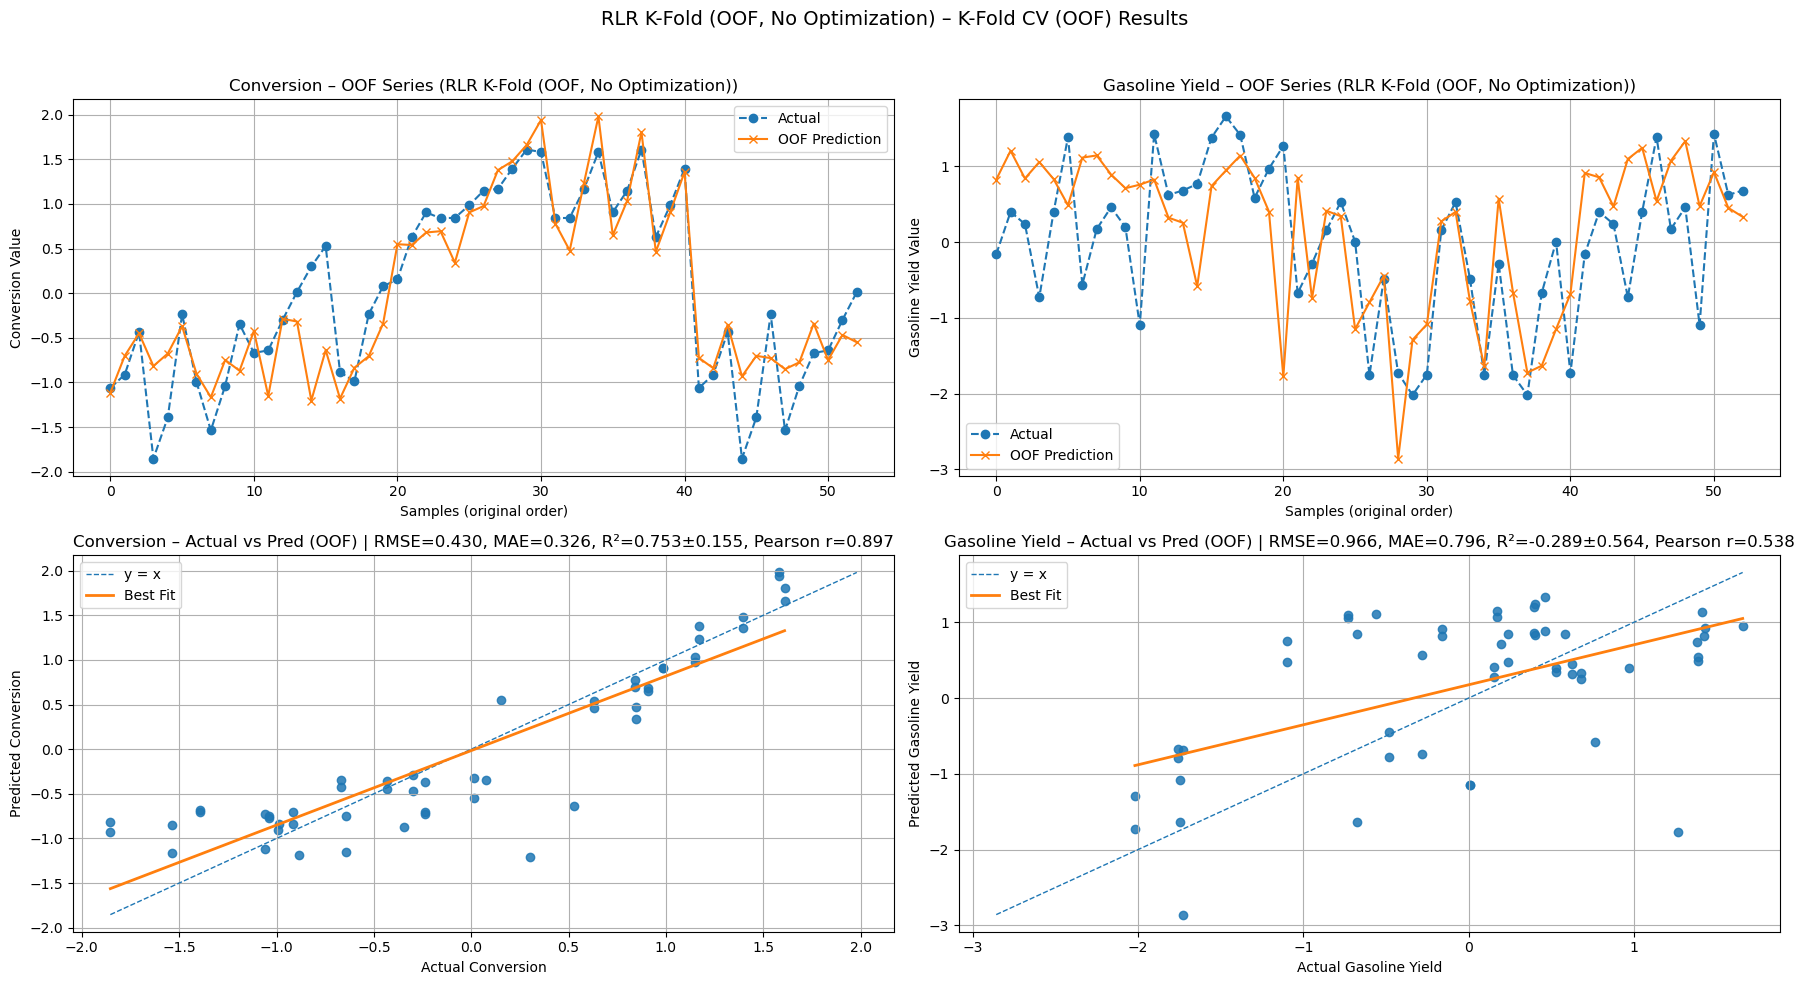

In [50]:
# ---------- Plotting ----------
_ = plot_kfold_subplots(
    y1_true=y1,
    y1_oof_pred=y1_oof_RLR,
    y2_true=y2,
    y2_oof_pred=y2_oof_RLR,

    model_name="RLR K-Fold (OOF, No Optimization)",
    t1_name="Conversion",
    t2_name="Gasoline Yield",

    # --- Conversion metrics ---
    cv_rmse1=cv_rmse1_RLR,
    cv_mae1=np.mean(mae_list1_RLR),
    cv_r21=np.mean(r2_list1_RLR),
    cv_r21_std=np.std(r2_list1_RLR),

    # --- Gasoline Yield metrics ---
    cv_rmse2=cv_rmse2_RLR,
    cv_mae2=np.mean(mae_list2_RLR),
    cv_r22=np.mean(r2_list2_RLR),
    cv_r22_std=np.std(r2_list2_RLR),

    save=True,
    show=True
)

# RLR-BO

In [51]:
# =============================
# RLR_BO — RANSAC (Robust Linear) + Bayesian Optimization
# PURE K-Fold CV (RMSE/MAE/R² + Pearson r + OOF)
# =============================

# ---------- Settings ----------
SEED = 42
N_SPLITS = 5
N_BO_CALLS = 30

# BO search space
space = [
    Integer(50, 500, name="max_trials"),
    Real(1e-5, 0.10, name="min_samples"),   # fraction (0–1]
]

# ---------- Utilities ----------
from scipy.stats import pearsonr

def ensure_2d_X(X):
    if isinstance(X, pd.Series):
        return X.to_frame()
    if isinstance(X, pd.DataFrame):
        return X
    X = np.asarray(X)
    if X.ndim == 1:
        return pd.DataFrame(X, columns=["x0"])
    return pd.DataFrame(X)

def ensure_1d_y(y):
    return pd.Series(np.ravel(np.asarray(y)))

def _regression_metrics(y_true, y_pred):
    y_true = np.ravel(np.asarray(y_true))
    y_pred = np.ravel(np.asarray(y_pred))
    r2   = r2_score(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    return r2, rmse, mae

# ---------- RLR Model Constructor ----------
def make_RLR_BO(max_trials, min_samples):
    """Unified constructor for RANSAC + LinearRegression across sklearn versions."""
    params = dict(
        max_trials=int(max_trials),
        min_samples=float(min_samples),
        residual_threshold=None,
        random_state=SEED,
    )
    try:
        return RANSACRegressor(estimator=LinearRegression(), **params)
    except TypeError:
        return RANSACRegressor(base_estimator=LinearRegression(), **params)

# ---------- K-Fold CV (RMSE/MAE/R² + Pearson r + OOF) ----------
def kfold_cv_with_oof_RLR_BO(
    X, y, max_trials, min_samples,
    n_splits=N_SPLITS, random_state=SEED,
    return_pearson=False          # <-- NEW FLAG
):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    rmse_list, mae_list, r2_list = [], [], []
    pearson_list = []             # <-- NEW
    y_oof = pd.Series(index=y.index, dtype=float)

    for tr_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        model = make_RLR_BO(max_trials, min_samples)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        # Store OOF
        y_oof.iloc[val_idx] = y_pred

        # Metrics
        r2, rmse, mae = _regression_metrics(y_val, y_pred)
        r_p, _ = pearsonr(y_val, y_pred)     # <-- NEW

        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)
        pearson_list.append(float(r_p))       # <-- NEW

    mean_rmse = float(np.mean(rmse_list))

    if return_pearson:
        return mean_rmse, rmse_list, mae_list, r2_list, y_oof, pearson_list
    else:
        return mean_rmse, rmse_list, mae_list, r2_list, y_oof


# ---------- Data ----------
X1 = ensure_2d_X(full_X_conversion)
y1 = ensure_1d_y(full_y_conversion)

X2 = ensure_2d_X(full_X_gasoline)
y2 = ensure_1d_y(full_y_gasoline)


# ---------- BO objectives ----------
@use_named_args(space)
def objective_conv(max_trials, min_samples):
    mean_rmse, _, _, _, _ = kfold_cv_with_oof_RLR_BO(
        X1, y1, max_trials, min_samples
    )
    return mean_rmse  # minimize RMSE


@use_named_args(space)
def objective_yield(max_trials, min_samples):
    mean_rmse, _, _, _, _ = kfold_cv_with_oof_RLR_BO(
        X2, y2, max_trials, min_samples
    )
    return mean_rmse  # minimize RMSE

In [52]:
# ============================================================
# RUNNING RLR_BO — Bayesian Optimization + PURE K-Fold CV
# ============================================================

print("\n=== RLR_BO K-Fold CV: Conversion ===")

res1_RLR_BO = gp_minimize(
    objective_conv, space,
    n_calls=N_BO_CALLS,
    random_state=SEED
)

best_conv_RLR_BO = res1_RLR_BO.x   # [max_trials, min_samples]

(
    cv_rmse1_RLR_BO,
    rmse_list1_RLR_BO,
    mae_list1_RLR_BO,
    r2_list1_RLR_BO,
    y1_oof_RLR_BO,
    pearson_list1_RLR_BO          # <-- NEW
) = kfold_cv_with_oof_RLR_BO(
    X1, y1, *best_conv_RLR_BO,
    return_pearson=True           # <-- NEW
)

pearson1_mean = float(np.mean(pearson_list1_RLR_BO))
pearson1_std  = float(np.std(pearson_list1_RLR_BO))

print(
    f" Best params (Conversion): max_trials={int(best_conv_RLR_BO[0])}, "
    f"min_samples={best_conv_RLR_BO[1]:.6f}"
)

print(
    f" CV RMSE={cv_rmse1_RLR_BO:.6f} | "
    f"MAE={np.mean(mae_list1_RLR_BO):.6f} | "
    f"R²={np.mean(r2_list1_RLR_BO):.4f}±{np.std(r2_list1_RLR_BO):.4f} | "
    f"Pearson r={pearson1_mean:.4f}±{pearson1_std:.4f}"
)


# ============================================================
# Gasoline Yield
# ============================================================

print("\n=== RLR_BO K-Fold CV: Gasoline Yield ===")

res2_RLR_BO = gp_minimize(
    objective_yield, space,
    n_calls=N_BO_CALLS,
    random_state=SEED
)

best_yield_RLR_BO = res2_RLR_BO.x

(
    cv_rmse2_RLR_BO,
    rmse_list2_RLR_BO,
    mae_list2_RLR_BO,
    r2_list2_RLR_BO,
    y2_oof_RLR_BO,
    pearson_list2_RLR_BO          # <-- NEW
) = kfold_cv_with_oof_RLR_BO(
    X2, y2, *best_yield_RLR_BO,
    return_pearson=True           # <-- NEW
)

pearson2_mean = float(np.mean(pearson_list2_RLR_BO))
pearson2_std  = float(np.std(pearson_list2_RLR_BO))

print(
    f" Best params (Yield): max_trials={int(best_yield_RLR_BO[0])}, "
    f"min_samples={best_yield_RLR_BO[1]:.6f}"
)

print(
    f" CV RMSE={cv_rmse2_RLR_BO:.6f} | "
    f"MAE={np.mean(mae_list2_RLR_BO):.6f} | "
    f"R²={np.mean(r2_list2_RLR_BO):.4f}±{np.std(r2_list2_RLR_BO):.4f} | "
    f"Pearson r={pearson2_mean:.4f}±{pearson2_std:.4f}"
)


# ============================================================
# Saving results
# ============================================================

all_results_rlr_bo_kcv = pd.DataFrame([
    {
        "Dataset": "Conversion",
        "CV_K": N_SPLITS,
        "CV_RMSE_mean": cv_rmse1_RLR_BO,
        "CV_RMSE_std": float(np.std(rmse_list1_RLR_BO)),
        "CV_MAE_mean": float(np.mean(mae_list1_RLR_BO)),
        "CV_MAE_std": float(np.std(mae_list1_RLR_BO)),
        "CV_R2_mean": float(np.mean(r2_list1_RLR_BO)),
        "CV_R2_std": float(np.std(r2_list1_RLR_BO)),
        "CV_Pearson_r_mean": pearson1_mean,     # <-- NEW
        "CV_Pearson_r_std": pearson1_std,       # <-- NEW
        "Best_max_trials": int(best_conv_RLR_BO[0]),
        "Best_min_samples": float(best_conv_RLR_BO[1]),
    },
    {
        "Dataset": "Gasoline Yield",
        "CV_K": N_SPLITS,
        "CV_RMSE_mean": cv_rmse2_RLR_BO,
        "CV_RMSE_std": float(np.std(rmse_list2_RLR_BO)),
        "CV_MAE_mean": float(np.mean(mae_list2_RLR_BO)),
        "CV_MAE_std": float(np.std(mae_list2_RLR_BO)),
        "CV_R2_mean": float(np.mean(r2_list2_RLR_BO)),
        "CV_R2_std": float(np.std(r2_list2_RLR_BO)),
        "CV_Pearson_r_mean": pearson2_mean,     # <-- NEW
        "CV_Pearson_r_std": pearson2_std,       # <-- NEW
        "Best_max_trials": int(best_yield_RLR_BO[0]),
        "Best_min_samples": float(best_yield_RLR_BO[1]),
    }
])

print("\n📊 RLR_BO K-Fold CV Summary:")
print(all_results_rlr_bo_kcv)

all_results_rlr_bo_kcv.to_csv("RLR_BO_kfold_cv_metrics.csv", index=False)


=== RLR_BO K-Fold CV: Conversion ===
 Best params (Conversion): max_trials=257, min_samples=0.033378
 CV RMSE=0.407609 | MAE=0.327268 | R²=0.7904±0.1117 | Pearson r=0.9259±0.0393

=== RLR_BO K-Fold CV: Gasoline Yield ===
 Best params (Yield): max_trials=401, min_samples=0.059689
 CV RMSE=0.855846 | MAE=0.653424 | R²=0.0293±0.2949 | Pearson r=0.5408±0.3846

📊 RLR_BO K-Fold CV Summary:
          Dataset  CV_K  CV_RMSE_mean  CV_RMSE_std  CV_MAE_mean  CV_MAE_std  \
0      Conversion     5      0.407609     0.112390     0.327268    0.082256   
1  Gasoline Yield     5      0.855846     0.081156     0.653424    0.090194   

   CV_R2_mean  CV_R2_std  CV_Pearson_r_mean  CV_Pearson_r_std  \
0    0.790351   0.111683           0.925886          0.039258   
1    0.029347   0.294921           0.540774          0.384600   

   Best_max_trials  Best_min_samples  
0              257          0.033378  
1              401          0.059689  


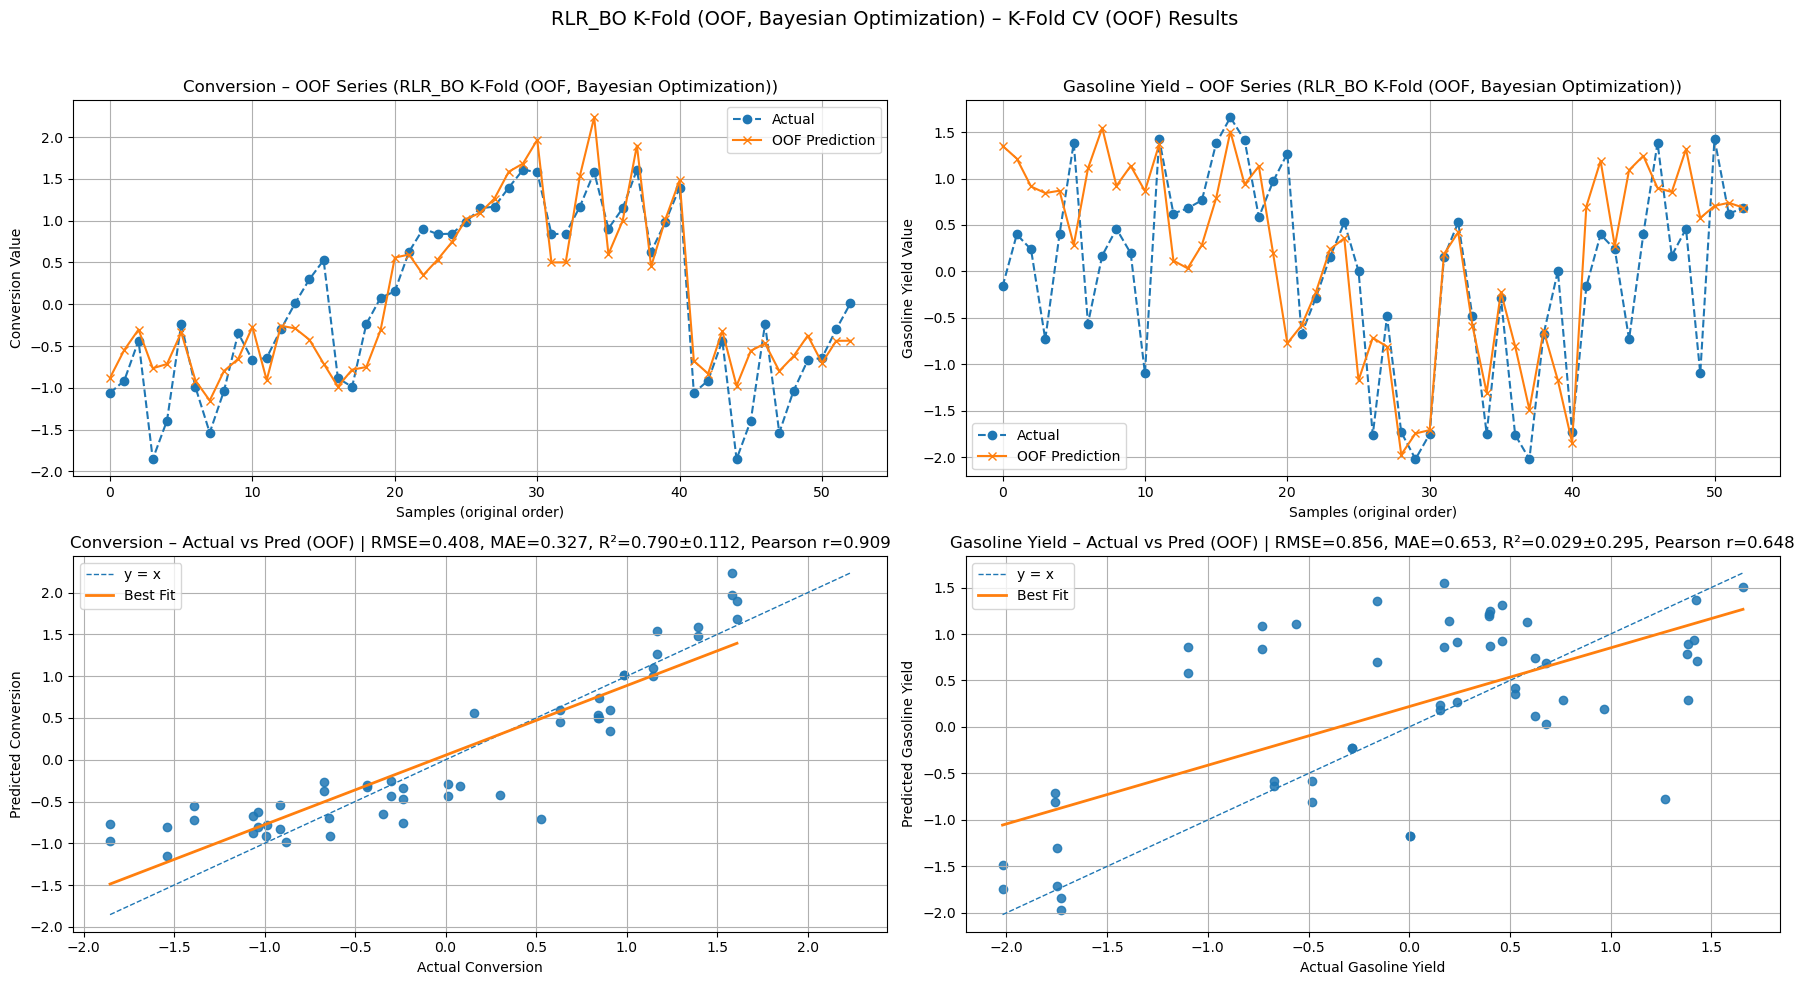

In [53]:
# ---------- Plotting ----------
_ = plot_kfold_subplots(
    y1_true=y1, 
    y1_oof_pred=y1_oof_RLR_BO,
    y2_true=y2, 
    y2_oof_pred=y2_oof_RLR_BO,

    model_name="RLR_BO K-Fold (OOF, Bayesian Optimization)",
    t1_name="Conversion",
    t2_name="Gasoline Yield",

    # --- Conversion metrics ---
    cv_rmse1=cv_rmse1_RLR_BO,
    cv_mae1=np.mean(mae_list1_RLR_BO),
    cv_r21=np.mean(r2_list1_RLR_BO),
    cv_r21_std=np.std(r2_list1_RLR_BO),

    # --- Gasoline Yield metrics ---
    cv_rmse2=cv_rmse2_RLR_BO,
    cv_mae2=np.mean(mae_list2_RLR_BO),
    cv_r22=np.mean(r2_list2_RLR_BO),
    cv_r22_std=np.std(r2_list2_RLR_BO),

    save=True,
    show=True
)

# Model Evaluation

In [54]:
# ================================================
# Helper to reshape a model's run lists into rows
# ================================================
def build_run_rows(model_name, bo_flag, target_name,
                   rmse_list, mae_list, r2_list, pearson_list):
    """
    bo_flag should be "Yes" or "No"
    pearson_list must match fold order
    """
    rows = []
    n = len(rmse_list)
    for i in range(n):
        rows.append({
            "Model": model_name,
            "BO": bo_flag,         # "Yes" or "No"
            "Target": target_name,
            "Fold": i + 1,         # nicer fold numbering
            "RMSE": float(rmse_list[i]),
            "MAE": float(mae_list[i]),
            "R2": float(r2_list[i]),
            "Pearson_r": float(pearson_list[i])   # <-- NEW
        })
    return rows


# ================================================
# Compute Pearson r per fold for every model run
# ================================================
def compute_pearson_list(y_true, y_oof):
    """
    Computes fold-level Pearson r from OOF predictions.
    We split based on unique folds in the OOF index order.
    """
    r_list = []
    # The folds are in order of y_oof being filled
    # So split by equal length of folds
    fold_size = len(y_oof) // 5  # assuming K=5
    for i in range(5):
        start = i * fold_size
        end = (i + 1) * fold_size
        r, _ = pearsonr(y_true[start:end], y_oof[start:end])
        r_list.append(r)
    return r_list


# ================================================
# Build Pearson lists for all models
# ================================================

# GPR Non-BO
pearson_list1_GPR  = compute_pearson_list(y1_GPR, y1_oof_GPR)
pearson_list2_GPR  = compute_pearson_list(y2_GPR, y2_oof_GPR)

# BT Non-BO
pearson_list1_GBR  = compute_pearson_list(y1_GBR, y1_oof_GBR)
pearson_list2_GBR  = compute_pearson_list(y2_GBR, y2_oof_GBR)

# RLR Non-BO
pearson_list1_RLR  = compute_pearson_list(y1, y1_oof_RLR)
pearson_list2_RLR  = compute_pearson_list(y2, y2_oof_RLR)

# GPR BO
pearson_list1_GPR_BO = compute_pearson_list(y1_GPR, y1_oof_GPR_BO)
pearson_list2_GPR_BO = compute_pearson_list(y2_GPR, y2_oof_GPR_BO)

# BT BO
pearson_list1_GBR_BO = compute_pearson_list(y1_GBR, y1_oof_GBR_BO)
pearson_list2_GBR_BO = compute_pearson_list(y2_GBR, y2_oof_GBR_BO)

# RLR BO
pearson_list1_RLR_BO = compute_pearson_list(y1, y1_oof_RLR_BO)
pearson_list2_RLR_BO = compute_pearson_list(y2, y2_oof_RLR_BO)


# ================================================
# Collect rows for all models
# ================================================
all_rows = []

# ---- Conversion NON-BO ----
all_rows += build_run_rows("GPR", "No",  "Conversion", rmse_list1_GPR, mae_list1_GPR, r2_list1_GPR, pearson_list1_GPR)
all_rows += build_run_rows("BT",  "No",  "Conversion", rmse_list1_GBR, mae_list1_GBR, r2_list1_GBR, pearson_list1_GBR)
all_rows += build_run_rows("RLR", "No",  "Conversion", rmse_list1_RLR, mae_list1_RLR, r2_list1_RLR, pearson_list1_RLR)

# ---- Conversion BO ----
all_rows += build_run_rows("GPR", "Yes", "Conversion", rmse_list1_GPR_BO, mae_list1_GPR_BO, r2_list1_GPR_BO, pearson_list1_GPR_BO)
all_rows += build_run_rows("BT",  "Yes", "Conversion", rmse_list1_GBR_BO, mae_list1_GBR_BO, r2_list1_GBR_BO, pearson_list1_GBR_BO)
all_rows += build_run_rows("RLR", "Yes", "Conversion", rmse_list1_RLR_BO, mae_list1_RLR_BO, r2_list1_RLR_BO, pearson_list1_RLR_BO)

# ---- Gasoline Yield NON-BO ----
all_rows += build_run_rows("GPR", "No",  "Gasoline Yield", rmse_list2_GPR, mae_list2_GPR, r2_list2_GPR, pearson_list2_GPR)
all_rows += build_run_rows("BT",  "No",  "Gasoline Yield", rmse_list2_GBR, mae_list2_GBR, r2_list2_GBR, pearson_list2_GBR)
all_rows += build_run_rows("RLR", "No",  "Gasoline Yield", rmse_list2_RLR, mae_list2_RLR, r2_list2_RLR, pearson_list2_RLR)

# ---- Gasoline Yield BO ----
all_rows += build_run_rows("GPR", "Yes", "Gasoline Yield", rmse_list2_GPR_BO, mae_list2_GPR_BO, r2_list2_GPR_BO, pearson_list2_GPR_BO)
all_rows += build_run_rows("BT",  "Yes", "Gasoline Yield", rmse_list2_GBR_BO, mae_list2_GBR_BO, r2_list2_GBR_BO, pearson_list2_GBR_BO)
all_rows += build_run_rows("RLR", "Yes", "Gasoline Yield", rmse_list2_RLR_BO, mae_list2_RLR_BO, r2_list2_RLR_BO, pearson_list2_RLR_BO)

# ================================================
# Final DataFrame
# ================================================
run_level_df = pd.DataFrame(all_rows)

print(run_level_df.head())
print(f"\nTotal rows: {run_level_df.shape[0]}")

run_level_df.to_csv("run_level_kfold_results_vgo.csv", index=False)

  Model  BO      Target  Fold      RMSE       MAE        R2  Pearson_r
0   GPR  No  Conversion     1  0.240706  0.205314  0.893195   0.736921
1   GPR  No  Conversion     2  0.422065  0.249805  0.881759   0.296271
2   GPR  No  Conversion     3  0.495086  0.343475  0.706499   0.641794
3   GPR  No  Conversion     4  0.301673  0.176654  0.916157   0.791624
4   GPR  No  Conversion     5  0.689865  0.383399  0.279291   0.948195

Total rows: 60


In [55]:
# =============================================================
# FULL STATISTICAL COMPARISON TABLE
# RMSE / MAE / R² / Pearson r
# =============================================================
#---------------------------------------
# Helper: compute mean + 95% CI
# -------------------------------------------------------------
def mean_ci(arr):
    arr = np.array(arr)
    mean = arr.mean()
    ci = 1.96 * arr.std() / np.sqrt(len(arr))
    return mean, ci

# -------------------------------------------------------------
# Main function: run paired stats for RMSE, MAE, R2, Pearson r
# -------------------------------------------------------------
def run_stats(
    rmse1, rmse2,
    mae1, mae2,
    r21, r22,
    p1, p2,
    comparison_name,
    target_name
):
    rmse1 = np.array(rmse1); rmse2 = np.array(rmse2)
    mae1  = np.array(mae1);  mae2  = np.array(mae2)
    r21   = np.array(r21);   r22   = np.array(r22)
    p1    = np.array(p1);    p2    = np.array(p2)

    # ---- RMSE ----
    rmse1_mean, rmse1_ci = mean_ci(rmse1)
    rmse2_mean, rmse2_ci = mean_ci(rmse2)
    rmse_t = ttest_rel(rmse1, rmse2).pvalue
    try: rmse_w = wilcoxon(rmse1, rmse2).pvalue
    except: rmse_w = np.nan

    # ---- MAE ----
    mae1_mean, mae1_ci = mean_ci(mae1)
    mae2_mean, mae2_ci = mean_ci(mae2)
    mae_t = ttest_rel(mae1, mae2).pvalue
    try: mae_w = wilcoxon(mae1, mae2).pvalue
    except: mae_w = np.nan

    # ---- R² ----
    r21_mean, r21_ci = mean_ci(r21)
    r22_mean, r22_ci = mean_ci(r22)
    r2_t = ttest_rel(r21, r22).pvalue
    try: r2_w = wilcoxon(r21, r22).pvalue
    except: r2_w = np.nan

    # ---- Pearson r ----
    p1_mean, p1_ci = mean_ci(p1)
    p2_mean, p2_ci = mean_ci(p2)
    p_t = ttest_rel(p1, p2).pvalue
    try: p_w = wilcoxon(p1, p2).pvalue
    except: p_w = np.nan

    return {
        "Target": target_name,
        "Comparison": comparison_name,

        # RMSE
        "RMSE_Model1": rmse1_mean,
        "RMSE_Model2": rmse2_mean,
        "RMSE_CI_Model1": rmse1_ci,
        "RMSE_CI_Model2": rmse2_ci,
        "RMSE_ttest_p": rmse_t,
        "RMSE_wilcoxon_p": rmse_w,

        # MAE
        "MAE_Model1": mae1_mean,
        "MAE_Model2": mae2_mean,
        "MAE_CI_Model1": mae1_ci,
        "MAE_CI_Model2": mae2_ci,
        "MAE_ttest_p": mae_t,
        "MAE_wilcoxon_p": mae_w,

        # R2
        "R2_Model1": r21_mean,
        "R2_Model2": r22_mean,
        "R2_CI_Model1": r21_ci,
        "R2_CI_Model2": r22_ci,
        "R2_ttest_p": r2_t,
        "R2_wilcoxon_p": r2_w,

        # Pearson r
        "Pearson_Model1": p1_mean,
        "Pearson_Model2": p2_mean,
        "Pearson_CI_Model1": p1_ci,
        "Pearson_CI_Model2": p2_ci,
        "Pearson_ttest_p": p_t,
        "Pearson_wilcoxon_p": p_w,
    }


# =============================================================
# BUILD THE TABLE (ALL 12 COMPARISONS)
# =============================================================

stats_rows = []

# ---------- Conversion: NON-BO ----------
stats_rows.append(run_stats(
    rmse_list1_GPR, rmse_list1_GBR,
    mae_list1_GPR,  mae_list1_GBR,
    r2_list1_GPR,   r2_list1_GBR,
    pearson_list1_GPR, pearson_list1_GBR,
    "GPR vs GBR (non-BO)", "Conversion"
))

stats_rows.append(run_stats(
    rmse_list1_GPR, rmse_list1_RLR,
    mae_list1_GPR,  mae_list1_RLR,
    r2_list1_GPR,   r2_list1_RLR,
    pearson_list1_GPR, pearson_list1_RLR,
    "GPR vs RLR (non-BO)", "Conversion"
))

stats_rows.append(run_stats(
    rmse_list1_GBR, rmse_list1_RLR,
    mae_list1_GBR,  mae_list1_RLR,
    r2_list1_GBR,   r2_list1_RLR,
    pearson_list1_GBR, pearson_list1_RLR,
    "GBR vs RLR (non-BO)", "Conversion"
))

# ---------- Gasoline Yield: NON-BO ----------
stats_rows.append(run_stats(
    rmse_list2_GPR, rmse_list2_GBR,
    mae_list2_GPR,  mae_list2_GBR,
    r2_list2_GPR,   r2_list2_GBR,
    pearson_list2_GPR, pearson_list2_GBR,
    "GPR vs GBR (non-BO)", "Gasoline Yield"
))

stats_rows.append(run_stats(
    rmse_list2_GPR, rmse_list2_RLR,
    mae_list2_GPR,  mae_list2_RLR,
    r2_list2_GPR,   r2_list2_RLR,
    pearson_list2_GPR, pearson_list2_RLR,
    "GPR vs RLR (non-BO)", "Gasoline Yield"
))

stats_rows.append(run_stats(
    rmse_list2_GBR, rmse_list2_RLR,
    mae_list2_GBR,  mae_list2_RLR,
    r2_list2_GBR,   r2_list2_RLR,
    pearson_list2_GBR, pearson_list2_RLR,
    "GBR vs RLR (non-BO)", "Gasoline Yield"
))

# ---------- Conversion: BO ----------
stats_rows.append(run_stats(
    rmse_list1_GPR_BO, rmse_list1_GBR_BO,
    mae_list1_GPR_BO,  mae_list1_GBR_BO,
    r2_list1_GPR_BO,   r2_list1_GBR_BO,
    pearson_list1_GPR_BO, pearson_list1_GBR_BO,
    "GPR vs GBR (BO)", "Conversion"
))

stats_rows.append(run_stats(
    rmse_list1_GPR_BO, rmse_list1_RLR_BO,
    mae_list1_GPR_BO,  mae_list1_RLR_BO,
    r2_list1_GPR_BO,   r2_list1_RLR_BO,
    pearson_list1_GPR_BO, pearson_list1_RLR_BO,
    "GPR vs RLR (BO)", "Conversion"
))

stats_rows.append(run_stats(
    rmse_list1_GBR_BO, rmse_list1_RLR_BO,
    mae_list1_GBR_BO,  mae_list1_RLR_BO,
    r2_list1_GBR_BO,   r2_list1_RLR_BO,
    pearson_list1_GBR_BO, pearson_list1_RLR_BO,
    "GBR vs RLR (BO)", "Conversion"
))

# ---------- Gasoline Yield: BO ----------
stats_rows.append(run_stats(
    rmse_list2_GPR_BO, rmse_list2_GBR_BO,
    mae_list2_GPR_BO,  mae_list2_GBR_BO,
    r2_list2_GPR_BO,   r2_list2_GBR_BO,
    pearson_list2_GPR_BO, pearson_list2_GBR_BO,
    "GPR vs GBR (BO)", "Gasoline Yield"
))

stats_rows.append(run_stats(
    rmse_list2_GPR_BO, rmse_list2_RLR_BO,
    mae_list2_GPR_BO,  mae_list2_RLR_BO,
    r2_list2_GPR_BO,   r2_list2_RLR_BO,
    pearson_list2_GPR_BO, pearson_list2_RLR_BO,
    "GPR vs RLR (BO)", "Gasoline Yield"
))

stats_rows.append(run_stats(
    rmse_list2_GBR_BO, rmse_list2_RLR_BO,
    mae_list2_GBR_BO,  mae_list2_RLR_BO,
    r2_list2_GBR_BO,   r2_list2_RLR_BO,
    pearson_list2_GBR_BO, pearson_list2_RLR_BO,
    "GBR vs RLR (BO)", "Gasoline Yield"
))

# ---- Final Table ----
stats_df = pd.DataFrame(stats_rows)
print(stats_df)


            Target           Comparison  RMSE_Model1  RMSE_Model2  \
0       Conversion  GPR vs GBR (non-BO)     0.429879     0.166880   
1       Conversion  GPR vs RLR (non-BO)     0.429879     0.429821   
2       Conversion  GBR vs RLR (non-BO)     0.166880     0.429821   
3   Gasoline Yield  GPR vs GBR (non-BO)     0.779369     0.577636   
4   Gasoline Yield  GPR vs RLR (non-BO)     0.779369     0.966084   
5   Gasoline Yield  GBR vs RLR (non-BO)     0.577636     0.966084   
6       Conversion      GPR vs GBR (BO)     0.199316     0.187450   
7       Conversion      GPR vs RLR (BO)     0.199316     0.407609   
8       Conversion      GBR vs RLR (BO)     0.187450     0.407609   
9   Gasoline Yield      GPR vs GBR (BO)     0.356423     0.571373   
10  Gasoline Yield      GPR vs RLR (BO)     0.356423     0.855846   
11  Gasoline Yield      GBR vs RLR (BO)     0.571373     0.855846   

    RMSE_CI_Model1  RMSE_CI_Model2  RMSE_ttest_p  RMSE_wilcoxon_p  MAE_Model1  \
0         0.138109   

In [56]:
print(stats_df[["Target", "Comparison"]])

            Target           Comparison
0       Conversion  GPR vs GBR (non-BO)
1       Conversion  GPR vs RLR (non-BO)
2       Conversion  GBR vs RLR (non-BO)
3   Gasoline Yield  GPR vs GBR (non-BO)
4   Gasoline Yield  GPR vs RLR (non-BO)
5   Gasoline Yield  GBR vs RLR (non-BO)
6       Conversion      GPR vs GBR (BO)
7       Conversion      GPR vs RLR (BO)
8       Conversion      GBR vs RLR (BO)
9   Gasoline Yield      GPR vs GBR (BO)
10  Gasoline Yield      GPR vs RLR (BO)
11  Gasoline Yield      GBR vs RLR (BO)


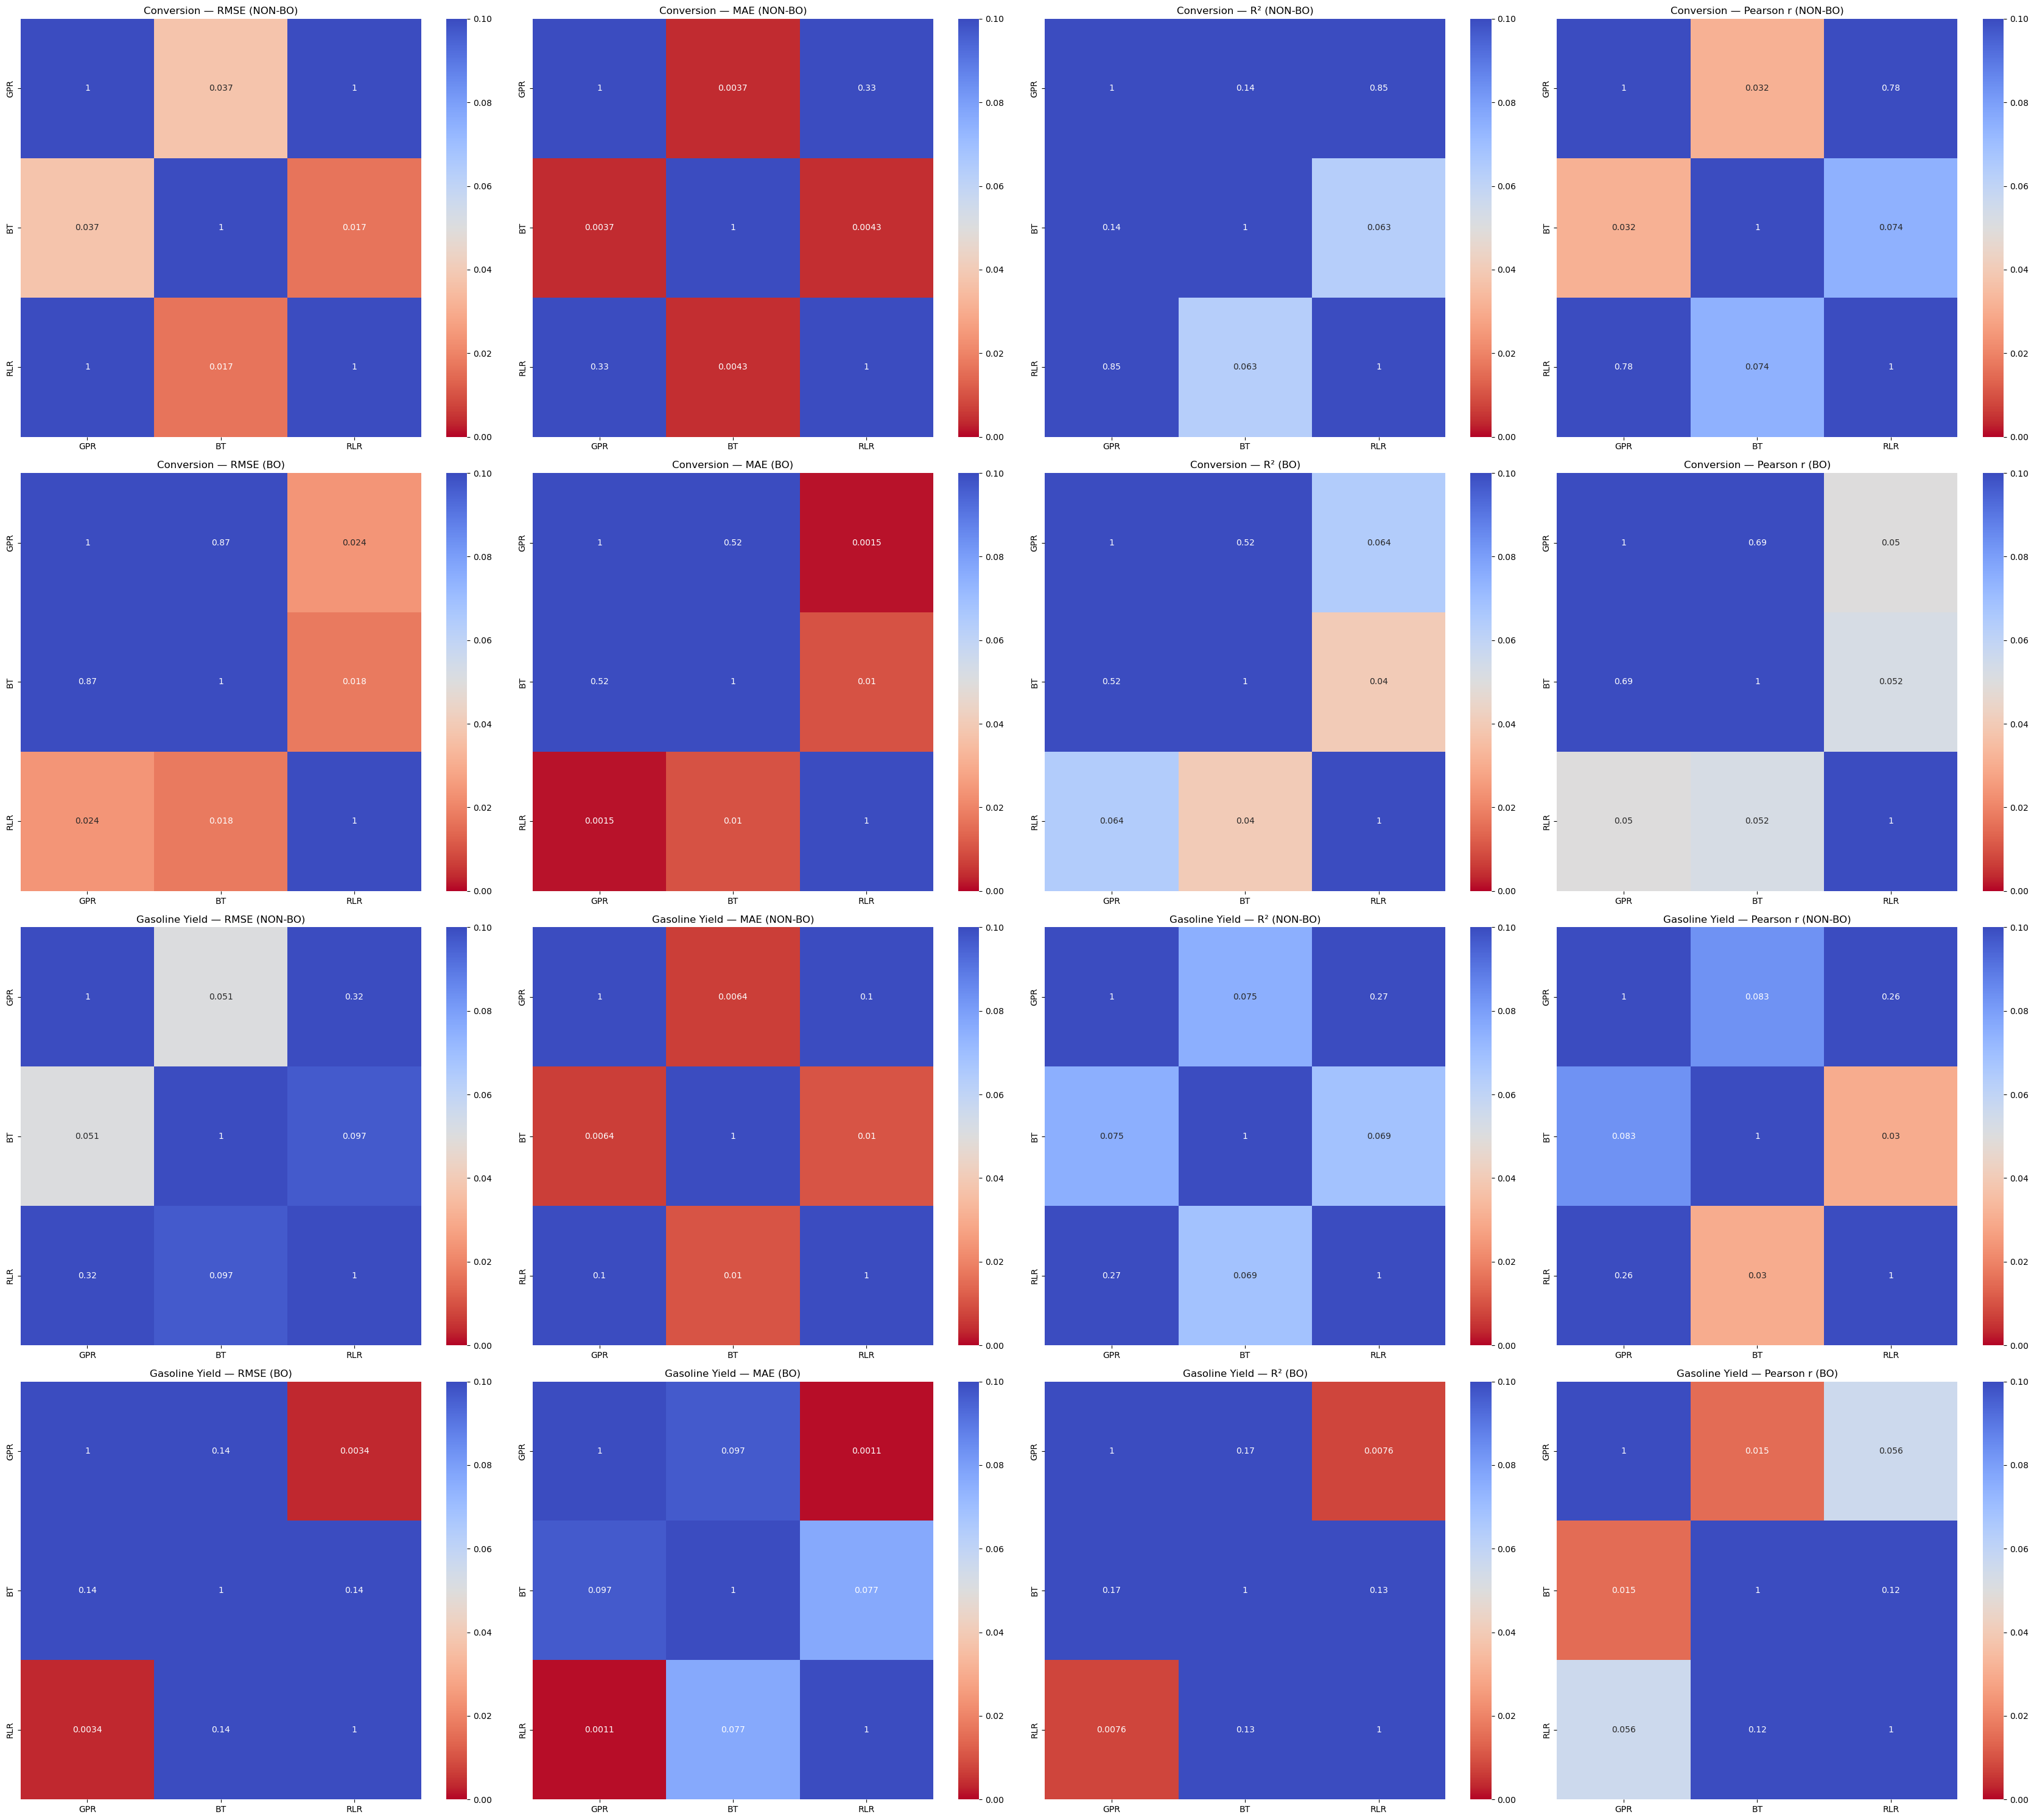

In [57]:
# =============================================================
# Add Pearson matrices
# =============================================================

# =============================================================
# Helper: Build 3×3 p-value matrix
# =============================================================
def pair_matrix(metric_dict):

    model_order = ["GPR", "BT", "RLR"]

    mat = pd.DataFrame(
        np.ones((3,3)),
        index=model_order,
        columns=model_order
    )

    # Compute pairwise p-values
    for m1, m2 in [("GPR","BT"), ("GPR","RLR"), ("BT","RLR")]:
        arr1 = np.array(metric_dict[m1], dtype=float)
        arr2 = np.array(metric_dict[m2], dtype=float)

        # SAFE p-value: if identical arrays, return 1.0
        if np.allclose(arr1, arr2):
            p = 1.0
        else:
            p = ttest_rel(arr1, arr2).pvalue

        mat.loc[m1, m2] = p
        mat.loc[m2, m1] = p

    return mat


# ---- Conversion NON-BO ----
mat_conv_rmse_non = pair_matrix({"GPR": rmse_list1_GPR, "BT": rmse_list1_GBR, "RLR": rmse_list1_RLR})
mat_conv_mae_non  = pair_matrix({"GPR": mae_list1_GPR,  "BT": mae_list1_GBR,  "RLR": mae_list1_RLR})
mat_conv_r2_non   = pair_matrix({"GPR": r2_list1_GPR,   "BT": r2_list1_GBR,   "RLR": r2_list1_RLR})
mat_conv_r_non = pair_matrix({"GPR": pearson_list1_GPR, "BT": pearson_list1_GBR, "RLR": pearson_list1_RLR})

# ---- Conversion BO ----
mat_conv_rmse_bo = pair_matrix({"GPR": rmse_list1_GPR_BO, "BT": rmse_list1_GBR_BO, "RLR": rmse_list1_RLR_BO})
mat_conv_mae_bo  = pair_matrix({"GPR": mae_list1_GPR_BO,  "BT": mae_list1_GBR_BO,  "RLR": mae_list1_RLR_BO})
mat_conv_r2_bo   = pair_matrix({"GPR": r2_list1_GPR_BO,   "BT": r2_list1_GBR_BO,   "RLR": r2_list1_RLR_BO})
mat_conv_r_bo = pair_matrix({"GPR": pearson_list1_GPR_BO, "BT": pearson_list1_GBR_BO, "RLR": pearson_list1_RLR_BO})

# ---- Yield NON-BO ----
mat_yield_rmse_non = pair_matrix({"GPR": rmse_list2_GPR, "BT": rmse_list2_GBR, "RLR": rmse_list2_RLR})
mat_yield_mae_non  = pair_matrix({"GPR": mae_list2_GPR,  "BT": mae_list2_GBR,  "RLR": mae_list2_RLR})
mat_yield_r2_non   = pair_matrix({"GPR": r2_list2_GPR,   "BT": r2_list2_GBR,   "RLR": r2_list2_RLR})
mat_yield_r_non = pair_matrix({"GPR": pearson_list2_GPR, "BT": pearson_list2_GBR, "RLR": pearson_list2_RLR})

# ---- Yield BO ----
mat_yield_rmse_bo = pair_matrix({"GPR": rmse_list2_GPR_BO, "BT": rmse_list2_GBR_BO, "RLR": rmse_list2_RLR_BO})
mat_yield_mae_bo  = pair_matrix({"GPR": mae_list2_GPR_BO,  "BT": mae_list2_GBR_BO,  "RLR": mae_list2_RLR_BO})
mat_yield_r2_bo   = pair_matrix({"GPR": r2_list2_GPR_BO,   "BT": r2_list2_GBR_BO,   "RLR": r2_list2_RLR_BO})
mat_yield_r_bo = pair_matrix({"GPR": pearson_list2_GPR_BO, "BT": pearson_list2_GBR_BO, "RLR": pearson_list2_RLR_BO})


# =============================================================
# PLOT — 4 rows × 4 columns now (added Pearson r)
# =============================================================

fig, axes = plt.subplots(4, 4, figsize=(34, 30))
heatmap_settings = dict(annot=True, cmap="coolwarm_r", vmin=0, vmax=0.1)

# ---- Row 1: Conversion NON-BO ----
sns.heatmap(mat_conv_rmse_non, ax=axes[0,0], **heatmap_settings)
axes[0,0].set_title("Conversion — RMSE (NON-BO)")

sns.heatmap(mat_conv_mae_non, ax=axes[0,1], **heatmap_settings)
axes[0,1].set_title("Conversion — MAE (NON-BO)")

sns.heatmap(mat_conv_r2_non, ax=axes[0,2], **heatmap_settings)
axes[0,2].set_title("Conversion — R² (NON-BO)")

sns.heatmap(mat_conv_r_non, ax=axes[0,3], **heatmap_settings)
axes[0,3].set_title("Conversion — Pearson r (NON-BO)")

# ---- Row 2: Conversion BO ----
sns.heatmap(mat_conv_rmse_bo, ax=axes[1,0], **heatmap_settings)
axes[1,0].set_title("Conversion — RMSE (BO)")

sns.heatmap(mat_conv_mae_bo, ax=axes[1,1], **heatmap_settings)
axes[1,1].set_title("Conversion — MAE (BO)")

sns.heatmap(mat_conv_r2_bo, ax=axes[1,2], **heatmap_settings)
axes[1,2].set_title("Conversion — R² (BO)")

sns.heatmap(mat_conv_r_bo, ax=axes[1,3], **heatmap_settings)
axes[1,3].set_title("Conversion — Pearson r (BO)")

# ---- Row 3: Yield NON-BO ----
sns.heatmap(mat_yield_rmse_non, ax=axes[2,0], **heatmap_settings)
axes[2,0].set_title("Gasoline Yield — RMSE (NON-BO)")

sns.heatmap(mat_yield_mae_non, ax=axes[2,1], **heatmap_settings)
axes[2,1].set_title("Gasoline Yield — MAE (NON-BO)")

sns.heatmap(mat_yield_r2_non, ax=axes[2,2], **heatmap_settings)
axes[2,2].set_title("Gasoline Yield — R² (NON-BO)")

sns.heatmap(mat_yield_r_non, ax=axes[2,3], **heatmap_settings)
axes[2,3].set_title("Gasoline Yield — Pearson r (NON-BO)")

# ---- Row 4: Yield BO ----
sns.heatmap(mat_yield_rmse_bo, ax=axes[3,0], **heatmap_settings)
axes[3,0].set_title("Gasoline Yield — RMSE (BO)")

sns.heatmap(mat_yield_mae_bo, ax=axes[3,1], **heatmap_settings)
axes[3,1].set_title("Gasoline Yield — MAE (BO)")

sns.heatmap(mat_yield_r2_bo, ax=axes[3,2], **heatmap_settings)
axes[3,2].set_title("Gasoline Yield — R² (BO)")

sns.heatmap(mat_yield_r_bo, ax=axes[3,3], **heatmap_settings)
axes[3,3].set_title("Gasoline Yield — Pearson r (BO)")

plt.tight_layout()
plt.savefig("FULL_16_PANEL_PVALUE_MATRIX_W_PEARSON.png", dpi=300, bbox_inches="tight")
plt.show()

In [58]:
# =============================================================
# BUILD ALL DICTIONARIES FOR HEATMAPS
# (RMSE, MAE, R², Pearson — Conversion + Yield, NON-BO + BO)
# =============================================================

models = ["GPR", "BT", "RLR"]

# =============================================================
# Conversion — NON-BO
# =============================================================
conv_non_bo_rmse = {
    "GPR": rmse_list1_GPR,
    "BT":  rmse_list1_GBR,
    "RLR": rmse_list1_RLR
}

conv_non_bo_mae = {
    "GPR": mae_list1_GPR,
    "BT":  mae_list1_GBR,
    "RLR": mae_list1_RLR
}

conv_non_bo_r2 = {
    "GPR": r2_list1_GPR,
    "BT":  r2_list1_GBR,
    "RLR": r2_list1_RLR
}

conv_non_bo_pearson = {
    "GPR": pearson_list1_GPR,
    "BT":  pearson_list1_GBR,
    "RLR": pearson_list1_RLR
}


# =============================================================
# Conversion — BO
# =============================================================
conv_bo_rmse = {
    "GPR": rmse_list1_GPR_BO,
    "BT":  rmse_list1_GBR_BO,
    "RLR": rmse_list1_RLR_BO
}

conv_bo_mae = {
    "GPR": mae_list1_GPR_BO,
    "BT":  mae_list1_GBR_BO,
    "RLR": mae_list1_RLR_BO
}

conv_bo_r2 = {
    "GPR": r2_list1_GPR_BO,
    "BT":  r2_list1_GBR_BO,
    "RLR": r2_list1_RLR_BO
}

conv_bo_pearson = {
    "GPR": pearson_list1_GPR_BO,
    "BT":  pearson_list1_GBR_BO,
    "RLR": pearson_list1_RLR_BO
}


# =============================================================
# Gasoline Yield — NON-BO
# =============================================================
yield_non_bo_rmse = {
    "GPR": rmse_list2_GPR,
    "BT":  rmse_list2_GBR,
    "RLR": rmse_list2_RLR
}

yield_non_bo_mae = {
    "GPR": mae_list2_GPR,
    "BT":  mae_list2_GBR,
    "RLR": mae_list2_RLR
}

yield_non_bo_r2 = {
    "GPR": r2_list2_GPR,
    "BT":  r2_list2_GBR,
    "RLR": r2_list2_RLR
}

yield_non_bo_pearson = {
    "GPR": pearson_list2_GPR,
    "BT":  pearson_list2_GBR,
    "RLR": pearson_list2_RLR
}


# =============================================================
# Gasoline Yield — BO
# =============================================================
yield_bo_rmse = {
    "GPR": rmse_list2_GPR_BO,
    "BT":  rmse_list2_GBR_BO,
    "RLR": r2_list2_RLR_BO
}

yield_bo_mae = {
    "GPR": mae_list2_GPR_BO,
    "BT":  mae_list2_GBR_BO,
    "RLR": mae_list2_RLR_BO
}

yield_bo_r2 = {
    "GPR": r2_list2_GPR_BO,
    "BT":  r2_list2_GBR_BO,
    "RLR": r2_list2_RLR_BO
}

yield_bo_pearson = {
    "GPR": pearson_list2_GPR_BO,
    "BT":  pearson_list2_GBR_BO,
    "RLR": pearson_list2_RLR_BO
}


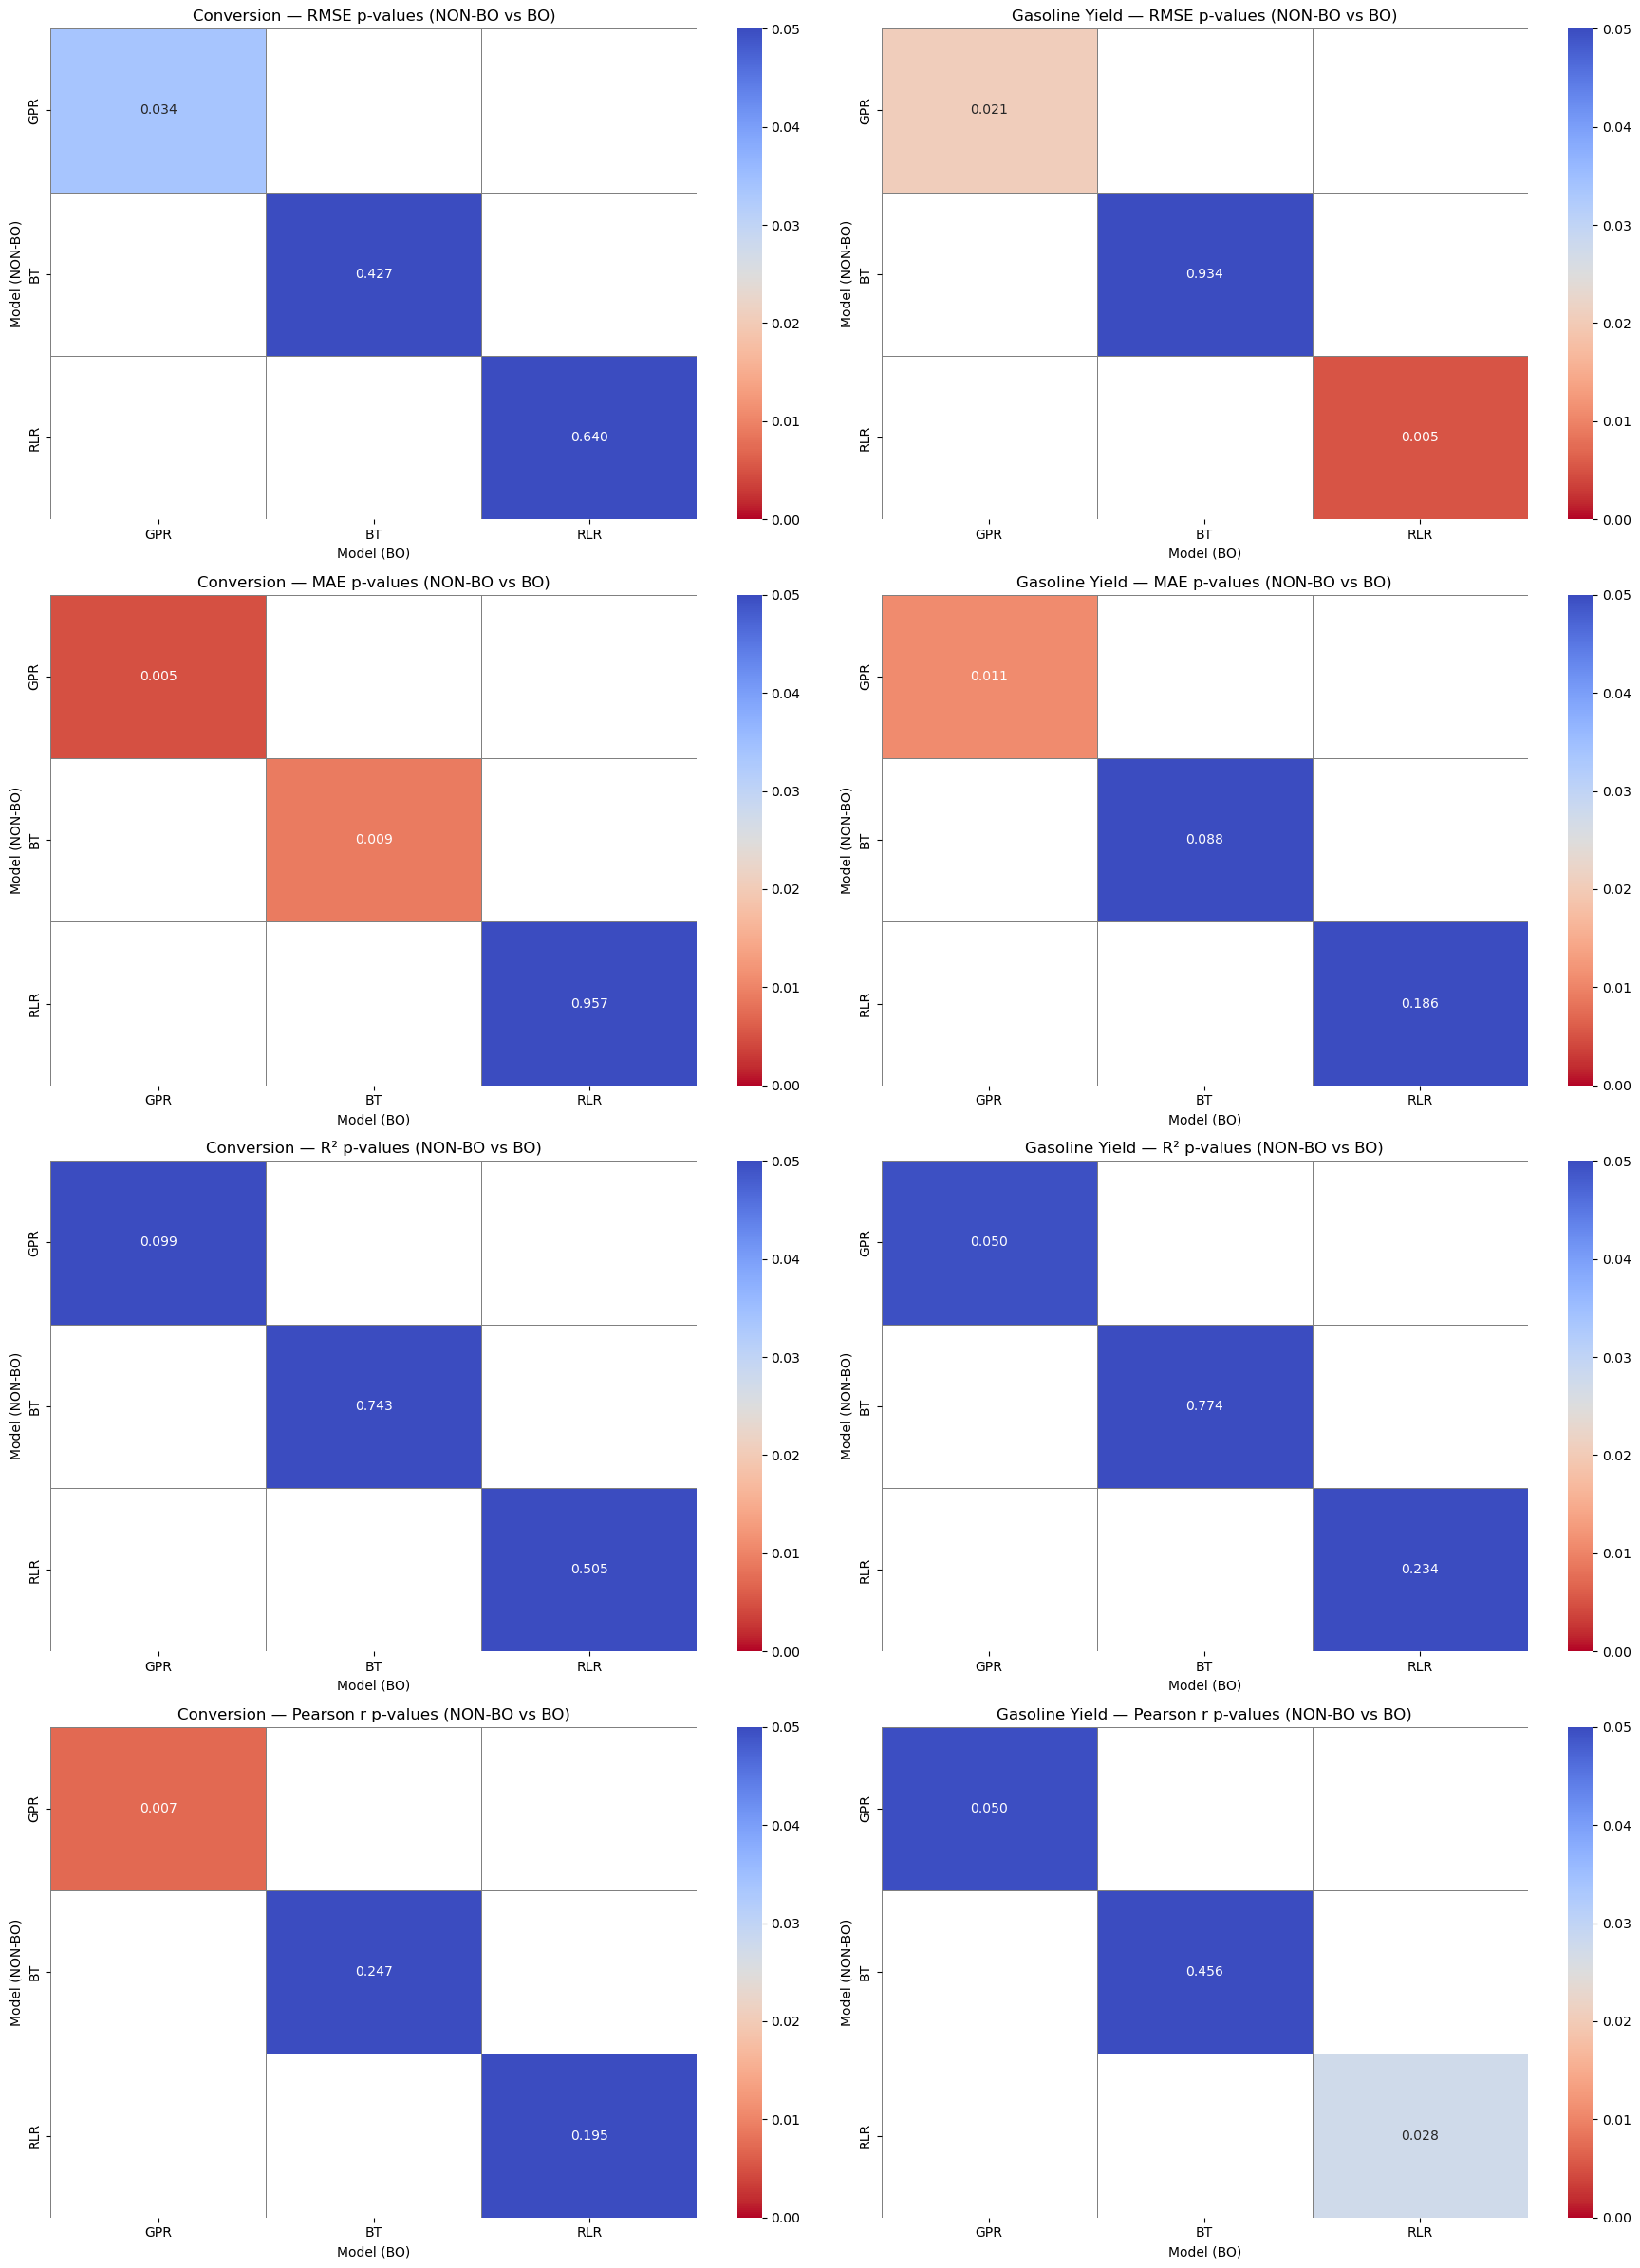

In [59]:
# =============================================================
# HELPER: Create p-value matrix WITH "no improvement" text
# =============================================================

def model_pvalue_matrix(metric_non_bo, metric_bo):
    """
    metric_non_bo and metric_bo are dicts:
        { "GPR": [...], "BT": [...], "RLR": [...] }
    Each array must be fold-level metrics.
    """
    numeric_mat = pd.DataFrame(np.nan, index=models, columns=models)
    annot_mat   = pd.DataFrame("",    index=models, columns=models)

    for m in models:
        arr1 = np.array(metric_non_bo[m], dtype=float)
        arr2 = np.array(metric_bo[m], dtype=float)

        # Case: no change between Non-BO and BO
        if np.allclose(arr1, arr2, equal_nan=True):
            numeric_mat.loc[m, m] = 0.051     # visible tile
            annot_mat.loc[m, m]   = "no improvement"
        else:
            p = ttest_rel(arr1, arr2, nan_policy='omit').pvalue
            numeric_mat.loc[m, m] = p
            annot_mat.loc[m, m]   = f"{p:.3f}"

    return numeric_mat, annot_mat

# =============================================================
# BUILD ALL 8 MATRICES (numeric + annot)
# =============================================================


# ---- RMSE ----
rmse_conv_num,   rmse_conv_annot   = model_pvalue_matrix(conv_non_bo_rmse,   conv_bo_rmse)
rmse_yield_num,  rmse_yield_annot  = model_pvalue_matrix(yield_non_bo_rmse,  yield_bo_rmse)

# ---- MAE ----
mae_conv_num,    mae_conv_annot    = model_pvalue_matrix(conv_non_bo_mae,    conv_bo_mae)
mae_yield_num,   mae_yield_annot   = model_pvalue_matrix(yield_non_bo_mae,   yield_bo_mae)

# ---- R² ----
r2_conv_num,     r2_conv_annot     = model_pvalue_matrix(conv_non_bo_r2,     conv_bo_r2)
r2_yield_num,    r2_yield_annot    = model_pvalue_matrix(yield_non_bo_r2,    yield_bo_r2)

# ---- ⭐ NEW: Pearson r ----
pearson_conv_num,  pearson_conv_annot  = model_pvalue_matrix(conv_non_bo_pearson,  conv_bo_pearson)
pearson_yield_num, pearson_yield_annot = model_pvalue_matrix(yield_non_bo_pearson, yield_bo_pearson)


# =============================================================
# HELPER: plotting function
# =============================================================
def draw_heatmap(num_mat, annot_mat, ax, title):
    sns.heatmap(
        num_mat,
        annot=annot_mat,
        fmt="",                     # allows text annotations
        cmap="coolwarm_r",
        vmin=0,
        vmax=0.05,
        linewidths=0.5,
        linecolor="gray",
        cbar=True,
        ax=ax
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Model (BO)")
    ax.set_ylabel("Model (NON-BO)")


# =============================================================
# DRAW FIGURE (4 rows × 2 columns: RMSE, MAE, R², Pearson)
# =============================================================
fig, axes = plt.subplots(4, 2, figsize=(18, 24))

# ---- Row 1: RMSE ----
draw_heatmap(rmse_conv_num,  rmse_conv_annot,  axes[0,0],
             "Conversion — RMSE p-values (NON-BO vs BO)")
draw_heatmap(rmse_yield_num, rmse_yield_annot, axes[0,1],
             "Gasoline Yield — RMSE p-values (NON-BO vs BO)")

# ---- Row 2: MAE ----
draw_heatmap(mae_conv_num,  mae_conv_annot,  axes[1,0],
             "Conversion — MAE p-values (NON-BO vs BO)")
draw_heatmap(mae_yield_num, mae_yield_annot, axes[1,1],
             "Gasoline Yield — MAE p-values (NON-BO vs BO)")

# ---- Row 3: R² ----
draw_heatmap(r2_conv_num,  r2_conv_annot,  axes[2,0],
             "Conversion — R² p-values (NON-BO vs BO)")
draw_heatmap(r2_yield_num, r2_yield_annot, axes[2,1],
             "Gasoline Yield — R² p-values (NON-BO vs BO)")

# ---- ⭐ Row 4: Pearson r ----
draw_heatmap(pearson_conv_num,  pearson_conv_annot,  axes[3,0],
             "Conversion — Pearson r p-values (NON-BO vs BO)")
draw_heatmap(pearson_yield_num, pearson_yield_annot, axes[3,1],
             "Gasoline Yield — Pearson r p-values (NON-BO vs BO)")

plt.tight_layout()
plt.savefig("pvalues_BO_vs_NONBO_RMSE_MAE_R2_PEARSON_full.png",
            dpi=300, bbox_inches="tight")
plt.show()

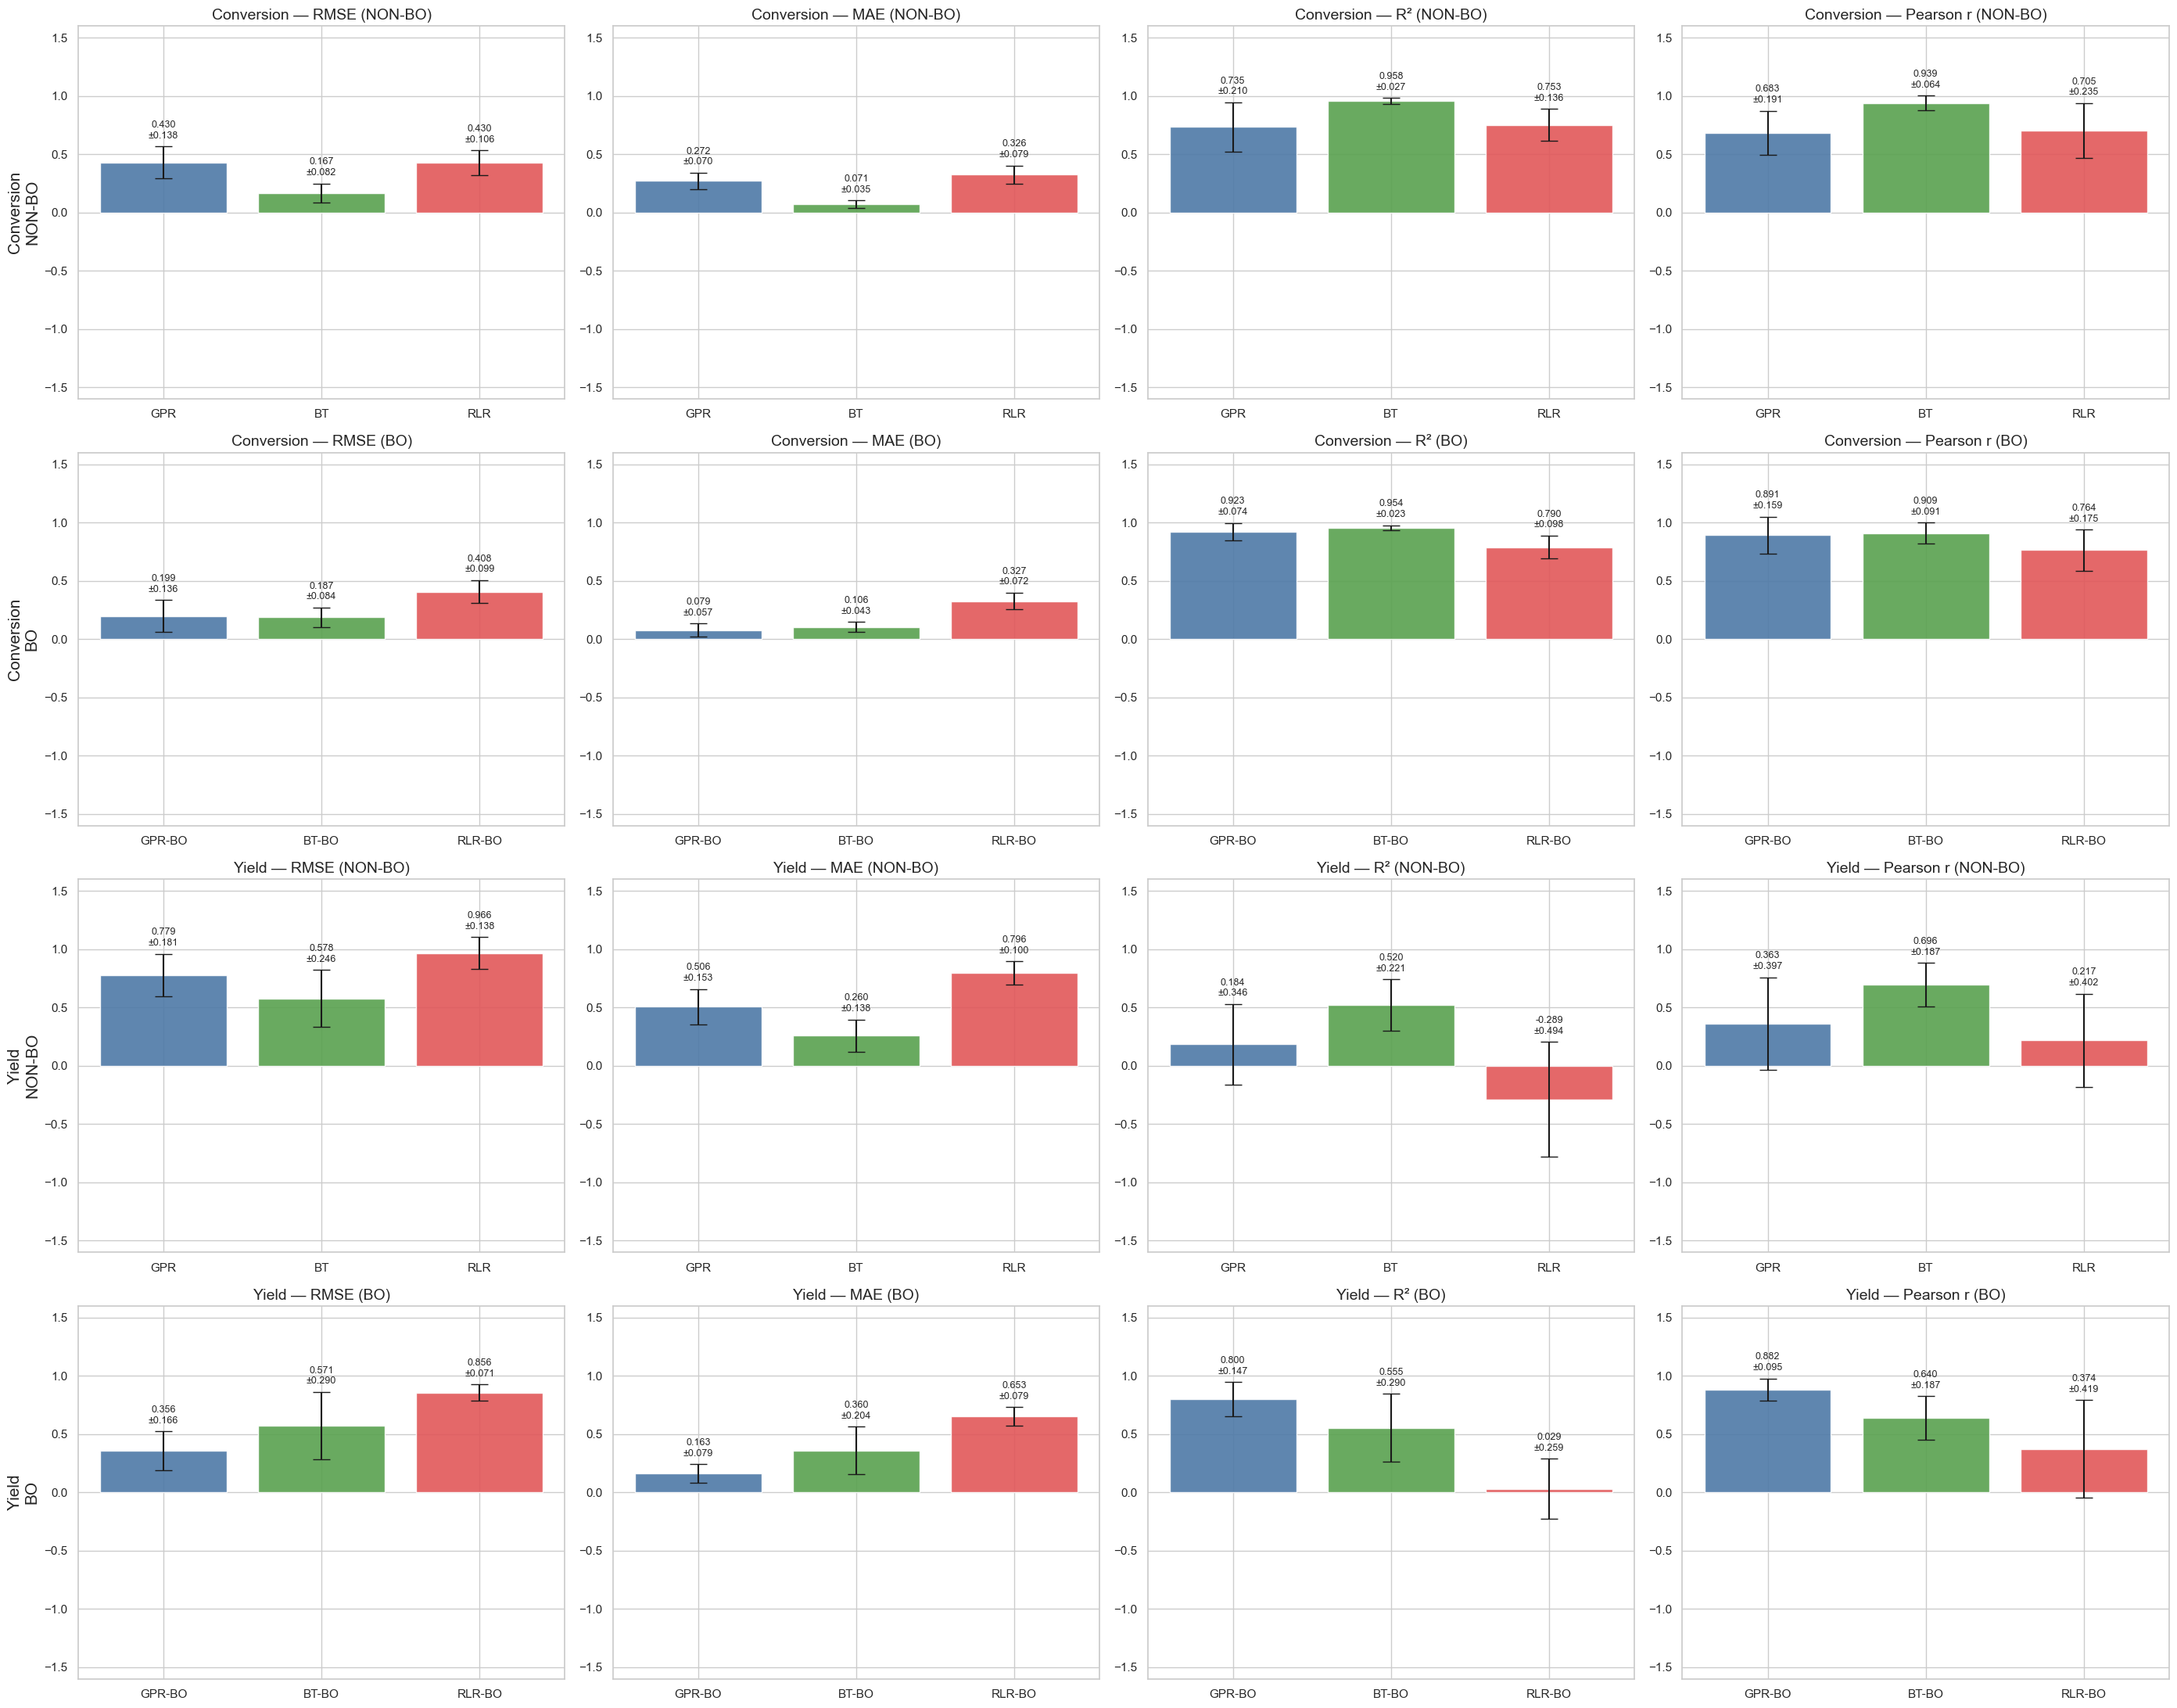

In [60]:
# =============================================================
# 4×4 FULL METRIC COMPARISON (Annotated: means + 95% CI)
# =============================================================

sns.set(style="whitegrid")

# -------------------------------------------------------------
# Helper: mean + 95% CI
# -------------------------------------------------------------
def mean_ci(arr):
    arr = np.array(arr)
    mean = np.mean(arr)
    ci = 1.96 * np.std(arr) / np.sqrt(len(arr))
    return mean, ci

# -------------------------------------------------------------
# SAFE PLOT PANEL with bounding fixes (same as 16-subplot version)
# -------------------------------------------------------------
def plot_panel(ax, lists_dict, title):
    models = list(lists_dict.keys())

    means, cis = [], []
    for m in models:
        mean, ci = mean_ci(lists_dict[m])
        means.append(mean)
        cis.append(ci)

    # ----- plot bars -----
    bars = ax.bar(
        models, means, yerr=cis, capsize=8,
        color=["#4E79A7", "#59A14F", "#E15759"], alpha=0.9
    )

    # fixed bounds
    ymin, ymax = -1.6, 1.6
    ax.set_ylim(ymin, ymax)
    margin = 0.05

    # ----- annotation with overflow protection -----
    for bar, mean, ci in zip(bars, means, cis):
        intended_y = mean + ci
        txt = f"{mean:.3f}\n±{ci:.3f}"

        # clamp label inside boundaries
        if intended_y > ymax:
            y_annot = ymax - margin
            txt += "\n(actual above limit)"
        elif intended_y < ymin:
            y_annot = ymin + margin
            txt += "\n(actual below limit)"
        else:
            y_annot = intended_y + margin

        x = bar.get_x() + bar.get_width() / 2

        ax.text(
            x, y_annot,
            txt,
            ha="center", va="bottom", fontsize=9
        )

    ax.set_title(title, fontsize=14)


# -------------------------------------------------------------
# RAW LISTS (GBR renamed to BT)
# -------------------------------------------------------------

# ---- Conversion NON-BO ----
rmse_conv_non_bo = {"GPR": rmse_list1_GPR, 
                    "BT":  rmse_list1_GBR, 
                    "RLR": rmse_list1_RLR}

mae_conv_non_bo  = {"GPR": mae_list1_GPR, 
                    "BT":  mae_list1_GBR, 
                    "RLR": mae_list1_RLR}

r2_conv_non_bo   = {"GPR": r2_list1_GPR,  
                    "BT":  r2_list1_GBR,  
                    "RLR": r2_list1_RLR}

pearson_conv_non_bo = {"GPR": pearson_list1_GPR,
                       "BT":  pearson_list1_GBR,
                       "RLR": pearson_list1_RLR}

# ---- Conversion BO ----
rmse_conv_bo = {"GPR-BO": rmse_list1_GPR_BO,
                "BT-BO":  rmse_list1_GBR_BO,
                "RLR-BO": rmse_list1_RLR_BO}

mae_conv_bo  = {"GPR-BO": mae_list1_GPR_BO,
                "BT-BO":  mae_list1_GBR_BO,
                "RLR-BO": mae_list1_RLR_BO}

r2_conv_bo   = {"GPR-BO": r2_list1_GPR_BO,
                "BT-BO":  r2_list1_GBR_BO,
                "RLR-BO": r2_list1_RLR_BO}

pearson_conv_bo = {"GPR-BO": pearson_list1_GPR_BO,
                   "BT-BO":  pearson_list1_GBR_BO,
                   "RLR-BO": pearson_list1_RLR_BO}

# ---- Yield NON-BO ----
rmse_yield_non_bo = {"GPR": rmse_list2_GPR, 
                     "BT":  rmse_list2_GBR, 
                     "RLR": rmse_list2_RLR}

mae_yield_non_bo  = {"GPR": mae_list2_GPR, 
                     "BT":  mae_list2_GBR, 
                     "RLR": mae_list2_RLR}

r2_yield_non_bo   = {"GPR": r2_list2_GPR,  
                     "BT":  r2_list2_GBR,  
                     "RLR": r2_list2_RLR}

pearson_yield_non_bo = {"GPR": pearson_list2_GPR,
                        "BT":  pearson_list2_GBR,
                        "RLR": pearson_list2_RLR}

# ---- Yield BO ----
rmse_yield_bo = {"GPR-BO": rmse_list2_GPR_BO,
                 "BT-BO":  rmse_list2_GBR_BO,
                 "RLR-BO": rmse_list2_RLR_BO}

mae_yield_bo  = {"GPR-BO": mae_list2_GPR_BO,
                 "BT-BO":  mae_list2_GBR_BO,
                 "RLR-BO": mae_list2_RLR_BO}

r2_yield_bo   = {"GPR-BO": r2_list2_GPR_BO,
                 "BT-BO":  r2_list2_GBR_BO,
                 "RLR-BO": r2_list2_RLR_BO}

pearson_yield_bo = {"GPR-BO": pearson_list2_GPR_BO,
                    "BT-BO":  pearson_list2_GBR_BO,
                    "RLR-BO": pearson_list2_RLR_BO}


# -------------------------------------------------------------
# Build the 4×4 Figure (added Pearson r column)
# -------------------------------------------------------------
fig, axes = plt.subplots(4, 4, figsize=(28, 22))

# ----- Row 1: Conversion NON-BO -----
plot_panel(axes[0,0], rmse_conv_non_bo,   "Conversion — RMSE (NON-BO)")
plot_panel(axes[0,1], mae_conv_non_bo,    "Conversion — MAE (NON-BO)")
plot_panel(axes[0,2], r2_conv_non_bo,     "Conversion — R² (NON-BO)")
plot_panel(axes[0,3], pearson_conv_non_bo,"Conversion — Pearson r (NON-BO)")
axes[0,0].set_ylabel("Conversion\nNON-BO", fontsize=15)

# ----- Row 2: Conversion BO -----
plot_panel(axes[1,0], rmse_conv_bo,   "Conversion — RMSE (BO)")
plot_panel(axes[1,1], mae_conv_bo,    "Conversion — MAE (BO)")
plot_panel(axes[1,2], r2_conv_bo,     "Conversion — R² (BO)")
plot_panel(axes[1,3], pearson_conv_bo,"Conversion — Pearson r (BO)")
axes[1,0].set_ylabel("Conversion\nBO", fontsize=15)

# ----- Row 3: Yield NON-BO -----
plot_panel(axes[2,0], rmse_yield_non_bo,   "Yield — RMSE (NON-BO)")
plot_panel(axes[2,1], mae_yield_non_bo,    "Yield — MAE (NON-BO)")
plot_panel(axes[2,2], r2_yield_non_bo,     "Yield — R² (NON-BO)")
plot_panel(axes[2,3], pearson_yield_non_bo,"Yield — Pearson r (NON-BO)")
axes[2,0].set_ylabel("Yield\nNON-BO", fontsize=15)

# ----- Row 4: Yield BO -----
plot_panel(axes[3,0], rmse_yield_bo,   "Yield — RMSE (BO)")
plot_panel(axes[3,1], mae_yield_bo,    "Yield — MAE (BO)")
plot_panel(axes[3,2], r2_yield_bo,     "Yield — R² (BO)")
plot_panel(axes[3,3], pearson_yield_bo,"Yield — Pearson r (BO)")
axes[3,0].set_ylabel("Yield\nBO", fontsize=15)

plt.tight_layout()
plt.savefig("FULL_4x4_METRIC_COMPARISON_CI_WITH_PEARSON.png", dpi=300, bbox_inches="tight")
plt.show()

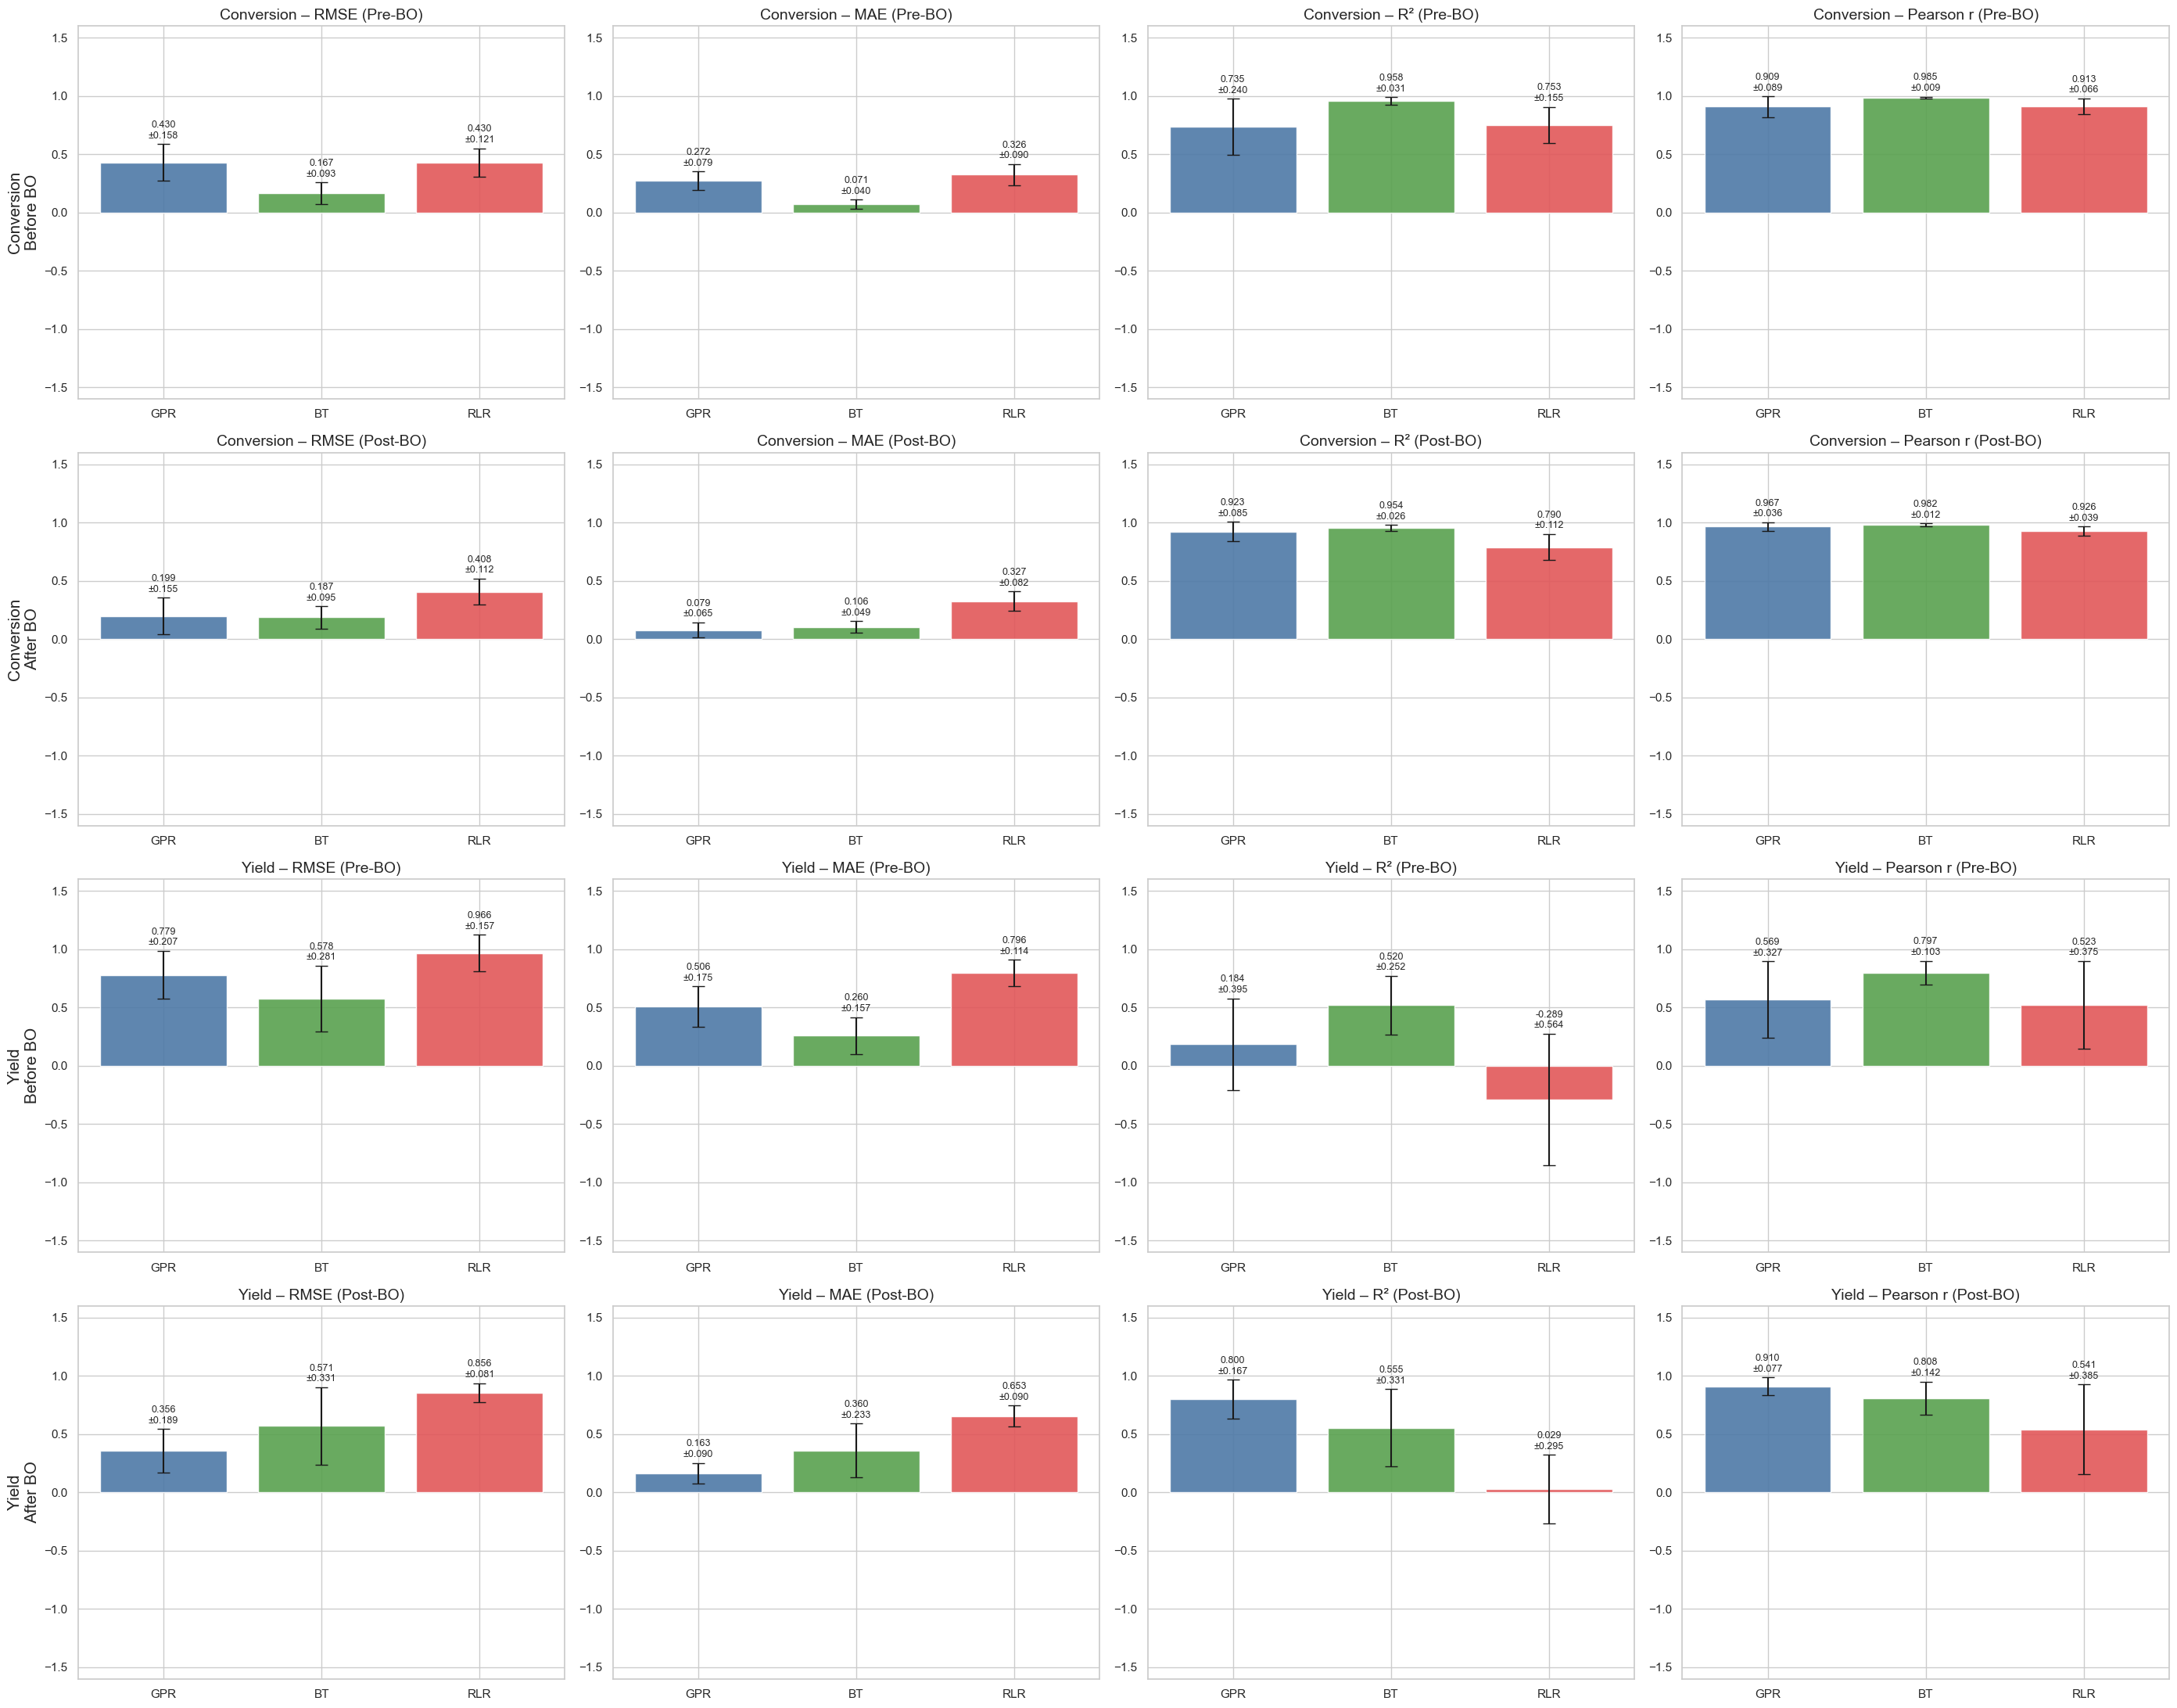

In [61]:
# =============================================================
# 16-subplot CV metric comparison (Before BO + After BO)
# RMSE / MAE / R² / Pearson r
# =============================================================

sns.set(style="whitegrid")

# =============================================================
# Helper: extract CV_RMSE / MAE / R2 / Pearson means & std
# =============================================================
def extract_all_metrics(df_gpr, df_bt, df_rlr, target_name):

    dfs = {"GPR": df_gpr, "BT": df_bt, "RLR": df_rlr}

    out_rmse_mean = {}
    out_rmse_std  = {}
    out_mae_mean  = {}
    out_mae_std   = {}
    out_r2_mean   = {}
    out_r2_std    = {}
    out_p_mean    = {}
    out_p_std     = {}

    for model, df in dfs.items():
        row = df[df["Dataset"] == target_name].iloc[0]

        out_rmse_mean[model] = float(row["CV_RMSE_mean"])
        out_rmse_std[model]  = float(row["CV_RMSE_std"])

        out_mae_mean[model] = float(row["CV_MAE_mean"])
        out_mae_std[model]  = float(row["CV_MAE_std"])

        out_r2_mean[model] = float(row["CV_R2_mean"])
        out_r2_std[model]  = float(row["CV_R2_std"])

        # Pearson columns
        if ("CV_Pearson_r_mean" in row.index) and ("CV_Pearson_r_std" in row.index):
            out_p_mean[model] = float(row["CV_Pearson_r_mean"])
            out_p_std[model]  = float(row["CV_Pearson_r_std"])
        else:
            out_p_mean[model] = 0.0
            out_p_std[model]  = 0.0

    return (
        out_rmse_mean, out_rmse_std,
        out_mae_mean,  out_mae_std,
        out_r2_mean,   out_r2_std,
        out_p_mean,    out_p_std
    )

# =============================================================
# EXTRACT BEFORE BO
# =============================================================
(
    conv_rmse_mean_pre, conv_rmse_std_pre,
    conv_mae_mean_pre,  conv_mae_std_pre,
    conv_r2_mean_pre,   conv_r2_std_pre,
    conv_p_mean_pre,    conv_p_std_pre
) = extract_all_metrics(
    gpr_no_bo_kcv, all_results_gbr_kcv, all_results_ransac_kcv_noopt,
    "Conversion"
)

(
    y_rmse_mean_pre, y_rmse_std_pre,
    y_mae_mean_pre,  y_mae_std_pre,
    y_r2_mean_pre,   y_r2_std_pre,
    y_p_mean_pre,    y_p_std_pre
) = extract_all_metrics(
    gpr_no_bo_kcv, all_results_gbr_kcv, all_results_ransac_kcv_noopt,
    "Gasoline Yield"
)

# =============================================================
# EXTRACT AFTER BO
# =============================================================
(
    conv_rmse_mean_bo, conv_rmse_std_bo,
    conv_mae_mean_bo,  conv_mae_std_bo,
    conv_r2_mean_bo,   conv_r2_std_bo,
    conv_p_mean_bo,    conv_p_std_bo
) = extract_all_metrics(
    all_results_full, all_results_gbr_bo_kcv, all_results_rlr_bo_kcv,
    "Conversion"
)

(
    y_rmse_mean_bo, y_rmse_std_bo,
    y_mae_mean_bo,  y_mae_std_bo,
    y_r2_mean_bo,   y_r2_std_bo,
    y_p_mean_bo,    y_p_std_bo
) = extract_all_metrics(
    all_results_full, all_results_gbr_bo_kcv, all_results_rlr_bo_kcv,
    "Gasoline Yield"
)

# =============================================================
# FIXED plot helper (mean_dict, std_dict, title)
# =============================================================
def plot_metric(ax, mean_dict, std_dict, title):
    models = list(mean_dict.keys())
    means = [mean_dict[m] for m in models]
    stds  = [std_dict[m] for m in models]

    bars = ax.bar(
        models, means, yerr=stds, capsize=6,
        color=["#4E79A7", "#59A14F", "#E15759"], alpha=0.9
    )

    ax.set_ylim(-1.6, 1.6)
    margin = 0.05

    for bar, mean, std in zip(bars, means, stds):
        x = bar.get_x() + bar.get_width()/2
        text_y = min(max(mean + std + margin, -1.6 + margin), 1.6 - margin)
        txt = f"{mean:.3f}\n±{std:.3f}"
        if mean + std > 1.6: txt += "\n(actual above limit)"
        if mean + std < -1.6: txt += "\n(actual below limit)"

        ax.text(x, text_y, txt, ha="center", fontsize=9)

    ax.set_title(title, fontsize=14)

# =============================================================
# Build 16-subplot figure
# =============================================================
fig, axes = plt.subplots(4, 4, figsize=(28, 22))

plot_metric(axes[0,0], conv_rmse_mean_pre, conv_rmse_std_pre, "Conversion – RMSE (Pre-BO)")
plot_metric(axes[0,1], conv_mae_mean_pre,  conv_mae_std_pre,  "Conversion – MAE (Pre-BO)")
plot_metric(axes[0,2], conv_r2_mean_pre,   conv_r2_std_pre,   "Conversion – R² (Pre-BO)")
plot_metric(axes[0,3], conv_p_mean_pre,    conv_p_std_pre,    "Conversion – Pearson r (Pre-BO)")
axes[0,0].set_ylabel("Conversion\nBefore BO", fontsize=15)

plot_metric(axes[1,0], conv_rmse_mean_bo, conv_rmse_std_bo, "Conversion – RMSE (Post-BO)")
plot_metric(axes[1,1], conv_mae_mean_bo,  conv_mae_std_bo,  "Conversion – MAE (Post-BO)")
plot_metric(axes[1,2], conv_r2_mean_bo,   conv_r2_std_bo,   "Conversion – R² (Post-BO)")
plot_metric(axes[1,3], conv_p_mean_bo,    conv_p_std_bo,    "Conversion – Pearson r (Post-BO)")
axes[1,0].set_ylabel("Conversion\nAfter BO", fontsize=15)

plot_metric(axes[2,0], y_rmse_mean_pre, y_rmse_std_pre, "Yield – RMSE (Pre-BO)")
plot_metric(axes[2,1], y_mae_mean_pre,  y_mae_std_pre,  "Yield – MAE (Pre-BO)")
plot_metric(axes[2,2], y_r2_mean_pre,   y_r2_std_pre,   "Yield – R² (Pre-BO)")
plot_metric(axes[2,3], y_p_mean_pre,    y_p_std_pre,    "Yield – Pearson r (Pre-BO)")
axes[2,0].set_ylabel("Yield\nBefore BO", fontsize=15)

plot_metric(axes[3,0], y_rmse_mean_bo, y_rmse_std_bo, "Yield – RMSE (Post-BO)")
plot_metric(axes[3,1], y_mae_mean_bo,  y_mae_std_bo,  "Yield – MAE (Post-BO)")
plot_metric(axes[3,2], y_r2_mean_bo,   y_r2_std_bo,   "Yield – R² (Post-BO)")
plot_metric(axes[3,3], y_p_mean_bo,    y_p_std_bo,    "Yield – Pearson r (Post-BO)")
axes[3,0].set_ylabel("Yield\nAfter BO", fontsize=15)

plt.tight_layout()
plt.savefig("CV_metrics_16subplot_with_Pearson.png", dpi=300, bbox_inches="tight")
plt.show()

In [62]:
# =============================================================
# MERGE FUNCTION — Combine all K-fold tables into 1 dataframe
# =============================================================

def merge_kfold_results():
    # ---------- Select only these columns ----------
    cols = [
        "Dataset", "CV_K",
        "CV_RMSE_mean", "CV_RMSE_std",
        "CV_MAE_mean",  "CV_MAE_std",
        "CV_R2_mean",   "CV_R2_std"
    ]

    # ---------- Helper: add model + BO flags ----------
    def tag(df, model_name, bo_flag):
        df2 = df.copy()[cols]
        df2["Model"] = model_name
        df2["BO"] = bo_flag
        return df2

    # ---------- Merge all models (NON-BO) ----------
    df_gpr_non_bo = tag(gpr_no_bo_kcv,              "GPR", "NO")
    df_bt_non_bo  = tag(all_results_gbr_kcv,        "BT",  "NO")   # boosting trees
    df_rlr_non_bo = tag(all_results_ransac_kcv_noopt, "RLR", "NO")

    # ---------- Merge all models (BO) ----------
    df_gpr_bo = tag(all_results_full,       "GPR", "YES")
    df_bt_bo  = tag(all_results_gbr_bo_kcv, "BT",  "YES")
    df_rlr_bo = tag(all_results_rlr_bo_kcv, "RLR", "YES")

    # ---------- Combine everything ----------
    combined = pd.concat(
        [
            df_gpr_non_bo, df_bt_non_bo, df_rlr_non_bo,
            df_gpr_bo,     df_bt_bo,     df_rlr_bo
        ],
        ignore_index=True
    )

    # ---------- Save ----------
    combined.to_csv("combined_kfold_statistics_full.csv", index=False)

    return combined


# =============================================================
# RUN MERGE
# =============================================================
combined_kfold_statistics_full = merge_kfold_results()

combined_kfold_statistics_full

Dataset  CV_K  CV_RMSE_mean  CV_RMSE_std  CV_MAE_mean  CV_MAE_std  \
0       Conversion     5      0.429879     0.157562     0.271729    0.079434   
1   Gasoline Yield     5      0.779369     0.206795     0.505647    0.174745   
2       Conversion     5      0.166880     0.093393     0.070706    0.039768   
3   Gasoline Yield     5      0.577636     0.280712     0.259767    0.157312   
4       Conversion     5      0.429821     0.120819     0.325749    0.089605   
5   Gasoline Yield     5      0.966084     0.157194     0.796044    0.113824   
6       Conversion     5      0.199316     0.155064     0.079125    0.065407   
7   Gasoline Yield     5      0.356423     0.189265     0.162890    0.090042   
8       Conversion     5      0.187450     0.095371     0.105825    0.049326   
9   Gasoline Yield     5      0.571373     0.331368     0.359815    0.232506   
10      Conversion     5      0.407609     0.112390     0.327268    0.082256   
11  Gasoline Yield     5      0.855846     0.081156     0.653424    0.090194   

    CV_R2_mean  CV_R2_std Model   BO  
0     0.735380   0.239943   GPR   NO  
1     0.183920   0.394568   GPR   NO  
2     0.958021   0.030946    BT   NO  
3     0.520198   0.251599    BT   NO  
4     0.753046   0.154690   RLR   NO  
5    -0.288569   0.563601   RLR   NO  
6     0.923476   0.084544   GPR  YES  
7     0.799520   0.167177   GPR  YES  
8     0.954254   0.025943    BT  YES  
9     0.555253   0.330636    BT  YES  
10    0.790351   0.111683   RLR  YES  
11    0.029347   0.294921   RLR  YES